### Include Dyn3d and config files

In [2]:
using Pkg
Pkg.activate("../..")

using Revise
using Dyn3d
using Interact, Reactive
using Plots
pyplot()

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-12537865215460050315\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-14916638205095603283\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/683a7301d38db30e6ed147bab5e3d38a784973f9-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-12537865215460050315\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

Plots.PyPlotBackend()

In [3]:
α₀ = 0.6421867650292312

0.6421867650292312

In [4]:
# problem dimension
ndim = 2
# numerical params
tf = 10
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., -1.0, 0.]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
nbody = 1
# config_body = ConfigBody(nbody)
config_body = ConfigBody(nbody, 4,
    [0. 0.; 1. 0.; 1. 1.0/nbody; 0. 1.0/nbody], 1.5)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
stiff = 0.0
damp = 0.0
config_joints = Vector{ConfigJoint}(undef,njoint)

dof = Dof(3, "passive", stiff, damp, Motions())

config_joints[1] = ConfigJoint(njoint, "revolute",
    [0.,0.,-π/2,0.0,1.0,0.], zeros(Float64,6), 0, [dof], [α₀])

 joint type = revolute
 joint position in parent body coord = [0.0, 0.0, -1.5708, 0.0, 1.0, 0.0]
 joint position in child body coord = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 joint unconstrained dof = 3, under passive motion
 initial unconstrained dof position = [0.642187]
 initial unconstrained dof velocity = [0.0]


### Build joint-body chain

In [5]:
bodys, joints, system = BuildChain(config_bodys, config_joints,
                                   config_system)
bd = BodyDyn(bodys, joints, system)

This is a 1 body-joint system, system is fixed in space

### Initialize system state

In [6]:
# init system
bd, soln = InitSystem!(bd)

# init soln structure
solns = (Soln)[]
push!(solns, soln)

# init VertsHistory struct
vs = []
push!(vs, VertsHistory(system.nbody, bd.bs));

### Set up HERKBody object

#### set up external force acting on the body center, has [x,y] components as [-1,-1] in the inertial frame

In [7]:
using Random
Random.seed!(1234);

In [8]:
f_exi0 = rand(6)
f_exi0[1:3] .= 0
f_exi0[6] = 0

r_temp = [0, 0, 0, -0.5, 0, 0]
r_temp = bd.bs[1].Xb_to_i*r_temp
r_temp = [zeros(Float64, 3); -bd.bs[1].x_i + r_temp[4:6]]
Xic_to_i = TransMatrix(r_temp,zeros(6,6),zeros(6,6))

f_exi = inv(Xic_to_i')*f_exi0

6-element Array{Float64,1}:
  0.0                
  0.0                
 -0.03807989302736925
  0.4600853424625171 
  0.7940257103317943 
  0.0                

In [9]:
f_exi02 = rand(6)
f_exi02[1:3] .= 0
f_exi02[6] = 0

r_temp2 = [0, 0, 0, -0.8, 0, 0]
r_temp2 = bd.bs[1].Xb_to_i*r_temp2
r_temp2 = [zeros(Float64, 3); -bd.bs[1].x_i + r_temp2[4:6]]
Xic_to_i = TransMatrix(r_temp2,zeros(6,6),zeros(6,6))

f_exi2 = inv(Xic_to_i')*f_exi02

6-element Array{Float64,1}:
 0.0                
 0.0                
 0.10260062266661449
 0.5796722333690416 
 0.6488819502093455 
 0.0                

In [10]:
f_exi_2d = zeros(1,6)
f_exi_2d[1,:] .= f_exi + f_exi2

ff = [f_exi_2d for k=1:st]

3-element Array{Array{Float64,2},1}:
 [0.0 0.0 … 1.44291 0.0]
 [0.0 0.0 … 1.44291 0.0]
 [0.0 0.0 … 1.44291 0.0]

In [11]:
herk = HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
                (HERKFuncf,HERKFuncgti),
                (UpdatePosition!,UpdateVelocity!))

Order-3 HERK time-marching function like object for Dyn3d


### Time Marching

#### Note that sometimes the solver can break due to singular matrix. Change between fixed step or not to solve the problem

In [12]:
idx = 0
@time begin
while soln.t < tf
    # advance one step
    global soln, bd = herk(soln, bd, _isfixedstep=true, f_exi=ff)
        
    # update external force     
    f_exi0 = rand(6)
    f_exi0[1:3] .= 0
    f_exi0[6] = 0
        
    # first point force
    r_temp = [0, 0, 0, -0.5, 0, 0]
    r_temp = bd.bs[1].Xb_to_i*r_temp
    r_temp = [zeros(Float64, 3); -bd.bs[1].x_i + r_temp[4:6]]
    Xic_to_i = TransMatrix(r_temp,zeros(6,6),zeros(6,6))
    f_exi = inv(Xic_to_i')*f_exi0        
        
    # second point force
    f_exi02 = rand(6)
    f_exi02[1:3] .= 0
    f_exi02[6] = 0
    r_temp2 = [0, 0, 0, -0.8, 0, 0]
    r_temp2 = bd.bs[1].Xb_to_i*r_temp2
    r_temp2 = [zeros(Float64, 3); -bd.bs[1].x_i + r_temp2[4:6]]
    Xic_to_i = TransMatrix(r_temp2,zeros(6,6),zeros(6,6))
    f_exi2 = inv(Xic_to_i')*f_exi02

    f_exi_2d = zeros(1,6)
    f_exi_2d[1,:] .= f_exi + f_exi2
    ff .= [f_exi_2d for k=1:st]
        
    # record soln and verts_i info
    push!(solns, soln)
    push!(vs, VertsHistory(system.nbody, bd.bs))

    # print progress
    global idx += 1
    if mod(idx,500) == 1
        println("itr = $(idx), t = $(round(soln.t,digits=2)), dt = $(round(soln.dt,digits=4))")
    end
end
println("itr = $(idx), t = $(round(soln.t,digits=2)), dt = $(round(soln.dt,digits=4)) \n")
end

itr = 1, t = 0.0, dt = 0.001
itr = 501, t = 0.5, dt = 0.001
itr = 1001, t = 1.0, dt = 0.001
itr = 1501, t = 1.5, dt = 0.001
itr = 2001, t = 2.0, dt = 0.001
itr = 2501, t = 2.5, dt = 0.001
itr = 3001, t = 3.0, dt = 0.001
itr = 3501, t = 3.5, dt = 0.001
itr = 4001, t = 4.0, dt = 0.001
itr = 4501, t = 4.5, dt = 0.001
itr = 5001, t = 5.0, dt = 0.001
itr = 5501, t = 5.5, dt = 0.001
itr = 6001, t = 6.0, dt = 0.001
itr = 6501, t = 6.5, dt = 0.001
itr = 7001, t = 7.0, dt = 0.001
itr = 7501, t = 7.5, dt = 0.001
itr = 8001, t = 8.0, dt = 0.001
itr = 8501, t = 8.5, dt = 0.001
itr = 9001, t = 9.0, dt = 0.001
itr = 9501, t = 9.5, dt = 0.001
itr = 10001, t = 10.0, dt = 0.001
itr = 10001, t = 10.0, dt = 0.001 

  5.931977 seconds (24.76 M allocations: 1.831 GiB, 10.24% gc time)


### Generate verts data on regulated time grid

In [13]:
bodys, joints, system = bd.bs, bd.js, bd.sys

using Interpolations

# create regular time grid and acquire solutions on it
qJ_regs = Float64[]
t_reg = range(0,stop=solns[end].t,length=length(solns))
for i = 1:system.ndof
    t_temp = ([solns[k].t for k = 1:length(solns)],)
    qJ_temp = [solns[k].qJ[i] for k = 1:length(solns)]   
    qJ_reg = interpolate(t_temp, qJ_temp, Gridded(Linear()))(t_reg)
    append!(qJ_regs, qJ_reg)
end
qJ_regs = reshape(qJ_regs,(length(solns), system.ndof))

# get verts info based on this regular grid solution
vs_reg = []
bodys_reg = deepcopy(bodys)
joints_reg = deepcopy(joints)
system_reg = deepcopy(system)
for i = 1:length(solns)
    bodys_reg, joints_reg, system_reg = UpdatePosition!(bodys_reg, joints_reg, system_reg, solns[i].qJ)
    push!(vs_reg, VertsHistory(system.nbody, bodys_reg))
end

#### Store time-regulated verts in tuples

In [14]:
# plot direction
v = @isdefined(plot_dir) ? plot_dir : system.ndim==2 ? (1,2) : (1,2,3)

if system.ndim == 2
    # push the verts of all body in the same time into a tuple
    vs_total = []
    for i = 1:length(t_reg)
        vs_tmp = []
        for k = 1:system.nbody
            push!(vs_tmp,[vs_reg[i][k,:,v[1]],vs_reg[i][k,:,v[2]]])
        end
        push!(vs_total,vs_tmp)
    end
elseif system.ndim == 3
    h = [1:bodys[1].nverts;1]
    # push the verts of all body in the same time into a tuple
    vs_total = []
    for i = 1:length(t_reg)
        vs_tmp = []
        for k = 1:system.nbody
            push!(vs_tmp,[vs_reg[i][k,h,v[1]],vs_reg[i][k,h,v[2]],vs_reg[i][k,h,v[3]]])
        end
        push!(vs_total,vs_tmp)
    end       
end

#### Tail position

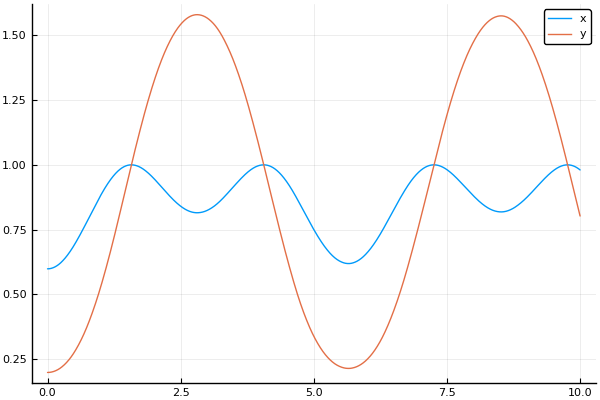

In [17]:
xtail_hist = []
ytail_hist = []

for i in 1:length(vs_reg)
    push!(xtail_hist,vs_reg[i][1,3,1])   
    push!(ytail_hist,vs_reg[i][1,3,2])    

end

plot(t_reg,xtail_hist,label="x")
plot!(t_reg,ytail_hist,label="y")

In [22]:
x_comp = [0.598948, 0.598949, 0.59895, 0.598952, 0.598954, 0.598957, 0.59896, 0.598963, 0.598968, 0.598972, 0.598978, 0.598984, 0.598991, 0.598999, 0.599007, 0.599017, 0.599027, 0.599038, 0.59905, 0.599063, 0.599076, 0.599091, 0.599106, 0.599122, 0.59914, 0.599158, 0.599177, 0.599196, 0.599216, 0.599237, 0.599259, 0.599281, 0.599304, 0.599328, 0.599353, 0.599378, 0.599405, 0.599432, 0.59946, 0.599489, 0.599518, 0.599549, 0.59958, 0.599613, 0.599647, 0.599682, 0.599718, 0.599754, 0.599791, 0.599829, 0.599867, 0.599905, 0.599944, 0.599984, 0.600026, 0.600068, 0.600112, 0.600155, 0.6002, 0.600245, 0.600291, 0.600339, 0.600387, 0.600436, 0.600486, 0.600536, 0.600587, 0.600639, 0.600692, 0.600744, 0.600798, 0.600853, 0.600908, 0.600964, 0.601021, 0.601079, 0.601137, 0.601195, 0.601254, 0.601313, 0.601374, 0.601436, 0.601498, 0.601562, 0.601627, 0.601692, 0.601757, 0.601823, 0.60189, 0.601957, 0.602026, 0.602095, 0.602166, 0.602238, 0.602311, 0.602385, 0.602459, 0.602534, 0.602609, 0.602686, 0.602763, 0.602841, 0.602919, 0.602997, 0.603076, 0.603155, 0.603236, 0.603317, 0.603399, 0.603481, 0.603564, 0.603648, 0.603732, 0.603817, 0.603903, 0.60399, 0.604077, 0.604165, 0.604255, 0.604345, 0.604437, 0.604529, 0.604622, 0.604716, 0.604811, 0.604907, 0.605003, 0.605101, 0.605199, 0.605298, 0.605396, 0.605495, 0.605595, 0.605695, 0.605796, 0.605898, 0.606001, 0.606105, 0.606211, 0.606317, 0.606426, 0.606535, 0.606644, 0.606754, 0.606866, 0.606979, 0.607092, 0.607205, 0.60732, 0.607435, 0.60755, 0.607666, 0.607782, 0.607898, 0.608015, 0.608132, 0.608249, 0.608368, 0.608486, 0.608606, 0.608727, 0.608848, 0.608971, 0.609095, 0.609219, 0.609344, 0.609469, 0.609595, 0.609722, 0.609849, 0.609976, 0.610104, 0.610232, 0.610361, 0.610491, 0.610621, 0.610751, 0.610882, 0.611013, 0.611144, 0.611277, 0.611411, 0.611547, 0.611683, 0.61182, 0.611959, 0.612099, 0.612239, 0.61238, 0.612523, 0.612667, 0.612812, 0.612957, 0.613103, 0.613251, 0.613399, 0.613547, 0.613696, 0.613846, 0.613996, 0.614148, 0.6143, 0.614453, 0.614608, 0.614764, 0.614921, 0.61508, 0.615239, 0.6154, 0.61556, 0.615722, 0.615884, 0.616048, 0.616212, 0.616376, 0.61654, 0.616705, 0.616871, 0.617037, 0.617204, 0.617371, 0.617539, 0.617706, 0.617874, 0.618043, 0.618213, 0.618384, 0.618556, 0.618728, 0.618901, 0.619076, 0.619251, 0.619427, 0.619604, 0.619782, 0.619961, 0.620141, 0.620322, 0.620503, 0.620685, 0.620869, 0.621052, 0.621237, 0.621421, 0.621608, 0.621794, 0.621982, 0.62217, 0.62236, 0.62255, 0.62274, 0.62293, 0.623123, 0.623317, 0.623512, 0.623709, 0.623906, 0.624104, 0.624303, 0.624502, 0.624702, 0.624902, 0.625104, 0.625307, 0.625509, 0.625713, 0.625917, 0.626123, 0.626328, 0.626535, 0.626742, 0.626949, 0.627158, 0.627366, 0.627574, 0.627783, 0.627992, 0.628203, 0.628414, 0.628625, 0.628837, 0.62905, 0.629263, 0.629477, 0.629691, 0.629906, 0.630121, 0.630337, 0.630554, 0.630771, 0.630988, 0.631206, 0.631425, 0.631645, 0.631865, 0.632086, 0.632307, 0.632529, 0.632752, 0.632975, 0.633199, 0.633423, 0.633648, 0.633873, 0.634099, 0.634326, 0.634553, 0.63478, 0.635008, 0.635237, 0.635467, 0.635697, 0.635927, 0.636159, 0.636392, 0.636627, 0.636861, 0.637096, 0.637332, 0.637568, 0.637806, 0.638046, 0.638285, 0.638525, 0.638765, 0.639005, 0.639246, 0.639487, 0.639729, 0.639971, 0.640214, 0.640458, 0.640701, 0.640944, 0.641188, 0.641433, 0.641679, 0.641925, 0.642173, 0.642421, 0.64267, 0.642919, 0.64317, 0.643422, 0.643675, 0.643928, 0.644182, 0.644436, 0.644691, 0.644946, 0.645201, 0.645458, 0.645716, 0.645974, 0.646233, 0.646492, 0.646752, 0.647012, 0.647273, 0.647535, 0.647798, 0.648061, 0.648324, 0.648589, 0.648855, 0.64912, 0.649386, 0.649652, 0.649919, 0.650187, 0.650456, 0.650726, 0.650996, 0.651266, 0.651538, 0.65181, 0.652083, 0.652357, 0.652631, 0.652905, 0.653181, 0.653457, 0.653734, 0.65401, 0.654288, 0.654566, 0.654844, 0.655122, 0.655401, 0.65568, 0.65596, 0.65624, 0.65652, 0.656801, 0.657082, 0.657364, 0.657645, 0.657928, 0.658211, 0.658494, 0.658777, 0.659061, 0.659345, 0.65963, 0.659916, 0.660203, 0.66049, 0.660778, 0.661068, 0.661358, 0.661649, 0.66194, 0.662232, 0.662524, 0.662817, 0.663111, 0.663405, 0.6637, 0.663996, 0.664293, 0.664591, 0.664889, 0.665189, 0.665489, 0.665789, 0.666091, 0.666392, 0.666694, 0.666996, 0.667299, 0.667602, 0.667906, 0.66821, 0.668515, 0.66882, 0.669125, 0.66943, 0.669736, 0.670043, 0.67035, 0.670659, 0.670968, 0.671278, 0.671588, 0.671899, 0.672211, 0.672524, 0.672837, 0.67315, 0.673464, 0.673779, 0.674094, 0.674409, 0.674725, 0.675041, 0.675357, 0.675674, 0.675992, 0.676311, 0.676631, 0.67695, 0.67727, 0.677591, 0.677913, 0.678236, 0.67856, 0.678884, 0.679208, 0.679532, 0.679858, 0.680183, 0.680508, 0.680834, 0.68116, 0.681488, 0.681816, 0.682145, 0.682474, 0.682805, 0.683135, 0.683466, 0.683797, 0.684128, 0.684459, 0.684791, 0.685124, 0.685458, 0.685792, 0.686126, 0.686462, 0.686797, 0.687133, 0.687469, 0.687805, 0.688141, 0.688478, 0.688815, 0.689153, 0.689492, 0.689831, 0.690171, 0.690511, 0.690851, 0.691192, 0.691534, 0.691877, 0.692221, 0.692565, 0.692909, 0.693254, 0.693599, 0.693944, 0.69429, 0.694637, 0.694984, 0.695331, 0.695679, 0.696027, 0.696376, 0.696725, 0.697073, 0.697423, 0.697772, 0.698123, 0.698474, 0.698825, 0.699178, 0.69953, 0.699883, 0.700237, 0.70059, 0.700944, 0.701298, 0.701653, 0.702008, 0.702363, 0.702718, 0.703073, 0.703429, 0.703785, 0.704141, 0.704497, 0.704854, 0.705212, 0.70557, 0.705928, 0.706287, 0.706645, 0.707004, 0.707363, 0.707722, 0.708081, 0.70844, 0.7088, 0.70916, 0.709521, 0.709883, 0.710245, 0.710607, 0.71097, 0.711333, 0.711695, 0.712058, 0.712422, 0.712785, 0.713148, 0.713512, 0.713876, 0.71424, 0.714605, 0.71497, 0.715337, 0.715703, 0.71607, 0.716436, 0.716802, 0.717168, 0.717536, 0.717903, 0.71827, 0.718638, 0.719005, 0.719373, 0.719741, 0.72011, 0.72048, 0.720849, 0.72122, 0.72159, 0.721961, 0.722332, 0.722705, 0.723078, 0.723451, 0.723824, 0.724197, 0.724571, 0.724944, 0.725318, 0.725692, 0.726066, 0.72644, 0.726814, 0.727189, 0.727563, 0.727938, 0.728313, 0.728688, 0.729064, 0.729439, 0.729815, 0.730191, 0.730567, 0.730943, 0.73132, 0.731696, 0.732073, 0.732451, 0.732829, 0.733207, 0.733586, 0.733965, 0.734344, 0.734723, 0.735102, 0.735482, 0.735861, 0.736241, 0.736621, 0.737001, 0.737382, 0.737763, 0.738144, 0.738525, 0.738906, 0.739288, 0.73967, 0.740052, 0.740435, 0.740818, 0.741201, 0.741585, 0.741969, 0.742353, 0.742737, 0.743121, 0.743506, 0.743891, 0.744277, 0.744663, 0.745049, 0.745436, 0.745823, 0.74621, 0.746598, 0.746986, 0.747374, 0.747762, 0.748151, 0.748539, 0.748927, 0.749315, 0.749703, 0.750092, 0.750481, 0.75087, 0.751259, 0.751648, 0.752038, 0.752428, 0.752818, 0.753207, 0.753596, 0.753986, 0.754375, 0.754765, 0.755155, 0.755546, 0.755938, 0.75633, 0.756723, 0.757115, 0.757507, 0.7579, 0.758293, 0.758686, 0.759079, 0.759472, 0.759866, 0.760261, 0.760656, 0.761051, 0.761446, 0.761841, 0.762236, 0.762631, 0.763026, 0.763421, 0.763817, 0.764213, 0.76461, 0.765006, 0.765403, 0.765801, 0.766198, 0.766596, 0.766994, 0.767392, 0.76779, 0.768189, 0.768588, 0.768987, 0.769386, 0.769785, 0.770185, 0.770584, 0.770984, 0.771384, 0.771784, 0.772184, 0.772585, 0.772985, 0.773386, 0.773787, 0.774187, 0.774588, 0.774989, 0.77539, 0.775792, 0.776193, 0.776593, 0.776993, 0.777394, 0.777795, 0.778197, 0.778598, 0.779, 0.779403, 0.779805, 0.780208, 0.780611, 0.781015, 0.781418, 0.781822, 0.782227, 0.782632, 0.783036, 0.783441, 0.783846, 0.784251, 0.784656, 0.785061, 0.785466, 0.785872, 0.786278, 0.786684, 0.787089, 0.787495, 0.787901, 0.788306, 0.788712, 0.789117, 0.789522, 0.789927, 0.790332, 0.790738, 0.791143, 0.791549, 0.791954, 0.79236, 0.792765, 0.793171, 0.793577, 0.793982, 0.794388, 0.794793, 0.795198, 0.795603, 0.796007, 0.796411, 0.796815, 0.797219, 0.797623, 0.798026, 0.798429, 0.798832, 0.799235, 0.799638, 0.800041, 0.800444, 0.800847, 0.801249, 0.801652, 0.802055, 0.802458, 0.802861, 0.803264, 0.803667, 0.80407, 0.804474, 0.804876, 0.805279, 0.805681, 0.806082, 0.806484, 0.806885, 0.807287, 0.80769, 0.808092, 0.808494, 0.808897, 0.8093, 0.809703, 0.810107, 0.81051, 0.810913, 0.811316, 0.811719, 0.812122, 0.812525, 0.812929, 0.813332, 0.813736, 0.81414, 0.814544, 0.814947, 0.815351, 0.815754, 0.816158, 0.816562, 0.816965, 0.817368, 0.817771, 0.818174, 0.818577, 0.81898, 0.819382, 0.819785, 0.820187, 0.820589, 0.82099, 0.821391, 0.821792, 0.822192, 0.822593, 0.822994, 0.823394, 0.823794, 0.824193, 0.824592, 0.824991, 0.82539, 0.825789, 0.826188, 0.826587, 0.826985, 0.827383, 0.827781, 0.82818, 0.828578, 0.828975, 0.829373, 0.82977, 0.830168, 0.830565, 0.830961, 0.831358, 0.831755, 0.832152, 0.832549, 0.832946, 0.833342, 0.833738, 0.834134, 0.83453, 0.834926, 0.835322, 0.835718, 0.836115, 0.836511, 0.836908, 0.837303, 0.837699, 0.838094, 0.838489, 0.838883, 0.839277, 0.83967, 0.840064, 0.840458, 0.840852, 0.841245, 0.841638, 0.842031, 0.842424, 0.842816, 0.843209, 0.843601, 0.843992, 0.844384, 0.844775, 0.845166, 0.845557, 0.845947, 0.846338, 0.846729, 0.847119, 0.847509, 0.847899, 0.848289, 0.848679, 0.849069, 0.849459, 0.849848, 0.850238, 0.850627, 0.851016, 0.851405, 0.851794, 0.852182, 0.85257, 0.852959, 0.853347, 0.853735, 0.854122, 0.85451, 0.854897, 0.855285, 0.855673, 0.85606, 0.856447, 0.856834, 0.857221, 0.857607, 0.857993, 0.858379, 0.858765, 0.85915, 0.859535, 0.85992, 0.860305, 0.860689, 0.861073, 0.861456, 0.861839, 0.862222, 0.862605, 0.862988, 0.86337, 0.863751, 0.864133, 0.864515, 0.864896, 0.865278, 0.865659, 0.86604, 0.866421, 0.866801, 0.867181, 0.867561, 0.867941, 0.868321, 0.8687, 0.869078, 0.869457, 0.869835, 0.870212, 0.87059, 0.870967, 0.871345, 0.871721, 0.872098, 0.872474, 0.87285, 0.873225, 0.8736, 0.873975, 0.87435, 0.874725, 0.875099, 0.875473, 0.875847, 0.87622, 0.876593, 0.876966, 0.877338, 0.87771, 0.878082, 0.878453, 0.878824, 0.879195, 0.879565, 0.879934, 0.880303, 0.880672, 0.881041, 0.881409, 0.881777, 0.882144, 0.882512, 0.882879, 0.883246, 0.883612, 0.883978, 0.884344, 0.88471, 0.885076, 0.88544, 0.885805, 0.886169, 0.886532, 0.886896, 0.887259, 0.887623, 0.887986, 0.888348, 0.88871, 0.889072, 0.889434, 0.889796, 0.890157, 0.890518, 0.890879, 0.891239, 0.891599, 0.891959, 0.892318, 0.892677, 0.893036, 0.893395, 0.893753, 0.894111, 0.894468, 0.894825, 0.89518, 0.895536
, 0.895891, 0.896245, 0.896599, 0.896952, 0.897305, 0.897658, 0.89801, 0.898362, 0.898714, 0.899066, 0.899418, 0.899769, 0.90012, 0.90047, 0.90082, 0.901169, 0.901517, 0.901865, 0.902213, 0.90256, 0.902906, 0.903252, 0.903597, 0.903942, 0.904287, 0.904631, 0.904974, 0.905317, 0.905659, 0.906001, 0.906342, 0.906683, 0.907023, 0.907363, 0.907702, 0.908041, 0.90838, 0.908718, 0.909055, 0.909392, 0.909729, 0.910065, 0.910401, 0.910735, 0.91107, 0.911404, 0.911738, 0.912072, 0.912405, 0.912737, 0.913069, 0.913399, 0.91373, 0.91406, 0.91439, 0.91472, 0.915049, 0.915377, 0.915705, 0.916033, 0.91636, 0.916687, 0.917014, 0.91734, 0.917665, 0.91799, 0.918315, 0.918639, 0.918962, 0.919285, 0.919607, 0.919929, 0.920249, 0.92057, 0.920889, 0.921209, 0.921528, 0.921846, 0.922164, 0.922481, 0.922798, 0.923114, 0.92343, 0.923745, 0.92406, 0.924375, 0.924689, 0.925003, 0.925317, 0.92563, 0.925942, 0.926254, 0.926566, 0.926877, 0.927187, 0.927498, 0.927807, 0.928116, 0.928425, 0.928733, 0.92904, 0.929348, 0.929655, 0.929961, 0.930267, 0.930573, 0.930878, 0.931182, 0.931486, 0.931789, 0.932091, 0.932393, 0.932695, 0.932995, 0.933295, 0.933595, 0.933894, 0.934192, 0.93449, 0.934787, 0.935084, 0.93538, 0.935675, 0.935969, 0.936263, 0.936556, 0.936849, 0.937141, 0.937432, 0.937724, 0.938014, 0.938304, 0.938594, 0.938883, 0.939171, 0.939459, 0.939746, 0.940033, 0.94032, 0.940605, 0.940891, 0.941176, 0.94146, 0.941743, 0.942026, 0.942309, 0.94259, 0.942871, 0.943152, 0.943432, 0.943711, 0.943989, 0.944267, 0.944545, 0.944821, 0.945097, 0.945372, 0.945647, 0.945921, 0.946194, 0.946467, 0.946739, 0.94701, 0.947281, 0.947551, 0.947821, 0.94809, 0.948358, 0.948627, 0.948894, 0.949161, 0.949428, 0.949694, 0.94996, 0.950224, 0.950488, 0.950751, 0.951014, 0.951276, 0.951537, 0.951798, 0.952058, 0.952318, 0.952577, 0.952837, 0.953095, 0.953353, 0.95361, 0.953867, 0.954124, 0.95438, 0.954635, 0.95489, 0.955144, 0.955398, 0.955651, 0.955904, 0.956155, 0.956407, 0.956657, 0.956908, 0.957157, 0.957405, 0.957653, 0.9579, 0.958146, 0.958392, 0.958637, 0.958881, 0.959124, 0.959367, 0.95961, 0.959852, 0.960093, 0.960334, 0.960574, 0.960813, 0.961052, 0.96129, 0.961527, 0.961764, 0.962, 0.962235, 0.96247, 0.962704, 0.962937, 0.96317, 0.963402, 0.963634, 0.963865, 0.964095, 0.964325, 0.964554, 0.964782, 0.96501, 0.965237, 0.965463, 0.965689, 0.965914, 0.966138, 0.966361, 0.966584, 0.966806, 0.967027, 0.967247, 0.967467, 0.967686, 0.967904, 0.968122, 0.968339, 0.968555, 0.968771, 0.968986, 0.9692, 0.969414, 0.969626, 0.969839, 0.970051, 0.970262, 0.970472, 0.970681, 0.97089, 0.971098, 0.971305, 0.971511, 0.971717, 0.971922, 0.972126, 0.972329, 0.972532, 0.972735, 0.972936, 0.973138, 0.973338, 0.973538, 0.973737, 0.973936, 0.974134, 0.974331, 0.974528, 0.974723, 0.974919, 0.975113, 0.975306, 0.975499, 0.975691, 0.975883, 0.976074, 0.976264, 0.976454, 0.976642, 0.97683, 0.977017, 0.977204, 0.97739, 0.977575, 0.977759, 0.977942, 0.978124, 0.978306, 0.978487, 0.978667, 0.978847, 0.979026, 0.979204, 0.979381, 0.979557, 0.979733, 0.979908, 0.980082, 0.980256, 0.980429, 0.980601, 0.980772, 0.980942, 0.981112, 0.981282, 0.98145, 0.981618, 0.981785, 0.981951, 0.982117, 0.982281, 0.982445, 0.982608, 0.982771, 0.982932, 0.983093, 0.983253, 0.983412, 0.983571, 0.983729, 0.983886, 0.984042, 0.984198, 0.984353, 0.984507, 0.98466, 0.984813, 0.984965, 0.985116, 0.985266, 0.985416, 0.985565, 0.985713, 0.98586, 0.986007, 0.986153, 0.986298, 0.986442, 0.986586, 0.986729, 0.986872, 0.987013, 0.987154, 0.987294, 0.987433, 0.987572, 0.98771, 0.987847, 0.987983, 0.988118, 0.988253, 0.988387, 0.988521, 0.988653, 0.988784, 0.988915, 0.989045, 0.989174, 0.989303, 0.98943, 0.989557, 0.989684, 0.989809, 0.989934, 0.990058, 0.990181, 0.990303, 0.990425, 0.990546, 0.990666, 0.990786, 0.990904, 0.991022, 0.991139, 0.991255, 0.991371, 0.991485, 0.991599, 0.991712, 0.991824, 0.991936, 0.992047, 0.992157, 0.992266, 0.992374, 0.992482, 0.992589, 0.992695, 0.9928, 0.992905, 0.993008, 0.993111, 0.993213, 0.993315, 0.993415, 0.993515, 0.993613, 0.993711, 0.993808, 0.993905, 0.994001, 0.994096, 0.99419, 0.994284, 0.994377, 0.994469, 0.99456, 0.994651, 0.994741, 0.99483, 0.994918, 0.995005, 0.995092, 0.995178, 0.995263, 0.995348, 0.995431, 0.995514, 0.995596, 0.995678, 0.995758, 0.995838, 0.995917, 0.995995, 0.996073, 0.99615, 0.996225, 0.9963, 0.996375, 0.996448, 0.996521, 0.996593, 0.996664, 0.996735, 0.996804, 0.996873, 0.996942, 0.997009, 0.997076, 0.997141, 0.997207, 0.997271, 0.997334, 0.997397, 0.997459, 0.99752, 0.997581, 0.997641, 0.9977, 0.997758, 0.997816, 0.997872, 0.997928, 0.997984, 0.998038, 0.998092, 0.998145, 0.998197, 0.998249, 0.9983, 0.99835, 0.998399, 0.998447, 0.998495, 0.998542, 0.998588, 0.998634, 0.998679, 0.998723, 0.998766, 0.998808, 0.99885, 0.998891, 0.998931, 0.998971, 0.999009, 0.999047, 0.999084, 0.999121, 0.999157, 0.999192, 0.999226, 0.999259, 0.999292, 0.999324, 0.999355, 0.999386, 0.999415, 0.999444, 0.999472, 0.9995, 0.999526, 0.999552, 0.999578, 0.999602, 0.999626, 0.999649, 0.999671, 0.999693, 0.999714, 0.999734, 0.999753, 0.999772, 0.999789, 0.999807, 0.999823, 0.999839, 0.999854, 0.999868, 0.999881, 0.999894, 0.999906, 0.999918, 0.999928, 0.999938, 0.999947, 0.999955, 0.999963, 0.99997, 0.999976, 0.999982, 0.999987, 0.999991, 0.999994, 0.999996, 0.999998, 1.0, 1.0, 1.0, 0.999999, 0.999997, 0.999995, 0.999991, 0.999988, 0.999983, 0.999978, 0.999972, 0.999965, 0.999958, 0.99995, 0.999941, 0.999931, 0.999921, 0.99991, 0.999898, 0.999886, 0.999873, 0.999859, 0.999845, 0.999829, 0.999813, 0.999797, 0.999779, 0.999761, 0.999743, 0.999723, 0.999703, 0.999682, 0.99966, 0.999638, 0.999615, 0.999591, 0.999567, 0.999542, 0.999516, 0.99949, 0.999462, 0.999435, 0.999406, 0.999377, 0.999347, 0.999316, 0.999285, 0.999253, 0.99922, 0.999187, 0.999153, 0.999118, 0.999083, 0.999047, 0.99901, 0.998972, 0.998934, 0.998895, 0.998856, 0.998816, 0.998775, 0.998733, 0.998691, 0.998648, 0.998604, 0.99856, 0.998515, 0.998469, 0.998423, 0.998376, 0.998328, 0.99828, 0.998231, 0.998181, 0.99813, 0.998079, 0.998028, 0.997975, 0.997922, 0.997868, 0.997814, 0.997759, 0.997703, 0.997646, 0.997589, 0.997532, 0.997473, 0.997414, 0.997354, 0.997294, 0.997233, 0.997172, 0.99711, 0.997047, 0.996983, 0.996919, 0.996855, 0.99679, 0.996724, 0.996657, 0.99659, 0.996522, 0.996454, 0.996385, 0.996315, 0.996244, 0.996173, 0.996102, 0.996029, 0.995956, 0.995883, 0.995809, 0.995734, 0.995658, 0.995582, 0.995505, 0.995428, 0.99535, 0.995271, 0.995192, 0.995112, 0.995031, 0.99495, 0.994868, 0.994786, 0.994702, 0.994619, 0.994534, 0.994449, 0.994364, 0.994277, 0.99419, 0.994103, 0.994015, 0.993926, 0.993836, 0.993746, 0.993655, 0.993564, 0.993472, 0.99338, 0.993286, 0.993192, 0.993098, 0.993003, 0.992907, 0.992811, 0.992714, 0.992616, 0.992517, 0.992418, 0.992319, 0.992219, 0.992118, 0.992017, 0.991915, 0.991813, 0.99171, 0.991607, 0.991503, 0.991398, 0.991293, 0.991187, 0.99108, 0.990973, 0.990865, 0.990757, 0.990648, 0.990538, 0.990428, 0.990318, 0.990206, 0.990095, 0.989982, 0.98987, 0.989756, 0.989642, 0.989528, 0.989413, 0.989297, 0.989181, 0.989065, 0.988948, 0.98883, 0.988712, 0.988593, 0.988473, 0.988353, 0.988232, 0.98811, 0.987988, 0.987866, 0.987743, 0.987619, 0.987495, 0.98737, 0.987244, 0.987118, 0.986992, 0.986865, 0.986737, 0.986609, 0.98648, 0.98635, 0.98622, 0.986089, 0.985958, 0.985826, 0.985693, 0.985561, 0.985427, 0.985294, 0.985159, 0.985025, 0.984889, 0.984754, 0.984618, 0.984481, 0.984344, 0.984206, 0.984068, 0.983929, 0.98379, 0.983651, 0.983511, 0.98337, 0.983229, 0.983088, 0.982946, 0.982803, 0.98266, 0.982517, 0.982372, 0.982227, 0.982082, 0.981936, 0.981789, 0.981642, 0.981494, 0.981347, 0.981198, 0.981049, 0.980899, 0.980749, 0.980598, 0.980447, 0.980295, 0.980143, 0.97999, 0.979836, 0.979683, 0.979529, 0.979374, 0.979219, 0.979064, 0.978908, 0.978752, 0.978595, 0.978438, 0.97828, 0.978122, 0.977963, 0.977804, 0.977645, 0.977485, 0.977325, 0.977163, 0.977002, 0.97684, 0.976678, 0.976515, 0.976352, 0.976188, 0.976023, 0.975858, 0.975693, 0.975528, 0.975362, 0.975196, 0.975029, 0.974862, 0.974695, 0.974527, 0.974359, 0.974191, 0.974022, 0.973854, 0.973685, 0.973515, 0.973345, 0.973174, 0.973003, 0.972832, 0.972661, 0.972489, 0.972316, 0.972144, 0.97197, 0.971797, 0.971623, 0.971448, 0.971274, 0.971099, 0.970923, 0.970747, 0.97057, 0.970393, 0.970215, 0.970037, 0.969859, 0.96968, 0.969502, 0.969323, 0.969143, 0.968963, 0.968783, 0.968602, 0.968421, 0.968239, 0.968057, 0.967875, 0.967692, 0.967509, 0.967326, 0.967142, 0.966958, 0.966773, 0.966588, 0.966403, 0.966217, 0.966031, 0.965844, 0.965657, 0.965469, 0.965282, 0.965093, 0.964905, 0.964715, 0.964526, 0.964335, 0.964145, 0.963954, 0.963762, 0.963571, 0.963379, 0.963187, 0.962995, 0.962803, 0.96261, 0.962416, 0.962222, 0.962027, 0.961832, 0.961637, 0.961441, 0.961245, 0.961048, 0.960851, 0.960654, 0.960456, 0.960258, 0.960059, 0.959861, 0.959662, 0.959462, 0.959263, 0.959063, 0.958862, 0.958662, 0.958461, 0.95826, 0.958059, 0.957857, 0.957655, 0.957453, 0.957251, 0.957048, 0.956845, 0.956642, 0.956439, 0.956235, 0.956031, 0.955827, 0.955623, 0.955418, 0.955213, 0.955008, 0.954802, 0.954596, 0.95439, 0.954183, 0.953977, 0.95377, 0.953563, 0.953356, 0.953149, 0.952941, 0.952733, 0.952525, 0.952316, 0.952107, 0.951898, 0.951689, 0.951479, 0.951269, 0.951059, 0.950849, 0.950638, 0.950428, 0.950217, 0.950006, 0.949794, 0.949583, 0.949371, 0.949159, 0.948946, 0.948733, 0.948519, 0.948306, 0.948092, 0.947877, 0.947662, 0.947448, 0.947233, 0.947018, 0.946802, 0.946586, 0.94637, 0.946154, 0.945938, 0.945721, 0.945504, 0.945287, 0.94507, 0.944853, 0.944635, 0.944417, 0.944198, 0.94398, 0.943761, 0.943542, 0.943323, 0.943104, 0.942884, 0.942664, 0.942444, 0.942223, 0.942003, 0.941782, 0.94156, 0.941339, 0.941117, 0.940895, 0.940674, 0.940452, 0.940229, 0.940006, 0.939783, 0.939559, 0.939335, 0.939111, 0.938887, 0.938663, 0.938439, 0.938215, 0.93799, 0.937766, 0.937541, 0.937316, 0.937091, 0.936865, 0.936639, 0.936414, 0.936188, 0.935963, 0.935737, 0.935511, 0.935285, 0.935059, 0.934833, 0.934607, 0.934381, 0.934155, 0.933928, 0.933702, 0.933476, 0.933249, 0.933022, 0.932795, 0.932568, 0.93234, 0.932112, 0.931884, 0.931656, 0.931429, 0.931201, 0.930974, 0.930746, 0.930518, 0.930291, 0.930063, 0.929835, 0.929607, 0.929379, 0.929151, 0.928923, 0.928695, 0.928466, 0.928237, 0.928008, 0.927779, 0.92755, 0.927321, 0.927092, 0.926863, 0.926633, 0.926403, 0.926172, 0.925942, 0.925712, 0.925481, 0.92525, 0.925019, 0.924788, 0.924557, 0.924326, 0.924095, 0.923864, 0.923632, 0.923401, 0.923169, 0.922937, 0.922706, 0.922474, 0.922242, 0.922011, 0.921779, 0.921548, 0.921316, 0.921084, 0.920852, 0.92062, 0.920388, 0.920156, 0.919924, 0.919691, 0.919459, 0.919227, 0.918994, 0.918762, 0.91853, 0.918298, 0.918066, 0.917834, 0.917602, 0.917371, 0.917139, 0.916908, 0.916676, 0.916444, 0.916211, 0.915979, 0.915747, 0.915514, 0.915282, 0.915049, 0.914817, 0.914584, 0.914352, 0.914119, 0.913887, 0.913654, 0.913422, 0.91319, 0.912958, 0.912726, 0.912494, 0.912262, 0.91203, 0.911798, 0.911567, 0.911335, 0.911103, 0.910871, 0.910639, 0.910406, 0.910173, 0.90994, 0.909707, 0.909474, 0.909242, 0.909009, 0.908776, 0.908544, 0.908311, 0.908079, 0.907847, 0.907615, 0.907384, 0.907152, 0.90692, 0.906688, 0.906456, 0.906224, 0.905993, 0.905761, 0.905529, 0.905297, 0.905065, 0.904834, 0.904602, 0.90437, 0.904139, 0.903907, 0.903676, 0.903444, 0.903213, 0.902982, 0.902751, 0.902521, 0.90229, 0.90206, 0.90183, 0.901599, 0.901369, 0.90114, 0.90091, 0.90068, 0.900449, 0.900219, 0.899989, 0.899759, 0.899528, 0.899298, 0.899067, 0.898837, 0.898606, 0.898376, 0.898146, 0.897916, 0.897686, 0.897457, 0.897227, 0.896997, 0.896768, 0.896539, 0.896311, 0.896083, 0.895855, 0.895627, 0.895399, 0.895172, 0.894945, 0.894718, 0.894491, 0.894264, 0.894037, 0.893811, 0.893586, 0.893361, 0.893135, 0.89291, 0.892686, 0.892461, 0.892237, 0.892012, 0.891787, 0.891562, 0.891337, 0.891112, 0.890888, 0.890663, 0.890439, 0.890214, 0.889989, 0.889765, 0.88954, 0.889316, 0.889091, 0.888866, 0.888641, 0.888416, 0.888192, 0.887968, 0.887744, 0.88752, 0.887297, 0.887073, 0.88685, 0.886627, 0.886404, 0.886182, 0.885959, 0.885736, 0.885513, 0.885291, 0.885068, 0.884846, 0.884624, 0.884402, 0.884181, 0.883959, 0.883738, 0.883516, 0.883295, 0.883074, 0.882853, 0.882631, 0.88241, 0.88219, 0.881969, 0.881748, 0.881527, 0.881307, 0.881087, 0.880868, 0.880648, 0.880429, 0.88021, 0.879991, 0.879772, 0.879554, 0.879336, 0.879118, 0.8789, 0.878682, 0.878464, 0.878247, 0.87803, 0.877813, 0.877596, 0.877379, 0.877162, 0.876946, 0.876729, 0.876513, 0.876296, 0.876081, 0.875866, 0.875651, 0.875436, 0.875222, 0.875007, 0.874793, 0.874578, 0.874364, 0.874149, 0.873935, 0.873721, 0.873508, 0.873295, 0.873082, 0.87287, 0.872657, 0.872445, 0.872233, 0.872022, 0.87181, 0.871599, 0.871389, 0.871179, 0.870969, 0.87076, 0.870551, 0.870342, 0.870134, 0.869926, 0.869718, 0.86951, 0.869303, 0.869096, 0.868889, 0.868683, 0.868476, 0.86827, 0.868064, 0.867858, 0.867653, 0.867447, 0.867242, 0.867037, 0.866832, 0.866627, 0.866423, 0.866218, 0.866014, 0.86581, 0.865606, 0.865402, 0.865199, 0.864996, 0.864793, 0.864592, 0.86439, 0.864189, 0.863988, 0.863787, 0.863586, 0.863385, 0.863185, 0.862986, 0.862787, 0.862589, 0.862391, 0.862193, 0.861996, 0.861799, 0.861603, 0.861407, 0.861211, 0.861015, 0.860819, 0.860624, 0.86043, 0.860235, 0.860041, 0.859846, 0.859652, 0.859458, 0.859265, 0.859072, 0.858879, 0.858687, 0.858495, 0.858303, 0.858112, 0.857921, 0.85773, 0.85754, 0.85735, 0.85716, 0.85697, 0.85678, 0.856591, 0.856402, 0.856213, 0.856025, 0.855836, 0.855648, 0.85546, 0.855273, 0.855085, 0.854899, 0.854712, 0.854526, 0.85434, 0.854154, 0.853969, 0.853784, 0.853598, 0.853414, 0.85323, 0.853046, 0.852862, 0.852679, 0.852497, 0.852315, 0.852132, 0.851951, 0.85177, 0.851589, 0.851408, 0.851228, 0.851048, 0.850869, 0.85069, 0.850511, 0.850332, 0.850153, 0.849975, 0.849796, 0.849619, 0.849441, 0.849265, 0.849089, 0.848913, 0.848738, 0.848563, 0.848389, 0.848215, 0.848042, 0.847868, 0.847695, 0.847523, 0.847351, 0.847179, 0.847007, 0.846836, 0.846665, 0.846494, 0.846324, 0.846153, 0.845984, 0.845814, 0.845646, 0.845478, 0.845311, 0.845145, 0.844979, 0.844814, 0.844649, 0.844485, 0.844321, 0.844158, 0.843995, 0.843833, 0.843671, 0.843509, 0.843347, 0.843186, 0.843025, 0.842864, 0.842703, 0.842543, 0.842383, 0.842224, 0.842066, 0.841908, 0.841751, 0.841594, 0.841437, 0.841281, 0.841126, 0.84097, 0.840814, 0.840659, 0.840505, 0.840351, 0.840196, 0.840042, 0.839889, 0.839736, 0.839584, 0.839432, 0.83928, 0.839128, 0.838977, 0.838826, 0.838676, 0.838525, 0.838374, 0.838224, 0.838074, 0.837924, 0.837775, 0.837626, 0.837477, 0.837329, 0.837182, 0.837035, 0.836889, 0.836744, 0.836598, 0.836453, 0.836309, 0.836165, 0.836022, 0.835879, 0.835737, 0.835594, 0.835452, 0.83531, 0.835169, 0.835027, 0.834886, 0.834746, 0.834606, 0.834466, 0.834327, 0.834188, 0.83405, 0.833912, 0.833774, 0.833636, 0.833499, 0.833362, 0.833226, 0.83309, 0.832955, 0.832819, 0.832685, 0.832551, 0.832419, 0.832286, 0.832155, 0.832023, 0.831892, 0.831762, 0.831632, 0.831503, 0.831373, 0.831244, 0.831116, 0.830988, 0.830861, 0.830734, 0.830607, 0.830482, 0.830356, 0.830231, 0.830107, 0.829982, 0.829858, 0.829735, 0.829612, 0.829489, 0.829367, 0.829246, 0.829125, 0.829004, 0.828884, 0.828764, 0.828644, 0.828525, 0.828406, 0.828288, 0.82817, 0.828052, 0.827935, 0.827818, 0.827702, 0.827586, 0.827471, 0.827357, 0.827243, 0.82713, 0.827018, 0.826907, 0.826796, 0.826686, 0.826576, 0.826467, 0.826359, 0.826251, 0.826144, 0.826038, 0.825931, 0.825825, 0.82572, 0.825614, 0.82551, 0.825405, 0.825302, 0.825199, 0.825097, 0.824995, 0.824895, 0.824794, 0.824695, 0.824596, 0.824497, 0.824399, 0.824301, 0.824204, 0.824107, 0.82401, 0.823914, 0.823818, 0.823723, 0.823628, 0.823535, 0.823442, 0.823349, 0.823257, 0.823165, 0.823074, 0.822983, 0.822893, 0.822804, 0.822714, 0.822626, 0.822539, 0.822452, 0.822367, 0.822281, 0.822196, 0.822111, 0.822026, 0.821942, 0.821857, 0.821773, 0.82169, 0.821606, 0.821524, 0.821442, 0.821361, 0.82128, 0.821201, 0.821121, 0.821042, 0.820964, 0.820886, 0.820809, 0.820733, 0.820656, 0.82058, 0.820504, 0.820428, 0.820353, 0.820279, 0.820205
, 0.820132, 0.820059, 0.819987, 0.819916, 0.819845, 0.819774, 0.819705, 0.819635, 0.819567, 0.819498, 0.819429, 0.819362, 0.819295, 0.819229, 0.819163, 0.819097, 0.819033, 0.818969, 0.818906, 0.818844, 0.818781, 0.818719, 0.818657, 0.818596, 0.818536, 0.818476, 0.818416, 0.818357, 0.818299, 0.818241, 0.818183, 0.818126, 0.818069, 0.818014, 0.817958, 0.817903, 0.817848, 0.817794, 0.817739, 0.817685, 0.817632, 0.81758, 0.817528, 0.817477, 0.817427, 0.817378, 0.817329, 0.817281, 0.817233, 0.817186, 0.817139, 0.817094, 0.81705, 0.817006, 0.816963, 0.816919, 0.816876, 0.816833, 0.816791, 0.81675, 0.816709, 0.81667, 0.816631, 0.816593, 0.816555, 0.816517, 0.81648, 0.816443, 0.816407, 0.816371, 0.816335, 0.8163, 0.816265, 0.81623, 0.816195, 0.816161, 0.816128, 0.816095, 0.816063, 0.816031, 0.816, 0.81597, 0.815939, 0.815909, 0.815879, 0.81585, 0.815822, 0.815794, 0.815766, 0.815738, 0.815712, 0.815686, 0.81566, 0.815636, 0.815613, 0.81559, 0.815568, 0.815546, 0.815525, 0.815504, 0.815484, 0.815465, 0.815447, 0.81543, 0.815413, 0.815397, 0.815381, 0.815366, 0.815352, 0.815338, 0.815324, 0.815312, 0.8153, 0.815287, 0.815276, 0.815265, 0.815255, 0.815246, 0.815238, 0.81523, 0.815223, 0.815216, 0.815211, 0.815205, 0.8152, 0.815196, 0.815193, 0.815191, 0.815189, 0.815187, 0.815187, 0.815187, 0.815188, 0.81519, 0.815192, 0.815195, 0.815198, 0.815201, 0.815206, 0.81521, 0.815214, 0.815218, 0.815223, 0.815227, 0.815233, 0.815239, 0.815246, 0.815252, 0.815259, 0.815267, 0.815275, 0.815284, 0.815293, 0.815304, 0.815315, 0.815326, 0.815338, 0.81535, 0.815363, 0.815376, 0.81539, 0.815405, 0.815419, 0.815435, 0.81545, 0.815466, 0.815483, 0.8155, 0.815516, 0.815534, 0.815553, 0.815572, 0.815591, 0.815611, 0.815632, 0.815652, 0.815673, 0.815695, 0.815717, 0.81574, 0.815762, 0.815785, 0.815808, 0.815831, 0.815855, 0.81588, 0.815905, 0.81593, 0.815956, 0.815983, 0.816009, 0.816037, 0.816065, 0.816093, 0.816123, 0.816153, 0.816183, 0.816214, 0.816246, 0.816278, 0.816311, 0.816345, 0.816379, 0.816414, 0.81645, 0.816486, 0.816522, 0.816559, 0.816597, 0.816634, 0.816673, 0.816712, 0.816752, 0.816792, 0.816832, 0.816872, 0.816914, 0.816955, 0.816998, 0.817041, 0.817085, 0.817131, 0.817176, 0.817222, 0.817269, 0.817315, 0.817362, 0.81741, 0.817458, 0.817506, 0.817554, 0.817602, 0.817651, 0.817701, 0.817751, 0.817802, 0.817853, 0.817905, 0.817957, 0.81801, 0.818064, 0.818118, 0.818173, 0.818228, 0.818285, 0.818342, 0.818399, 0.818457, 0.818517, 0.818576, 0.818637, 0.818697, 0.818759, 0.81882, 0.818882, 0.818945, 0.819007, 0.81907, 0.819134, 0.819198, 0.819262, 0.819327, 0.819392, 0.819457, 0.819523, 0.81959, 0.819656, 0.819723, 0.81979, 0.819858, 0.819926, 0.819995, 0.820065, 0.820135, 0.820205, 0.820275, 0.820347, 0.820419, 0.820491, 0.820564, 0.820638, 0.820712, 0.820787, 0.820862, 0.820937, 0.821013, 0.821089, 0.821166, 0.821243, 0.821321, 0.821399, 0.821478, 0.821557, 0.821637, 0.821717, 0.821797, 0.821878, 0.821959, 0.82204, 0.822121, 0.822204, 0.822287, 0.822371, 0.822455, 0.82254, 0.822626, 0.822711, 0.822797, 0.822884, 0.822972, 0.82306, 0.823148, 0.823238, 0.823328, 0.823418, 0.82351, 0.823601, 0.823693, 0.823785, 0.823878, 0.823971, 0.824064, 0.824158, 0.824252, 0.824347, 0.824442, 0.824538, 0.824634, 0.824731, 0.824828, 0.824925, 0.825023, 0.825121, 0.82522, 0.825319, 0.82542, 0.825521, 0.825622, 0.825725, 0.825827, 0.825931, 0.826034, 0.826138, 0.826242, 0.826346, 0.826451, 0.826557, 0.826663, 0.82677, 0.826877, 0.826985, 0.827094, 0.827204, 0.827314, 0.827425, 0.827536, 0.827649, 0.827761, 0.827874, 0.827987, 0.8281, 0.828213, 0.828327, 0.828441, 0.828554, 0.828668, 0.828783, 0.828898, 0.829014, 0.82913, 0.829246, 0.829362, 0.829479, 0.829596, 0.829713, 0.829831, 0.829949, 0.830068, 0.830187, 0.830307, 0.830427, 0.830548, 0.830669, 0.830792, 0.830914, 0.831037, 0.83116, 0.831283, 0.831406, 0.83153, 0.831654, 0.831779, 0.831905, 0.83203, 0.832156, 0.832283, 0.83241, 0.832538, 0.832666, 0.832794, 0.832923, 0.833052, 0.833182, 0.833312, 0.833443, 0.833574, 0.833706, 0.833838, 0.833972, 0.834105, 0.834238, 0.834372, 0.834507, 0.834642, 0.834776, 0.834911, 0.835047, 0.835183, 0.83532, 0.835457, 0.835595, 0.835733, 0.835871, 0.836009, 0.836148, 0.836288, 0.836427, 0.836568, 0.836709, 0.83685, 0.836992, 0.837135, 0.837277, 0.83742, 0.837563, 0.837706, 0.83785, 0.837994, 0.838139, 0.838284, 0.838429, 0.838575, 0.838721, 0.838868, 0.839015, 0.839163, 0.839311, 0.83946, 0.839609, 0.839758, 0.839908, 0.840059, 0.840211, 0.840362, 0.840514, 0.840667, 0.840819, 0.840973, 0.841127, 0.841281, 0.841435, 0.84159, 0.841745, 0.841901, 0.842057, 0.842214, 0.842372, 0.84253, 0.842689, 0.842849, 0.843009, 0.84317, 0.843332, 0.843494, 0.843657, 0.84382, 0.843983, 0.844147, 0.844311, 0.844476, 0.844641, 0.844807, 0.844973, 0.845138, 0.845305, 0.845472, 0.845639, 0.845807, 0.845975, 0.846144, 0.846314, 0.846484, 0.846654, 0.846824, 0.846995, 0.847167, 0.847338, 0.847509, 0.847681, 0.847852, 0.848024, 0.848197, 0.848371, 0.848544, 0.848718, 0.848892, 0.849067, 0.849241, 0.849415, 0.84959, 0.849764, 0.84994, 0.850115, 0.850291, 0.850468, 0.850645, 0.850822, 0.850999, 0.851176, 0.851354, 0.851533, 0.851711, 0.851891, 0.852071, 0.852251, 0.852432, 0.852614, 0.852796, 0.852979, 0.853162, 0.853345, 0.853529, 0.853713, 0.853898, 0.854083, 0.854269, 0.854454, 0.854641, 0.854828, 0.855015, 0.855203, 0.855391, 0.855579, 0.855768, 0.855958, 0.856147, 0.856337, 0.856528, 0.85672, 0.856912, 0.857104, 0.857296, 0.857489, 0.857682, 0.857875, 0.858068, 0.858261, 0.858455, 0.858648, 0.858842, 0.859036, 0.85923, 0.859424, 0.859619, 0.859815, 0.860012, 0.860209, 0.860406, 0.860604, 0.860801, 0.861, 0.861199, 0.861398, 0.861598, 0.861798, 0.861999, 0.862199, 0.8624, 0.862602, 0.862803, 0.863004, 0.863206, 0.863407, 0.863609, 0.863812, 0.864015, 0.864219, 0.864423, 0.864628, 0.864832, 0.865037, 0.865242, 0.865447, 0.865652, 0.865857, 0.866063, 0.866269, 0.866475, 0.866682, 0.866889, 0.867096, 0.867303, 0.867511, 0.867719, 0.867928, 0.868137, 0.868346, 0.868556, 0.868766, 0.868976, 0.869187, 0.869397, 0.869607, 0.869818, 0.870029, 0.87024, 0.870452, 0.870664, 0.870876, 0.871089, 0.871302, 0.871515, 0.871728, 0.871941, 0.872155, 0.87237, 0.872585, 0.8728, 0.873015, 0.873231, 0.873447, 0.873664, 0.87388, 0.874097, 0.874313, 0.87453, 0.874747, 0.874964, 0.875181, 0.875398, 0.875615, 0.875833, 0.876051, 0.87627, 0.876488, 0.876707, 0.876925, 0.877144, 0.877364, 0.877584, 0.877803, 0.878022, 0.878241, 0.87846, 0.87868, 0.878899, 0.879119, 0.879339, 0.879558, 0.879777, 0.879996, 0.880216, 0.880435, 0.880655, 0.880874, 0.881094, 0.881314, 0.881534, 0.881754, 0.881973, 0.882193, 0.882412, 0.882632, 0.882852, 0.883072, 0.883292, 0.883513, 0.883734, 0.883955, 0.884176, 0.884398, 0.88462, 0.884842, 0.885064, 0.885286, 0.885508, 0.885731, 0.885954, 0.886176, 0.886399, 0.886622, 0.886845, 0.887069, 0.887293, 0.887517, 0.88774, 0.887965, 0.888189, 0.888412, 0.888636, 0.888861, 0.889085, 0.889308, 0.889532, 0.889756, 0.88998, 0.890205, 0.890429, 0.890654, 0.890878, 0.891103, 0.891328, 0.891553, 0.891779, 0.892004, 0.892229, 0.892454, 0.892679, 0.892904, 0.893129, 0.893354, 0.893579, 0.893804, 0.894029, 0.894255, 0.89448, 0.894706, 0.894932, 0.895158, 0.895384, 0.89561, 0.895837, 0.896063, 0.89629, 0.896517, 0.896744, 0.896971, 0.897198, 0.897425, 0.897653, 0.897881, 0.898109, 0.898336, 0.898564, 0.898791, 0.899018, 0.899246, 0.899473, 0.8997, 0.899927, 0.900155, 0.900382, 0.900609, 0.900836, 0.901063, 0.90129, 0.901518, 0.901745, 0.901973, 0.9022, 0.902428, 0.902655, 0.902883, 0.903111, 0.903338, 0.903566, 0.903794, 0.904022, 0.90425, 0.904478, 0.904706, 0.904935, 0.905163, 0.905391, 0.905619, 0.905848, 0.906076, 0.906305, 0.906534, 0.906763, 0.906992, 0.907221, 0.90745, 0.90768, 0.907909, 0.908138, 0.908367, 0.908597, 0.908826, 0.909056, 0.909286, 0.909515, 0.909744, 0.909974, 0.910203, 0.910433, 0.910663, 0.910892, 0.911122, 0.911351, 0.911581, 0.911811, 0.912041, 0.912271, 0.912501, 0.912731, 0.912962, 0.913192, 0.913421, 0.913651, 0.913881, 0.914111, 0.914342, 0.914572, 0.914802, 0.915032, 0.915262, 0.915492, 0.915723, 0.915953, 0.916183, 0.916413, 0.916643, 0.916873, 0.917103, 0.917333, 0.917563, 0.917793, 0.918024, 0.918254, 0.918485, 0.918716, 0.918946, 0.919177, 0.919408, 0.919639, 0.91987, 0.9201, 0.920331, 0.920562, 0.920793, 0.921024, 0.921255, 0.921486, 0.921716, 0.921947, 0.922177, 0.922406, 0.922636, 0.922865, 0.923094, 0.923323, 0.923552, 0.923781, 0.92401, 0.924238, 0.924467, 0.924696, 0.924924, 0.925152, 0.92538, 0.925609, 0.925837, 0.926064, 0.926292, 0.92652, 0.926748, 0.926976, 0.927204, 0.927431, 0.927659, 0.927887, 0.928114, 0.928342, 0.928569, 0.928796, 0.929023, 0.92925, 0.929477, 0.929704, 0.92993, 0.930155, 0.930381, 0.930607, 0.930833, 0.931059, 0.931284, 0.93151, 0.931736, 0.931961, 0.932186, 0.932412, 0.932637, 0.932862, 0.933086, 0.933311, 0.933536, 0.933761, 0.933985, 0.934209, 0.934433, 0.934657, 0.93488, 0.935104, 0.935327, 0.93555, 0.935773, 0.935995, 0.936217, 0.936439, 0.936661, 0.936883, 0.937105, 0.937327, 0.937549, 0.937771, 0.937992, 0.938213, 0.938434, 0.938655, 0.938876, 0.939097, 0.939318, 0.939539, 0.939759, 0.939979, 0.940199, 0.940418, 0.940637, 0.940857, 0.941076, 0.941295, 0.941514, 0.941732, 0.941951, 0.942169, 0.942387, 0.942605, 0.942822, 0.943039, 0.943255, 0.943471, 0.943687, 0.943903, 0.944118, 0.944333, 0.944547, 0.944762, 0.944976, 0.94519, 0.945403, 0.945617, 0.94583, 0.946043, 0.946256, 0.946468, 0.94668, 0.946892, 0.947104, 0.947315, 0.947525, 0.947736, 0.947945, 0.948155, 0.948364, 0.948573, 0.948782, 0.94899, 0.949198, 0.949407, 0.949615, 0.949823, 0.950031, 0.950239, 0.950446, 0.950654, 0.950862, 0.951069, 0.951276, 0.951483, 0.95169, 0.951897, 0.952104, 0.952311, 0.952517, 0.952723, 0.952928, 0.953134, 0.953339, 0.953544, 0.953749, 0.953954, 0.954159, 0.954363, 0.954568, 0.954772, 0.954975, 0.955179, 0.955382, 0.955585, 0.955788, 0.955991, 0.956193, 0.956396, 0.956598, 0.9568, 0.957002, 0.957203, 0.957404, 0.957605, 0.957806, 0.958007, 0.958208, 0.958408, 0.958608, 0.958807, 0.959006, 0.959204, 0.959403, 0.959601, 0.959799, 0.959997, 0.960194, 0.960391, 0.960588, 0.960784, 0.960979, 0.961174, 0.961369, 0.961563, 0.961757, 0.961951, 0.962144, 0.962337, 0.962529, 0.962722, 0.962914, 0.963105, 0.963297, 0.963488, 0.963678, 0.963868, 0.964058, 0.964248, 0.964437, 0.964626, 0.964815, 0.965003, 0.965191, 0.965379, 0.965566, 0.965754, 0.96594, 0.966127, 0.966312, 0.966498, 0.966683, 0.966868, 0.967052, 0.967236, 0.967419, 0.967602, 0.967785, 0.967968, 0.96815, 0.968332, 0.968513, 0.968694, 0.968874, 0.969055, 0.969234, 0.969413, 0.969592, 0.96977, 0.969948, 0.970125, 0.970302, 0.970479, 0.970656, 0.970832, 0.971007, 0.971182, 0.971357, 0.971531, 0.971705, 0.971878, 0.972051, 0.972224, 0.972396, 0.972568, 0.97274, 0.972911, 0.973081, 0.973251, 0.973421, 0.97359, 0.973759, 0.973928, 0.974096, 0.974264, 0.974431, 0.974598, 0.974765, 0.974931, 0.975097, 0.975263, 0.975428, 0.975592, 0.975757, 0.97592, 0.976083, 0.976246, 0.976408, 0.97657, 0.976731, 0.976892, 0.977052, 0.977212, 0.977371, 0.97753, 0.977688, 0.977845, 0.978003, 0.97816, 0.978316, 0.978472, 0.978628, 0.978783, 0.978937, 0.979091, 0.979245, 0.979398, 0.97955, 0.979703, 0.979854, 0.980006, 0.980157, 0.980307, 0.980458, 0.980607, 0.980756, 0.980905, 0.981053, 0.981201, 0.981348, 0.981495, 0.981641, 0.981787, 0.981932, 0.982077, 0.982221, 0.982365, 0.982508, 0.982651, 0.982793, 0.982935, 0.983076, 0.983216, 0.983356, 0.983496, 0.983635, 0.983773, 0.983911, 0.984049, 0.984186, 0.984323, 0.984459, 0.984595, 0.98473, 0.984865, 0.984999, 0.985132, 0.985265, 0.985397, 0.985529, 0.98566, 0.985791, 0.985921, 0.98605, 0.986179, 0.986308, 0.986436, 0.986563, 0.98669, 0.986816, 0.986942, 0.987067, 0.987192, 0.987316, 0.98744, 0.987563, 0.987686, 0.987808, 0.98793, 0.988051, 0.988172, 0.988292, 0.988412, 0.988531, 0.98865, 0.988768, 0.988885, 0.989002, 0.989118, 0.989233, 0.989348, 0.989462, 0.989575, 0.989688, 0.989801, 0.989912, 0.990024, 0.990134, 0.990244, 0.990354, 0.990462, 0.99057, 0.990678, 0.990785, 0.990891, 0.990997, 0.991102, 0.991207, 0.991311, 0.991415, 0.991518, 0.99162, 0.991722, 0.991823, 0.991924, 0.992024, 0.992123, 0.992222, 0.99232, 0.992417, 0.992514, 0.99261, 0.992705, 0.992801, 0.992895, 0.992989, 0.993082, 0.993175, 0.993267, 0.993358, 0.993449, 0.993539, 0.993629, 0.993718, 0.993806, 0.993894, 0.993982, 0.994068, 0.994154, 0.99424, 0.994325, 0.994409, 0.994493, 0.994576, 0.994659, 0.994741, 0.994822, 0.994903, 0.994984, 0.995063, 0.995143, 0.995221, 0.995299, 0.995376, 0.995453, 0.995529, 0.995605, 0.99568, 0.995754, 0.995828, 0.995902, 0.995974, 0.996046, 0.996117, 0.996188, 0.996258, 0.996328, 0.996396, 0.996465, 0.996532, 0.996599, 0.996666, 0.996731, 0.996796, 0.996861, 0.996925, 0.996988, 0.99705, 0.997112, 0.997174, 0.997234, 0.997294, 0.997354, 0.997412, 0.99747, 0.997528, 0.997584, 0.99764, 0.997696, 0.99775, 0.997805, 0.997858, 0.997911, 0.997963, 0.998015, 0.998066, 0.998116, 0.998166, 0.998214, 0.998263, 0.99831, 0.998357, 0.998404, 0.998449, 0.998494, 0.998539, 0.998582, 0.998626, 0.998668, 0.99871, 0.998751, 0.998791, 0.998831, 0.99887, 0.998909, 0.998947, 0.998984, 0.99902, 0.999056, 0.999092, 0.999126, 0.99916, 0.999194, 0.999226, 0.999258, 0.99929, 0.99932, 0.99935, 0.999379, 0.999408, 0.999436, 0.999463, 0.99949, 0.999516, 0.999541, 0.999566, 0.99959, 0.999613, 0.999636, 0.999657, 0.999679, 0.999699, 0.999719, 0.999738, 0.999757, 0.999775, 0.999792, 0.999809, 0.999825, 0.99984, 0.999854, 0.999868, 0.999881, 0.999894, 0.999905, 0.999916, 0.999927, 0.999937, 0.999946, 0.999954, 0.999961, 0.999968, 0.999975, 0.99998, 0.999985, 0.999989, 0.999993, 0.999996, 0.999998, 0.999999, 1.0, 1.0, 0.999999, 0.999998, 0.999996, 0.999993, 0.99999, 0.999986, 0.999981, 0.999975, 0.999969, 0.999962, 0.999955, 0.999946, 0.999937, 0.999928, 0.999917, 0.999906, 0.999894, 0.999882, 0.999869, 0.999855, 0.99984, 0.999825, 0.999809, 0.999792, 0.999775, 0.999757, 0.999738, 0.999718, 0.999698, 0.999677, 0.999656, 0.999633, 0.99961, 0.999587, 0.999562, 0.999537, 0.999511, 0.999484, 0.999457, 0.999429, 0.9994, 0.999371, 0.999341, 0.99931, 0.999279, 0.999246, 0.999213, 0.99918, 0.999145, 0.99911, 0.999074, 0.999037, 0.999, 0.998962, 0.998923, 0.998884, 0.998844, 0.998803, 0.998761, 0.998719, 0.998676, 0.998632, 0.998588, 0.998542, 0.998497, 0.99845, 0.998403, 0.998354, 0.998306, 0.998256, 0.998206, 0.998155, 0.998103, 0.998051, 0.997998, 0.997944, 0.997889, 0.997834, 0.997778, 0.997721, 0.997663, 0.997605, 0.997546, 0.997486, 0.997426, 0.997364, 0.997302, 0.99724, 0.997177, 0.997113, 0.997048, 0.996982, 0.996916, 0.996849, 0.996781, 0.996712, 0.996643, 0.996573, 0.996502, 0.996431, 0.996358, 0.996285, 0.996211, 0.996137, 0.996062, 0.995986, 0.995909, 0.995832, 0.995754, 0.995675, 0.995596, 0.995516, 0.995435, 0.995354, 0.995271, 0.995188, 0.995104, 0.99502, 0.994934, 0.994848, 0.994762, 0.994674, 0.994586, 0.994497, 0.994408, 0.994318, 0.994227, 0.994135, 0.994042, 0.993949, 0.993855, 0.99376, 0.993665, 0.993568, 0.993472, 0.993374, 0.993276, 0.993177, 0.993077, 0.992977, 0.992876, 0.992774, 0.992672, 0.992569, 0.992465, 0.992361, 0.992255, 0.99215, 0.992043, 0.991935, 0.991827, 0.991718, 0.991609, 0.991499, 0.991388, 0.991276, 0.991164, 0.991051, 0.990938, 0.990823, 0.990708, 0.990593, 0.990476, 0.990359, 0.990241, 0.990123, 0.990003, 0.989883, 0.989762, 0.98964, 0.989518, 0.989395, 0.989271, 0.989146, 0.989021, 0.988895, 0.988769, 0.988641, 0.988513, 0.988384, 0.988255, 0.988125, 0.987994, 0.987863, 0.98773, 0.987598, 0.987464, 0.98733, 0.987195, 0.987059, 0.986923, 0.986785, 0.986647, 0.986509, 0.986369, 0.986229, 0.986088, 0.985947, 0.985804, 0.985661, 0.985517, 0.985373, 0.985228, 0.985082, 0.984935, 0.984788, 0.98464, 0.984491, 0.984342, 0.984192, 0.984041, 0.98389, 0.983738, 0.983585, 0.983431, 0.983277, 0.983122, 0.982966, 0.98281, 0.982653, 0.982495, 0.982337, 0.982178, 0.982018, 0.981857, 0.981695, 0.981533, 0.981371, 0.981207, 0.981043, 0.980878, 0.980713, 0.980546, 0.980379, 0.980211, 0.980043, 0.979874, 0.979704, 0.979534, 0.979363, 0.979191, 0.979018, 0.978845, 0.978671, 0.978496, 0.97832, 0.978144, 0.977967, 0.977789, 0.977611, 0.977432, 0.977253, 0.977073, 0.976892, 0.97671, 0.976528, 0.976345, 0.976162, 0.975978, 0.975793, 0.975608, 0.975422, 0.975235, 0.975048, 0.974861, 0.974672, 0.974483, 0.974294, 0.974103, 0.973912, 0.97372, 0.973528, 0.973334, 0.97314, 0.972945, 0.97275, 0.972553, 0.972356, 0.972158, 0.971959, 0.97176, 0.971559, 0.971359, 0.971157, 0.970955, 0.970753, 0.970549, 0.970345, 0.970141, 0.969935, 0.96973, 0.969523, 0.969316, 0.969108, 0.9689, 0.96869, 0.968481, 0.96827, 0.968059, 0.967847, 0.967634, 0.96742, 0.967206, 0.966992, 0.966777, 0.966561, 0.966345, 0.966128, 0.965911, 0.965693, 0.965475, 0.965256, 0.965036, 0.964815, 0.964594, 0.964373, 0.96415, 0.963927, 0.963703, 0.963479, 0.963254, 0.963028, 0.962802, 0.962575, 0.962347, 0.962118, 0.961889, 0.961659, 0.961428, 0.961197, 0.960965, 0.960733, 0.960499, 0.960266, 0.960031, 0.959796, 0.95956, 0.959324, 0.959087, 0.95885, 0.958612, 0.958373, 0.958133, 0.957893, 0.957652, 0.957411, 0.957169, 0.956926, 0.956683, 0.956439, 0.956194, 0.955948, 0.955702, 0.955455, 0.955208, 0.954961, 0.954712, 0.954463, 0.954214, 0.953964, 0.953713, 0.953461, 0.953208, 0.952955, 0.952701, 0.952446, 0.952191, 0.951935, 0.951679, 0.951422, 0.951164, 0.950906, 0.950646, 0.950387, 0.950126, 0.949865, 0.949604, 0.949342, 0.949079, 0.948816, 0.948552, 0.948288, 0.948023, 0.947758, 0.947492, 0.947225, 0.946958, 0.946691, 0.946423, 0.946154, 0.945885, 0.945616, 0.945346, 0.945076, 0.944805, 0.944533, 0.944261, 0.943988, 0.943715, 0.943441, 0.943166, 0.942891, 0.942615, 0.942339, 0.942062
, 0.941785, 0.941507, 0.941229, 0.94095, 0.940671, 0.940391, 0.940111, 0.939831, 0.939549, 0.939268, 0.938985, 0.938702, 0.938418, 0.938133, 0.937848, 0.937562, 0.937277, 0.936991, 0.936704, 0.936417, 0.936129, 0.935842, 0.935553, 0.935265, 0.934975, 0.934685, 0.934394, 0.934103, 0.933812, 0.93352, 0.933227, 0.932934, 0.932641, 0.932346, 0.932052, 0.931757, 0.931461, 0.931165, 0.930868, 0.93057, 0.930272, 0.929973, 0.929674, 0.929374, 0.929074, 0.928773, 0.928471, 0.928169, 0.927867, 0.927564, 0.92726, 0.926957, 0.926652, 0.926347, 0.926042, 0.925736, 0.925429, 0.925121, 0.924813, 0.924504, 0.924194, 0.923884, 0.923574, 0.923263, 0.922951, 0.922639, 0.922327, 0.922015, 0.921701, 0.921387, 0.921073, 0.920759, 0.920444, 0.920128, 0.919811, 0.919494, 0.919176, 0.918858, 0.918539, 0.91822, 0.9179, 0.91758, 0.917259, 0.916938, 0.916616, 0.916293, 0.91597, 0.915647, 0.915323, 0.914998, 0.914673, 0.914348, 0.914022, 0.913695, 0.913368, 0.91304, 0.912712, 0.912383, 0.912054, 0.911724, 0.911394, 0.911063, 0.910732, 0.9104, 0.910067, 0.909733, 0.909399, 0.909064, 0.908729, 0.908394, 0.908058, 0.907722, 0.907385, 0.907048, 0.906711, 0.906374, 0.906036, 0.905698, 0.905359, 0.90502, 0.904681, 0.90434, 0.904, 0.903659, 0.903318, 0.902976, 0.902634, 0.902291, 0.901948, 0.901604, 0.90126, 0.900916, 0.900572, 0.900227, 0.899882, 0.899537, 0.899192, 0.898846, 0.8985, 0.898153, 0.897806, 0.897459, 0.897112, 0.896763, 0.896415, 0.896066, 0.895717, 0.895367, 0.895016, 0.894665, 0.894314, 0.893962, 0.89361, 0.893257, 0.892904, 0.89255, 0.892196, 0.891841, 0.891486, 0.891131, 0.890775, 0.890419, 0.890063, 0.889706, 0.889348, 0.88899, 0.888632, 0.888273, 0.887913, 0.887554, 0.887194, 0.886834, 0.886473, 0.886112, 0.885751, 0.88539, 0.885028, 0.884666, 0.884303, 0.88394, 0.883577, 0.883214, 0.882851, 0.882487, 0.882122, 0.881757, 0.881391, 0.881025, 0.88066, 0.880294, 0.879927, 0.87956, 0.879193, 0.878825, 0.878457, 0.878089, 0.877721, 0.877353, 0.876984, 0.876615, 0.876246, 0.875877, 0.875508, 0.875138, 0.874768, 0.874398, 0.874028, 0.873659, 0.873289, 0.872918, 0.872548, 0.872178, 0.871807, 0.871436, 0.871064, 0.870691, 0.870319, 0.869946, 0.869574, 0.869201, 0.868827, 0.868454, 0.86808, 0.867705, 0.867331, 0.866957, 0.866583, 0.866209, 0.865834, 0.865459, 0.865083, 0.864708, 0.864333, 0.863957, 0.863582, 0.863206, 0.86283, 0.862455, 0.862078, 0.861702, 0.861325, 0.860949, 0.860572, 0.860195, 0.859817, 0.85944, 0.859062, 0.858683, 0.858305, 0.857927, 0.857548, 0.857169, 0.856791, 0.856412, 0.856033, 0.855654, 0.855274, 0.854894, 0.854514, 0.854134, 0.853755, 0.853375, 0.852996, 0.852617, 0.852238, 0.851859, 0.85148, 0.851101, 0.850721, 0.850342, 0.849962, 0.849582, 0.849203, 0.848822, 0.848443, 0.848063, 0.847683, 0.847304, 0.846924, 0.846544, 0.846164, 0.845784, 0.845404, 0.845024, 0.844644, 0.844264, 0.843884, 0.843503, 0.843122, 0.842741, 0.84236, 0.841978, 0.841595, 0.841213, 0.840832, 0.84045, 0.840068, 0.839686, 0.839304, 0.838922, 0.838541, 0.838159, 0.837776, 0.837394, 0.837011, 0.836629, 0.836247, 0.835865, 0.835482, 0.8351, 0.834718, 0.834336, 0.833954, 0.833571, 0.833189, 0.832807, 0.832424, 0.832041, 0.831658, 0.831275, 0.830892, 0.830509, 0.830126, 0.829742, 0.829358, 0.828974, 0.828591, 0.828207, 0.827824, 0.82744, 0.827057, 0.826674, 0.82629, 0.825906, 0.825522, 0.825138, 0.824753, 0.824367, 0.823982, 0.823596, 0.823211, 0.822826, 0.82244, 0.822055, 0.821671, 0.821286, 0.820902, 0.820518, 0.820134, 0.819749, 0.819365, 0.818981, 0.818597, 0.818213, 0.817829, 0.817446, 0.817063, 0.81668, 0.816297, 0.815914, 0.815531, 0.815149, 0.814766, 0.814383, 0.814001, 0.813618, 0.813235, 0.812852, 0.81247, 0.812088, 0.811706, 0.811323, 0.810941, 0.810559, 0.810177, 0.809795, 0.809413, 0.80903, 0.808647, 0.808264, 0.807881, 0.807498, 0.807114, 0.80673, 0.806346, 0.805963, 0.805579, 0.805195, 0.804811, 0.804428, 0.804044, 0.803661, 0.803278, 0.802895, 0.802512, 0.802129, 0.801746, 0.801364, 0.800982, 0.800599, 0.800217, 0.799835, 0.799452, 0.79907, 0.798687, 0.798305, 0.797922, 0.797539, 0.797157, 0.796775, 0.796392, 0.796011, 0.795629, 0.795247, 0.794865, 0.794483, 0.794101, 0.793719, 0.793336, 0.792954, 0.792572, 0.79219, 0.791809, 0.791428, 0.791046, 0.790665, 0.790284, 0.789903, 0.789521, 0.789139, 0.788758, 0.788376, 0.787995, 0.787613, 0.787231, 0.78685, 0.786468, 0.786087, 0.785705, 0.785324, 0.784943, 0.784562, 0.784181, 0.783801, 0.78342, 0.783039, 0.782658, 0.782277, 0.781897, 0.781517, 0.781137, 0.780757, 0.780376, 0.779996, 0.779616, 0.779236, 0.778857, 0.778478, 0.778099, 0.777721, 0.777343, 0.776965, 0.776588, 0.776211, 0.775833, 0.775456, 0.775079, 0.774703, 0.774328, 0.773953, 0.773579, 0.773205, 0.772832, 0.772459, 0.772086, 0.771713, 0.771341, 0.770968, 0.770595, 0.770222, 0.769849, 0.769476, 0.769104, 0.768732, 0.76836, 0.767989, 0.767618, 0.767247, 0.766876, 0.766505, 0.766134, 0.765764, 0.765395, 0.765027, 0.764659, 0.764292, 0.763925, 0.763558, 0.763191, 0.762825, 0.76246, 0.762095, 0.76173, 0.761365, 0.761, 0.760635, 0.760271, 0.759907, 0.759544, 0.759181, 0.758818, 0.758455, 0.758092, 0.757729, 0.757368, 0.757006, 0.756645, 0.756284, 0.755924, 0.755563, 0.755204, 0.754845, 0.754486, 0.754128, 0.753769, 0.753412, 0.753054, 0.752697, 0.752339, 0.751982, 0.751625, 0.751268, 0.750911, 0.750553, 0.750196, 0.749839, 0.749483, 0.749127, 0.748772, 0.748417, 0.748062, 0.747708, 0.747353, 0.747, 0.746646, 0.746292, 0.745939, 0.745586, 0.745234, 0.744881, 0.744529, 0.744176, 0.743823, 0.743471, 0.743119, 0.742768, 0.742416, 0.742064, 0.741713, 0.741362, 0.741011, 0.740661, 0.740311, 0.739961, 0.739611, 0.739261, 0.738912, 0.738563, 0.738214, 0.737865, 0.737517, 0.73717, 0.736824, 0.736477, 0.736132, 0.735786, 0.735441, 0.735096, 0.734752, 0.734408, 0.734064, 0.733721, 0.733379, 0.733037, 0.732695, 0.732354, 0.732013, 0.731672, 0.731331, 0.730991, 0.730651, 0.730313, 0.729974, 0.729636, 0.729298, 0.728961, 0.728625, 0.728288, 0.727952, 0.727616, 0.72728, 0.726945, 0.72661, 0.726274, 0.725939, 0.725604, 0.72527, 0.724935, 0.724601, 0.724268, 0.723935, 0.723602, 0.72327, 0.722939, 0.722607, 0.722276, 0.721945, 0.721615, 0.721284, 0.720955, 0.720625, 0.720295, 0.719965, 0.719636, 0.719307, 0.718977, 0.718648, 0.71832, 0.717992, 0.717665, 0.717338, 0.717011, 0.716686, 0.716361, 0.716036, 0.715712, 0.715388, 0.715065, 0.714744, 0.714423, 0.714101, 0.71378, 0.713459, 0.713138, 0.712817, 0.712496, 0.712177, 0.711857, 0.711538, 0.711219, 0.7109, 0.710581, 0.710263, 0.709946, 0.709629, 0.709313, 0.708997, 0.708681, 0.708366, 0.70805, 0.707735, 0.70742, 0.707106, 0.706791, 0.706477, 0.706163, 0.705849, 0.705535, 0.705222, 0.704909, 0.704597, 0.704285, 0.703974, 0.703663, 0.703352, 0.703042, 0.702732, 0.702423, 0.702114, 0.701805, 0.701497, 0.70119, 0.700883, 0.700576, 0.70027, 0.699965, 0.699659, 0.699354, 0.699049, 0.698745, 0.698441, 0.698138, 0.697835, 0.697532, 0.697231, 0.696929, 0.696628, 0.696327, 0.696028, 0.695729, 0.69543, 0.695133, 0.694838, 0.694543, 0.694248, 0.693953, 0.69366, 0.693366, 0.693074, 0.692781, 0.692489, 0.692198, 0.691906, 0.691614, 0.691323, 0.691032, 0.690742, 0.690453, 0.690165, 0.689876, 0.689588, 0.6893, 0.689012, 0.688725, 0.68844, 0.688155, 0.687871, 0.687588, 0.687306, 0.687023, 0.686742, 0.686461, 0.686181, 0.685902, 0.685623, 0.685344, 0.685065, 0.684786, 0.684509, 0.684231, 0.683954, 0.683676, 0.683398, 0.683121, 0.682845, 0.682569, 0.682295, 0.682021, 0.681748, 0.681476, 0.681204, 0.680932, 0.68066, 0.680389, 0.680118, 0.679848, 0.679577, 0.679308, 0.679039, 0.67877, 0.678502, 0.678234, 0.677967, 0.6777, 0.677434, 0.677169, 0.676904, 0.67664, 0.676378, 0.676115, 0.675853, 0.675592, 0.675331, 0.67507, 0.674811, 0.674551, 0.674291, 0.674032, 0.673774, 0.673516, 0.673258, 0.673, 0.672744, 0.672488, 0.672233, 0.671979, 0.671725, 0.671471, 0.671218, 0.670965, 0.670712, 0.67046, 0.670208, 0.669957, 0.669706, 0.669455, 0.669205, 0.668956, 0.668707, 0.668458, 0.66821, 0.667963, 0.667717, 0.667472, 0.667227, 0.666982, 0.666738, 0.666495, 0.666254, 0.666013, 0.665772, 0.665532, 0.665292, 0.665052, 0.664811, 0.664572, 0.664333, 0.664094, 0.663856, 0.663619, 0.663383, 0.663148, 0.662914, 0.66268, 0.662448, 0.662216, 0.661984, 0.661752, 0.661521, 0.66129, 0.66106, 0.66083, 0.6606, 0.660371, 0.660142, 0.659914, 0.659686, 0.659458, 0.659231, 0.659003, 0.658777, 0.658551, 0.658326, 0.658101, 0.657876, 0.657652, 0.657429, 0.657207, 0.656985, 0.656764, 0.656544, 0.656325, 0.656106, 0.655888, 0.655671, 0.655454, 0.655239, 0.655025, 0.654811, 0.654599, 0.654387, 0.654176, 0.653965, 0.653755, 0.653546, 0.653338, 0.65313, 0.652924, 0.652718, 0.652513, 0.652309, 0.652105, 0.651902, 0.6517, 0.651498, 0.651297, 0.651096, 0.650895, 0.650695, 0.650496, 0.650297, 0.650098, 0.6499, 0.649703, 0.649506, 0.649309, 0.649112, 0.648916, 0.64872, 0.648524, 0.648329, 0.648134, 0.64794, 0.647745, 0.647552, 0.647359, 0.647166, 0.646974, 0.646782, 0.646591, 0.646402, 0.646213, 0.646024, 0.645836, 0.645649, 0.645463, 0.645277, 0.645093, 0.64491, 0.644727, 0.644545, 0.644363, 0.644182, 0.644002, 0.643823, 0.643645, 0.643467, 0.64329, 0.643114, 0.642939, 0.642764, 0.642591, 0.642418, 0.642246, 0.642076, 0.641906, 0.641737, 0.641569, 0.641402, 0.641234, 0.641067, 0.640901, 0.640735, 0.640569, 0.640403, 0.640238, 0.640074, 0.639911, 0.639748, 0.639586, 0.639424, 0.639263, 0.639103, 0.638943, 0.638784, 0.638626, 0.638468, 0.638311, 0.638155, 0.637999, 0.637844, 0.63769, 0.637536, 0.637384, 0.637233, 0.637081, 0.63693, 0.636779, 0.636629, 0.636479, 0.636329, 0.636181, 0.636033, 0.635886, 0.63574, 0.635595, 0.63545, 0.635306, 0.635162, 0.635019, 0.634878, 0.634738, 0.634598, 0.634459, 0.63432, 0.634182, 0.634044, 0.633907, 0.63377, 0.633634, 0.633499, 0.633365, 0.633232, 0.633099, 0.632966, 0.632834, 0.632702, 0.63257, 0.632439, 0.632309, 0.63218, 0.632051, 0.631923, 0.631795, 0.631668, 0.631541, 0.631416
, 0.631291, 0.631168, 0.631045, 0.630922, 0.630801, 0.630679, 0.630557, 0.630436, 0.630316, 0.630197, 0.630079, 0.629961, 0.629843, 0.629726, 0.62961, 0.629495, 0.629381, 0.629268, 0.629156, 0.629045, 0.628935, 0.628826, 0.628717, 0.628608, 0.628501, 0.628393, 0.628287, 0.628181, 0.628077, 0.627974, 0.627871, 0.627768, 0.627666, 0.627564, 0.627462, 0.627361, 0.62726, 0.627158, 0.627058, 0.626958, 0.626859, 0.62676, 0.626662, 0.626565, 0.626469, 0.626374, 0.62628, 0.626185, 0.626091, 0.625997, 0.625904, 0.625811, 0.625718, 0.625626, 0.625534, 0.625443, 0.625353, 0.625262, 0.625172, 0.625083, 0.624994, 0.624905, 0.624817, 0.624729, 0.624642, 0.624556, 0.62447, 0.624385, 0.6243, 0.624216, 0.624133, 0.62405, 0.623968, 0.623887, 0.623806, 0.623726, 0.623647, 0.623568, 0.62349, 0.623413, 0.623337, 0.623262, 0.623187, 0.623112, 0.623038, 0.622964, 0.622892, 0.62282, 0.622749, 0.622679, 0.62261, 0.622542, 0.622474, 0.622407, 0.622341, 0.622275, 0.622209, 0.622144, 0.622079, 0.622014, 0.621951, 0.621888, 0.621825, 0.621763, 0.621701, 0.62164, 0.62158, 0.621521, 0.621463, 0.621405, 0.621348, 0.621293, 0.621238, 0.621183, 0.62113, 0.621077, 0.621025, 0.620974, 0.620923, 0.620874, 0.620825, 0.620776, 0.620728, 0.62068, 0.620633, 0.620588, 0.620544, 0.620501, 0.620458, 0.620417, 0.620377, 0.620337, 0.620299, 0.62026, 0.620223, 0.620186, 0.62015, 0.620115, 0.620081, 0.620048, 0.620016, 0.619984, 0.619953, 0.619923, 0.619894, 0.619865, 0.619838, 0.619811, 0.619785, 0.61976, 0.619735, 0.61971, 0.619686, 0.619662, 0.619639, 0.619616, 0.619595, 0.619574, 0.619554, 0.619534, 0.619514, 0.619496, 0.619478, 0.619461, 0.619444, 0.619429, 0.619414, 0.619399, 0.619386, 0.619373, 0.619361, 0.619349, 0.619339, 0.61933, 0.619322, 0.619315, 0.619308, 0.619301, 0.619295, 0.619289, 0.619283, 0.619277, 0.619272, 0.619266, 0.619261, 0.619257, 0.619253, 0.619249, 0.619246, 0.619243, 0.61924, 0.619238, 0.619237, 0.619237, 0.619237, 0.619238, 0.61924, 0.619243, 0.619246, 0.619251, 0.619256, 0.619263, 0.619271, 0.61928, 0.61929, 0.619301, 0.619313, 0.619325, 0.619339, 0.619353, 0.619369, 0.619385, 0.619401, 0.619419, 0.619437, 0.619455, 0.619474, 0.619494, 0.619514, 0.619536, 0.619558, 0.619581, 0.619605, 0.61963, 0.619657, 0.619684, 0.619712, 0.61974, 0.619769, 0.619799, 0.61983, 0.619861, 0.619894, 0.619928, 0.619964, 0.62, 0.620036, 0.620074, 0.620113, 0.620153, 0.620193, 0.620234, 0.620276, 0.620319, 0.620363, 0.620407, 0.620452, 0.620498, 0.620544, 0.620591, 0.620639, 0.620687, 0.620736, 0.620786, 0.620837, 0.620888, 0.620939, 0.620991, 0.621044, 0.621097, 0.621151, 0.621205, 0.621261, 0.621317, 0.621373, 0.621431, 0.621488, 0.621546, 0.621604, 0.621663, 0.621723, 0.621784, 0.621845, 0.621907, 0.621969, 0.622032, 0.622095, 0.622159, 0.622223, 0.622288, 0.622353, 0.622419, 0.622486, 0.622553, 0.62262, 0.622687, 0.622754, 0.622822, 0.62289, 0.62296, 0.62303, 0.623101, 0.623173, 0.623245, 0.623318, 0.623392, 0.623467, 0.623543, 0.62362, 0.623697, 0.623775, 0.623854, 0.623933, 0.624013, 0.624093, 0.624174, 0.624255, 0.624337, 0.624421, 0.624505, 0.624591, 0.624677, 0.624763, 0.62485, 0.624938, 0.625025, 0.625113, 0.625202, 0.625292, 0.625382, 0.625474, 0.625566, 0.625659, 0.625752, 0.625846, 0.625941, 0.626036, 0.626133, 0.62623, 0.626327, 0.626424, 0.626523, 0.626622, 0.626722, 0.626822, 0.626923, 0.627024, 0.627126, 0.627228, 0.627331, 0.627435, 0.627539, 0.627645, 0.627751, 0.627859, 0.627967, 0.628076, 0.628186, 0.628296, 0.628407, 0.628518, 0.62863, 0.628743, 0.628856, 0.628971, 0.629086, 0.629202, 0.629319, 0.629436, 0.629554, 0.629673, 0.629793, 0.629914, 0.630035, 0.630157, 0.630279, 0.630402, 0.630525, 0.630648, 0.630773, 0.630898, 0.631023, 0.631149, 0.631275, 0.631402, 0.631529, 0.631657, 0.631786, 0.631916, 0.632047, 0.632178, 0.632311, 0.632443, 0.632577, 0.632712, 0.632847, 0.632983, 0.63312, 0.633257, 0.633394, 0.633532, 0.633671, 0.63381, 0.63395, 0.63409, 0.634231, 0.634373, 0.634515, 0.634657, 0.6348, 0.634943, 0.635087, 0.635231, 0.635377, 0.635523, 0.63567, 0.635817, 0.635966, 0.636115, 0.636264, 0.636415, 0.636565, 0.636717, 0.636868, 0.637021, 0.637174, 0.637328, 0.637483, 0.637638, 0.637793, 0.63795, 0.638108, 0.638266, 0.638426, 0.638585, 0.638745, 0.638906, 0.639067, 0.639228, 0.63939, 0.639552, 0.639716, 0.639882, 0.640047, 0.640213, 0.640381, 0.640549, 0.640717, 0.640886, 0.641056, 0.641226, 0.641396, 0.641567, 0.641739, 0.64191, 0.642082, 0.642256, 0.642431, 0.642606, 0.642781, 0.642958, 0.643135, 0.643313, 0.643491, 0.643669, 0.643849, 0.644029, 0.644211, 0.644392, 0.644574, 0.644757, 0.644941, 0.645125, 0.645311, 0.645497, 0.645684, 0.645871, 0.646059, 0.646248, 0.646437, 0.646627, 0.646818, 0.647009, 0.6472, 0.647392, 0.647584, 0.647776, 0.647968, 0.648162, 0.648356, 0.648551, 0.648748, 0.648945, 0.649142, 0.649339, 0.649537, 0.649736, 0.649935, 0.650135, 0.650335, 0.650537, 0.650739, 0.650941, 0.651144, 0.651348, 0.651553, 0.651759, 0.651966, 0.652174, 0.652383, 0.652592, 0.652802, 0.653012, 0.653222, 0.653431, 0.653642, 0.653854, 0.654066, 0.654278, 0.654491, 0.654705, 0.65492, 0.655135, 0.655351, 0.655568, 0.655786, 0.656003, 0.656221, 0.65644, 0.656659, 0.656879, 0.6571, 0.657322, 0.657543, 0.657764, 0.657986, 0.658208, 0.658431, 0.658655, 0.658879, 0.659104, 0.65933, 0.659557, 0.659785, 0.660013, 0.660242, 0.660472, 0.660703, 0.660935, 0.661166, 0.661399, 0.661632, 0.661866, 0.6621, 0.662336, 0.662573, 0.66281, 0.663047, 0.663285, 0.663523, 0.663761, 0.663999, 0.664237, 0.664474, 0.664713, 0.664951, 0.66519, 0.66543, 0.66567, 0.66591, 0.666149, 0.666389, 0.66663, 0.666871, 0.667113, 0.667355, 0.667597, 0.667841, 0.668084, 0.668328, 0.668573, 0.668819, 0.669066, 0.669313, 0.669561, 0.66981, 0.670061, 0.670312, 0.670563, 0.670816, 0.671069, 0.671322, 0.671574, 0.671828, 0.672082, 0.672335, 0.672589, 0.672844, 0.673099, 0.673355, 0.673611, 0.673867, 0.674125, 0.674383, 0.674641, 0.6749, 0.675159, 0.67542, 0.675681, 0.675943, 0.676205, 0.676468, 0.676732, 0.676996, 0.67726, 0.677525, 0.677791, 0.678058, 0.678325, 0.678592, 0.67886, 0.679129, 0.679399, 0.679669, 0.679939, 0.680211, 0.680482, 0.680755, 0.681028, 0.681302, 0.681576, 0.681851, 0.682127, 0.682403, 0.682679, 0.682956, 0.683234, 0.683512, 0.683791, 0.684069, 0.684349, 0.684629, 0.68491, 0.685191, 0.685472, 0.685754, 0.686036, 0.686319, 0.686602, 0.686886, 0.687169, 0.687454, 0.687739, 0.688024, 0.68831, 0.688596, 0.688884, 0.689172, 0.689462, 0.689752, 0.690043, 0.690334, 0.690626, 0.690917, 0.69121, 0.691502, 0.691795, 0.692089, 0.692383, 0.692678, 0.692973, 0.693269, 0.693566, 0.693862, 0.69416, 0.694458, 0.694757, 0.695055, 0.695354, 0.695654, 0.695953, 0.696253, 0.696554, 0.696856, 0.697158, 0.69746, 0.697761, 0.698062, 0.698364, 0.698667, 0.69897, 0.699273, 0.699576, 0.69988, 0.700184, 0.700489, 0.700794, 0.701099, 0.701406, 0.701712, 0.702019, 0.702326, 0.702633, 0.702941, 0.703249, 0.703558, 0.703867, 0.704177, 0.704487, 0.704799, 0.705111, 0.705423, 0.705736, 0.706049, 0.706362, 0.706676, 0.70699, 0.707304, 0.707618, 0.707932, 0.708248, 0.708564, 0.70888, 0.709198, 0.709516, 0.709834, 0.710153, 0.710472, 0.710793, 0.711113, 0.711434, 0.711755, 0.712076, 0.712397, 0.712718, 0.71304, 0.713362, 0.713685, 0.714008, 0.714332, 0.714656, 0.71498, 0.715306, 0.715632, 0.715958, 0.716286, 0.716614, 0.716942, 0.71727, 0.717599, 0.717929, 0.718259, 0.71859, 0.718922, 0.719254, 0.719586, 0.719918, 0.72025, 0.720582, 0.720913, 0.721245, 0.721577, 0.721909, 0.722242, 0.722575, 0.722908, 0.723242, 0.723576, 0.72391, 0.724245, 0.724579, 0.724914, 0.725249, 0.725585, 0.72592, 0.726256, 0.726592, 0.726929, 0.727266, 0.727603, 0.727941, 0.728279, 0.728617, 0.728956, 0.729295, 0.729635, 0.729974, 0.730314, 0.730654, 0.730994, 0.731335, 0.731676, 0.732017, 0.732358, 0.7327, 0.733042, 0.733385, 0.733728, 0.734071, 0.734415, 0.73476, 0.735106, 0.735452, 0.735798, 0.736145, 0.736492, 0.73684, 0.737187, 0.737535, 0.737884, 0.738233, 0.738583, 0.738934, 0.739285, 0.739636, 0.739987, 0.740339, 0.740691, 0.741043, 0.741396, 0.741748, 0.742101, 0.742455, 0.742809, 0.743163, 0.743518, 0.743873, 0.744229, 0.744585, 0.744941, 0.745297, 0.745654, 0.746011, 0.746369, 0.746727, 0.747086, 0.747445, 0.747804, 0.748164, 0.748525, 0.748886, 0.749247, 0.749608, 0.749971, 0.750333, 0.750696, 0.751059, 0.751422, 0.751785, 0.752147, 0.752511, 0.752875, 0.753239, 0.753603, 0.753967, 0.754331, 0.754695, 0.75506, 0.755425, 0.75579, 0.756155, 0.75652, 0.756885, 0.75725, 0.757616, 0.757982, 0.758348, 0.758715, 0.759083, 0.759451, 0.759819, 0.760188, 0.760557, 0.760927, 0.761296, 0.761666, 0.762035, 0.762403, 0.762772, 0.763141, 0.763509, 0.763878, 0.764247, 0.764617, 0.764987, 0.765357, 0.765727, 0.766097, 0.766467, 0.766837, 0.767207, 0.767578, 0.767949, 0.768321, 0.768693, 0.769065, 0.769437, 0.769809, 0.770181, 0.770552, 0.770924, 0.771296, 0.771668, 0.772039, 0.772411, 0.772783, 0.773155, 0.773527, 0.7739, 0.774273, 0.774647, 0.775021, 0.775394, 0.775768, 0.776142, 0.776516, 0.77689, 0.777264, 0.777639, 0.778014, 0.778389, 0.778765, 0.779141, 0.779517, 0.779894, 0.78027, 0.780647, 0.781023, 0.7814, 0.781777, 0.782153, 0.78253, 0.782907, 0.783284, 0.783661, 0.784038, 0.784415, 0.784793, 0.78517, 0.785547, 0.785925, 0.786302, 0.78668, 0.787058, 0.787437, 0.787815, 0.788193, 0.788571, 0.78895, 0.789328, 0.789705, 0.790083, 0.790461, 0.790839, 0.791218, 0.791596, 0.791974, 0.792352, 0.79273, 0.793108, 0.793485, 0.793863, 0.79424, 0.794618, 0.794996, 0.795375, 0.795753, 0.796131, 0.796509, 0.796888, 0.797266, 0.797645, 0.798024, 0.798403, 0.798781, 0.799161, 0.79954, 0.79992, 0.8003, 0.80068, 0.80106, 0.80144, 0.80182, 0.8022, 0.802581, 0.802961, 0.803341, 0.803721, 0.804101, 0.804481, 0.80486, 0.80524, 0.805619, 0.805998, 0.806377, 0.806756, 0.807136, 0.807515, 0.807895, 0.808275, 0.808655, 0.809035, 0.809415, 0.809795, 0.810176, 0.810556, 0.810937, 0.811318, 0.811698, 0.812079, 0.812459, 0.81284, 0.81322, 0.8136, 0.81398, 0.81436, 0.81474, 0.81512, 0.815499, 0.815879, 0.816259, 0.816638, 0.817017, 0.817396, 0.817776, 0.818155, 0.818534, 0.818913, 0.819292, 0.819672, 0.820051, 0.82043, 0.820808, 0.821186, 0.821564, 0.821942, 0.82232, 0.822698, 0.823076, 0.823454, 0.823831, 0.824209, 0.824586, 0.824964, 0.825342, 0.82572, 0.826098
, 0.826476, 0.826854, 0.827233, 0.827611, 0.827989, 0.828367, 0.828745, 0.829123, 0.8295, 0.829878, 0.830256, 0.830633, 0.831009, 0.831386, 0.831763, 0.832139, 0.832516, 0.832892, 0.833269, 0.833645, 0.834021, 0.834397, 0.834772, 0.835148, 0.835524, 0.835899, 0.836275, 0.83665, 0.837025, 0.8374, 0.837775, 0.83815, 0.838525, 0.8389, 0.839274, 0.839648, 0.840022, 0.840396, 0.84077, 0.841144, 0.841517, 0.841889, 0.842262, 0.842634, 0.843006, 0.843378, 0.843751, 0.844123, 0.844495, 0.844867, 0.84524, 0.845612, 0.845984, 0.846355, 0.846727, 0.847097, 0.847468, 0.847838, 0.848208, 0.848578, 0.848947, 0.849317, 0.849687, 0.850057, 0.850426, 0.850796, 0.851166, 0.851536, 0.851905, 0.852275, 0.852644, 0.853014, 0.853383, 0.853752, 0.854122, 0.854491, 0.854859, 0.855228, 0.855596, 0.855964, 0.856333, 0.856701, 0.857069, 0.857437, 0.857805, 0.858172, 0.85854, 0.858907, 0.859275, 0.859642, 0.860008, 0.860374, 0.86074, 0.861105, 0.86147, 0.861836, 0.862201, 0.862567, 0.862933, 0.863298, 0.863663, 0.864027, 0.864392, 0.864755, 0.865119, 0.865482, 0.865844, 0.866206, 0.866568, 0.86693, 0.867291, 0.867652, 0.868013, 0.868373, 0.868733, 0.869093, 0.869452, 0.869811, 0.87017, 0.870528, 0.870887, 0.871245, 0.871603, 0.87196, 0.872318, 0.872674, 0.873031, 0.873387, 0.873744, 0.8741, 0.874455, 0.874811, 0.875166, 0.875521, 0.875876, 0.876231, 0.876586, 0.876939, 0.877293, 0.877646, 0.877999, 0.878352, 0.878704, 0.879056, 0.879408, 0.87976, 0.880112, 0.880464, 0.880815, 0.881166, 0.881517, 0.881868, 0.882218, 0.882568, 0.882917, 0.883267, 0.883616, 0.883965, 0.884314, 0.884662, 0.88501, 0.885358, 0.885705, 0.886053, 0.8864, 0.886746, 0.887093, 0.887439, 0.887785, 0.88813, 0.888476, 0.888821, 0.889166, 0.889511, 0.889856, 0.890201, 0.890545, 0.890888, 0.891232, 0.891576, 0.891919, 0.892263, 0.892607, 0.89295, 0.893292, 0.893634, 0.893977, 0.894319, 0.89466, 0.895001, 0.895341, 0.895681, 0.896022, 0.896362, 0.896701, 0.897041, 0.89738, 0.897719, 0.898058, 0.898396, 0.898734, 0.899071, 0.899408, 0.899745, 0.900081, 0.900417, 0.900753, 0.901088, 0.901422, 0.901756, 0.90209, 0.902423, 0.902756, 0.903088, 0.90342, 0.903752, 0.904082, 0.904413, 0.904742, 0.905072, 0.905401, 0.90573, 0.906058, 0.906386, 0.906714, 0.907041, 0.907368, 0.907695, 0.908021, 0.908346, 0.908672, 0.908997, 0.909321, 0.909645, 0.909969, 0.910293, 0.910616, 0.910939, 0.91126, 0.911581, 0.911902, 0.912222, 0.912542, 0.912861, 0.91318, 0.913498, 0.913817, 0.914135, 0.914453, 0.914771, 0.915088, 0.915405, 0.915721, 0.916037, 0.916352, 0.916667, 0.916982, 0.917297, 0.917611, 0.917924, 0.918237, 0.918551, 0.918864, 0.919176, 0.919488, 0.9198, 0.920112, 0.920423, 0.920733, 0.921043, 0.921352, 0.92166, 0.921968, 0.922275, 0.922582, 0.922888, 0.923193, 0.923497, 0.923801, 0.924105, 0.924408, 0.924711, 0.925012, 0.925314, 0.925615, 0.925915, 0.926215, 0.926515, 0.926814, 0.927113, 0.927411, 0.927709, 0.928007, 0.928304, 0.9286, 0.928896, 0.929191, 0.929486, 0.929781, 0.930075, 0.930368, 0.930661, 0.930953, 0.931245, 0.931536, 0.931826, 0.932117, 0.932407, 0.932696, 0.932985, 0.933274, 0.933562, 0.93385, 0.934138, 0.934425, 0.934712, 0.934997, 0.935282, 0.935566, 0.93585, 0.936133, 0.936416, 0.936699, 0.936981, 0.937262, 0.937543, 0.937823, 0.938103, 0.938382, 0.93866, 0.938937, 0.939215, 0.939491, 0.939767, 0.940043, 0.940318, 0.940592, 0.940866, 0.941139, 0.941412, 0.941684, 0.941956, 0.942227, 0.942498, 0.942768, 0.943037, 0.943306, 0.943575, 0.943842, 0.944109, 0.944376, 0.944641, 0.944907, 0.945171, 0.945435, 0.945698, 0.945961, 0.946223, 0.946484, 0.946745, 0.947005, 0.947264, 0.947523, 0.947781, 0.948038, 0.948295, 0.948551, 0.948807, 0.949062, 0.949316, 0.94957, 0.949822, 0.950075, 0.950327, 0.950578, 0.950829, 0.951079, 0.951328, 0.951577, 0.951825, 0.952073, 0.95232, 0.952566, 0.952812, 0.953058, 0.953302, 0.953547, 0.953791, 0.954035, 0.954278, 0.95452, 0.954762, 0.955003, 0.955243, 0.955483, 0.955722, 0.955961, 0.956199, 0.956436, 0.956673, 0.95691, 0.957146, 0.957381, 0.957616, 0.95785, 0.958083, 0.958316, 0.958548, 0.95878, 0.959012, 0.959242, 0.959473, 0.959703, 0.959932, 0.960161, 0.960389, 0.960616, 0.960843, 0.961068, 0.961293, 0.961518, 0.961742, 0.961965, 0.962188, 0.962409, 0.962631, 0.962852, 0.963072, 0.963292, 0.963511, 0.963729, 0.963947, 0.964164, 0.964381, 0.964596, 0.964812, 0.965027, 0.965241, 0.965455, 0.965668, 0.965881, 0.966092, 0.966303, 0.966514, 0.966724, 0.966933, 0.967142, 0.96735, 0.967557, 0.967764, 0.96797, 0.968176, 0.968381, 0.968586, 0.968789, 0.968993, 0.969195, 0.969398, 0.969599, 0.9698, 0.97, 0.970199, 0.970398, 0.970596, 0.970794, 0.970991, 0.971187, 0.971382, 0.971577, 0.971771, 0.971965, 0.972158, 0.97235, 0.972542, 0.972733, 0.972923, 0.973112, 0.973301, 0.97349, 0.973678, 0.973865, 0.974051, 0.974237, 0.974422, 0.974606, 0.974791, 0.974974, 0.975157, 0.975339, 0.975521, 0.975702, 0.975882, 0.976062, 0.976241, 0.976419, 0.976597, 0.976774, 0.97695, 0.977126, 0.977301, 0.977475, 0.977648, 0.977821, 0.977992, 0.978164, 0.978334, 0.978504, 0.978673, 0.978842, 0.97901, 0.979178, 0.979345, 0.979511, 0.979677, 0.979842, 0.980007, 0.980171, 0.980334, 0.980497, 0.980659, 0.98082, 0.980981, 0.981142, 0.981301, 0.98146, 0.981618, 0.981776, 0.981933, 0.982089, 0.982245, 0.9824, 0.982554, 0.982708, 0.982861, 0.983013, 0.983165, 0.983316, 0.983467, 0.983617, 0.983766, 0.983915, 0.984063, 0.98421, 0.984357, 0.984503, 0.984648, 0.984793, 0.984937, 0.985081, 0.985224, 0.985366, 0.985508, 0.985648, 0.985788, 0.985928, 0.986066, 0.986204, 0.986342, 0.986478, 0.986614, 0.98675, 0.986884, 0.987018, 0.987151, 0.987284, 0.987416, 0.987548, 0.987678, 0.987808, 0.987938, 0.988066, 0.988194, 0.988321, 0.988447, 0.988572, 0.988697, 0.988821, 0.988945, 0.989067, 0.989189, 0.989311, 0.989432, 0.989552, 0.989671, 0.98979, 0.989908, 0.990026, 0.990143, 0.990259, 0.990374, 0.990489, 0.990603, 0.990717, 0.99083, 0.990942, 0.991053, 0.991164, 0.991274, 0.991383, 0.991492, 0.9916, 0.991708, 0.991814, 0.99192, 0.992026, 0.992131, 0.992235, 0.992339, 0.992441, 0.992543, 0.992645, 0.992745, 0.992845, 0.992944, 0.993043, 0.99314, 0.993237, 0.993334, 0.993429, 0.993524, 0.993618, 0.993712, 0.993804, 0.993896, 0.993988, 0.994078, 0.994168, 0.994257, 0.994346, 0.994434, 0.994521, 0.994608, 0.994694, 0.99478, 0.994864, 0.994948, 0.995032, 0.995115, 0.995197, 0.995278, 0.995359, 0.995439, 0.995518, 0.995596, 0.995674, 0.995751, 0.995827, 0.995903, 0.995977, 0.996052, 0.996125, 0.996198, 0.99627, 0.996341, 0.996412, 0.996482, 0.996552, 0.99662, 0.996688, 0.996756, 0.996822, 0.996888, 0.996954, 0.997018, 0.997082, 0.997145, 0.997208, 0.99727, 0.997331, 0.997392, 0.997452, 0.997511, 0.997569, 0.997627, 0.997684, 0.99774, 0.997796, 0.99785, 0.997905, 0.997958, 0.998011, 0.998063, 0.998114, 0.998165, 0.998215, 0.998264, 0.998313, 0.998361, 0.998408, 0.998454, 0.9985, 0.998545, 0.99859, 0.998634, 0.998677, 0.998719, 0.998761, 0.998802, 0.998842, 0.998882, 0.998921, 0.998959, 0.998997, 0.999033, 0.99907, 0.999105, 0.99914, 0.999174, 0.999207, 0.99924, 0.999272, 0.999303, 0.999334, 0.999364, 0.999393, 0.999422, 0.99945, 0.999477, 0.999503, 0.999529, 0.999554, 0.999579, 0.999602, 0.999625, 0.999648, 0.99967, 0.999691, 0.999711, 0.99973, 0.999749, 0.999768, 0.999785, 0.999802, 0.999818, 0.999833, 0.999848, 0.999862, 0.999876, 0.999888, 0.9999, 0.999912, 0.999922, 0.999932, 0.999941, 0.99995, 0.999958, 0.999965, 0.999972, 0.999977, 0.999983, 0.999987, 0.999991, 0.999994, 0.999997, 0.999998, 1.0, 1.0, 1.0, 0.999999, 0.999997, 0.999995, 0.999992, 0.999989, 0.999984, 0.999979, 0.999974, 0.999967, 0.99996, 0.999953, 0.999945, 0.999936, 0.999926, 0.999916, 0.999905, 0.999893, 0.999881, 0.999868, 0.999854, 0.999839, 0.999824, 0.999809, 0.999792, 0.999775, 0.999758, 0.999739, 0.99972, 0.9997, 0.99968, 0.999659, 0.999637, 0.999615, 0.999592, 0.999568, 0.999544, 0.999519, 0.999493, 0.999466, 0.999439, 0.999412, 0.999383, 0.999354, 0.999325, 0.999294, 0.999263, 0.999232, 0.999199, 0.999166, 0.999133, 0.999098, 0.999063, 0.999028, 0.998992, 0.998955, 0.998917, 0.998879, 0.99884, 0.998801, 0.99876, 0.99872, 0.998678, 0.998636, 0.998593, 0.99855, 0.998506, 0.998461, 0.998416, 0.99837, 0.998323, 0.998276, 0.998228, 0.998179, 0.99813, 0.99808, 0.99803, 0.997978, 0.997926, 0.997874, 0.997821, 0.997767, 0.997713, 0.997658, 0.997602, 0.997545, 0.997488, 0.997431, 0.997373, 0.997314, 0.997254, 0.997194, 0.997133, 0.997071, 0.997009, 0.996946, 0.996883, 0.996819, 0.996754, 0.996688, 0.996622, 0.996556, 0.996489, 0.996421, 0.996352, 0.996283, 0.996214, 0.996143, 0.996072, 0.996001, 0.995929, 0.995856, 0.995783, 0.995709, 0.995634, 0.995559, 0.995483, 0.995407, 0.99533, 0.995252, 0.995174, 0.995095, 0.995016, 0.994935, 0.994854, 0.994773, 0.994691, 0.994608, 0.994525, 0.994441, 0.994357, 0.994272, 0.994186, 0.9941, 0.994014, 0.993926, 0.993838, 0.99375, 0.993661, 0.993571, 0.993481, 0.99339, 0.993299, 0.993207, 0.993114, 0.993021, 0.992928, 0.992833, 0.992738, 0.992643, 0.992547, 0.99245, 0.992353, 0.992255, 0.992157, 0.992058, 0.991958, 0.991858, 0.991757, 0.991656, 0.991554, 0.991452, 0.991349, 0.991245, 0.991141, 0.991036, 
0.990931, 0.990825, 0.990719, 0.990612, 0.990505, 0.990397, 0.990288, 0.990179, 0.99007, 0.98996, 0.989849, 0.989738, 0.989626, 0.989514, 0.989401, 0.989287, 0.989173, 0.989059, 0.988944, 0.988828, 0.988712, 0.988596, 0.988479, 0.988362, 0.988244, 0.988125, 0.988006, 0.987887, 0.987767, 0.987647, 0.987526, 0.987404, 0.987282, 0.98716, 0.987037, 0.986913, 0.98679, 0.986665, 0.98654, 0.986415, 0.986289, 0.986163, 0.986036, 0.985909, 0.985781, 0.985653, 0.985524, 0.985395, 0.985265, 0.985135, 0.985004, 0.984873, 0.984741, 0.984609, 0.984476, 0.984343, 0.984209, 0.984075, 0.98394, 0.983805, 0.983669, 0.983533, 0.983396, 0.983258, 0.98312, 0.982982, 0.982843, 0.982704, 0.982564, 0.982424, 0.982284, 0.982142, 0.982001, 0.981859, 0.981717, 0.981574, 0.981431, 0.981287, 0.981143, 0.980998, 0.980853, 0.980707, 0.980561, 0.980414, 0.980267, 0.98012, 0.979972, 0.979824, 0.979676, 0.979527, 0.979378, 0.979228, 0.979078, 0.978927, 0.978776, 0.978625, 0.978473, 0.97832, 0.978167, 0.978014, 0.97786, 0.977706, 0.977551, 0.977396, 0.977241, 0.977085, 0.976929, 0.976772, 0.976615, 0.976457, 0.976299, 0.976141, 0.975982, 0.975823, 0.975663, 0.975503, 0.975343, 0.975182, 0.975021, 0.974859, 0.974697, 0.974535, 0.974372, 0.974208, 0.974044, 0.97388, 0.973716, 0.973551, 0.973386, 0.97322, 0.973054, 0.972888, 0.972721, 0.972554, 0.972386, 0.972218, 0.97205, 0.971881, 0.971711, 0.971541, 0.971371, 0.9712, 0.971028, 0.970857, 0.970685, 0.970512, 0.97034, 0.970167, 0.969993, 0.96982, 0.969645, 0.969471, 0.969296, 0.969121, 0.968946, 0.96877, 0.968594, 0.968418, 0.968241, 0.968064, 0.967886, 0.967708, 0.96753, 0.967352, 0.967172, 0.966993, 0.966813, 0.966633, 0.966452, 0.966272, 0.966091, 0.96591, 0.965729, 0.965547, 0.965365, 0.965183, 0.965, 0.964817, 0.964634, 0.96445, 0.964266, 0.964081, 0.963896, 0.96371, 0.963524, 0.963338, 0.963151, 0.962964, 0.962777, 0.96259, 0.962402, 0.962214, 0.962025, 0.961836, 0.961647, 0.961458, 0.961268, 0.961078, 0.960888, 0.960697, 0.960506, 0.960314, 0.960122, 0.95993, 0.959738, 0.959545, 0.959352, 0.959159, 0.958966, 0.958773, 0.958579, 0.958385, 0.95819, 0.957995, 0.9578, 0.957605, 0.957409, 0.957213, 0.957017, 0.956821, 0.956624, 0.956427, 0.95623, 0.956032, 0.955835, 0.955636, 0.955438, 0.955239, 0.95504, 0.954841, 0.954641, 0.954441, 0.954241, 0.954041, 0.953841, 0.95364, 0.95344, 0.953239, 0.953038, 0.952837, 0.952635, 0.952434, 0.952232, 0.952031, 0.951829, 0.951627, 0.951424, 0.951221, 0.951018, 0.950815, 0.950611, 0.950408, 0.950204, 0.949999, 0.949795, 0.94959, 0.949385, 0.94918, 0.948975, 0.948769, 0.948564, 0.948358, 0.948152, 0.947946, 0.94774, 0.947533, 0.947325, 0.947118, 0.94691, 0.946703, 0.946494, 0.946286, 0.946077, 0.945868, 0.945659, 0.945449, 0.945239, 0.945028, 0.944818, 0.944608, 0.944397, 0.944186, 0.943974, 0.943763, 0.943551, 0.943339, 0.943127, 0.942915, 0.942702, 0.942489, 0.942276, 0.942063, 0.94185, 0.941636, 0.941423, 0.941209, 0.940995, 0.940782, 0.940567, 0.940353, 0.940139, 0.939925, 0.939711, 0.939497, 0.939282, 0.939068, 0.938853, 0.938638, 0.938424, 0.938209, 0.937994, 0.937779, 0.937564, 0.937349, 0.937134, 0.936918, 0.936702, 0.936487, 0.936271, 0.936055, 0.935838, 0.935622, 0.935405, 0.935188, 0.934971, 0.934754, 0.934537, 0.93432, 0.934103, 0.933885, 0.933668, 0.93345, 0.933233, 0.933015, 0.932797, 0.932579, 0.932362, 0.932144, 0.931927, 0.931709, 0.931492, 0.931274, 0.931056, 0.930837, 0.930618, 0.930399, 0.93018, 0.929961, 0.929742, 0.929523, 0.929303, 0.929084, 0.928865, 0.928646, 0.928427, 0.928209, 0.927989, 0.92777, 0.92755, 0.92733, 0.92711, 0.92689, 0.92667, 0.926449, 0.926229, 0.926009, 0.925788, 0.925568, 0.925348, 0.925127, 0.924907, 0.924687, 0.924467, 0.924246, 0.924026, 0.923807, 0.923587, 0.923367, 0.923147, 0.922927, 0.922707, 0.922487, 0.922267, 0.922047, 0.921827, 0.921607, 0.921387, 0.921167, 0.920947, 0.920727, 0.920507, 0.920288, 0.920068, 0.919848, 0.919627, 0.919407, 0.919187, 0.918966, 0.918746, 0.918525, 0.918305, 0.918085, 0.917864, 0.917643, 0.917421, 0.9172, 0.916978, 0.916756, 0.916534, 0.916312, 0.91609, 0.915868, 0.915645, 0.915423, 0.9152, 0.914978, 0.914755, 0.914532, 0.914309, 0.914085, 0.913862, 0.913638, 0.913416, 0.913193, 0.91297, 0.912747, 0.912525, 0.912302, 0.91208, 0.911857, 0.911634, 0.911411, 0.911188, 0.910965, 0.910743, 0.91052, 0.910297, 0.910075, 0.909852, 0.90963, 0.909407, 0.909185, 0.908962, 0.90874, 0.908518, 0.908295, 0.908073, 0.907852, 0.90763, 0.907409, 0.907187, 0.906966, 0.906745, 0.906524, 0.906304, 0.906083, 0.905863, 0.905642, 0.905422, 0.905201, 0.90498, 0.90476, 0.90454, 0.904319, 0.904099, 0.903879, 0.903659, 0.903438, 0.903218, 0.902997, 0.902777, 0.902557, 0.902336, 0.902116, 0.901896, 0.901676, 0.901456, 0.901236, 0.901016, 0.900797, 0.900577, 0.900358, 0.900139, 0.89992, 0.899701, 0.899482, 0.899263, 0.899044, 0.898825, 0.898606, 0.898388, 0.898169, 0.897951, 0.897732, 0.897513, 0.897295, 0.897076, 0.896859, 0.896641, 0.896424, 0.896208, 0.895991, 0.895776, 0.89556, 0.895344, 0.895128, 0.894913, 0.894697, 0.894482, 0.894266, 0.894051, 0.893836, 0.893621, 0.893406, 0.893191, 0.892976, 0.892761, 0.892547, 0.892333, 0.892119, 0.891906, 0.891692, 0.891478, 0.891265, 0.891052, 0.890839, 0.890626, 0.890412, 0.890199, 0.889986, 0.889773, 0.889559, 0.889346, 0.889133, 0.88892, 0.888707, 0.888495, 0.888283, 0.888071, 0.88786, 0.887648, 0.887437, 0.887226, 0.887015, 0.886803, 0.886592, 0.886381, 0.88617, 0.885959, 0.885749, 0.885539, 0.885329, 0.885118, 0.884908, 0.884698, 0.884489, 0.884279, 0.88407, 0.883861, 0.883652, 0.883444, 0.883235, 0.883027, 0.882819, 0.882612, 0.882404, 0.882197, 0.88199, 0.881783, 0.881577, 0.881371, 0.881164, 0.880958, 0.880753, 0.880548, 0.880342, 0.880137, 0.879932, 0.879727, 0.879522, 0.879317, 0.879112, 0.878907, 0.878701, 0.878496, 0.878291, 0.878087, 0.877882, 0.877678, 0.877474, 0.877271, 0.877067, 0.876864, 0.876662, 0.876459, 0.876256, 0.876053, 0.87585, 0.875647, 0.875444, 0.87524, 0.875037, 0.874834, 0.874631, 0.874427, 0.874224, 0.874021, 0.873818, 0.873615, 0.873412, 0.87321, 0.873007, 0.872805, 0.872603, 0.872401, 0.872199, 0.871997, 0.871796, 0.871595, 0.871394, 0.871193, 0.870993, 0.870793, 0.870592, 0.870392, 0.870193, 0.869993, 0.869794, 0.869596, 0.869398, 0.869201, 0.869003, 0.868806, 0.868609, 0.868412, 0.868215, 0.868019, 0.867822, 0.867627, 0.867431, 0.867236, 0.867042, 0.866848, 0.866654, 0.866461, 0.866267, 0.866073, 0.86588, 0.865687, 0.865494, 0.865302, 0.86511, 0.864918, 0.864727, 0.864537, 0.864346, 0.864155, 0.863965, 0.863775, 0.863586, 0.863397, 0.863208, 0.86302, 0.862832, 0.862645, 0.862458, 0.862271, 0.862085, 0.861899, 0.861713, 0.861527, 0.861341, 0.861155, 0.860969, 0.860784, 0.860599, 0.860414, 0.86023, 0.860046, 0.859862, 0.859678, 0.859495, 0.859312, 0.859129, 0.858947, 0.858765, 0.858584, 0.858403, 0.858222, 0.858042, 0.857862, 0.857682, 0.857503, 0.857323, 0.857144, 0.856965, 0.856787, 0.856609, 0.856432, 0.856254, 0.856077, 0.8559, 0.855723, 0.855548, 0.855373, 0.855198, 0.855023, 0.854849, 0.854675, 0.854502, 0.854328, 0.854155, 0.853982, 0.853809, 0.853637, 0.853465, 0.853293, 0.853121, 0.852949, 0.852777, 0.852606, 0.852436, 0.852266, 0.852096, 0.851926, 0.851756, 0.851587, 0.851418, 0.851249, 0.851081, 0.850912, 0.850744, 0.850577, 0.850409, 0.850242, 0.850076, 0.849909, 0.849743, 0.849578, 0.849413, 0.849249, 0.849085, 0.848922, 0.848758, 0.848595, 0.848432, 0.84827, 0.848108, 0.847946, 0.847785, 0.847624, 0.847463, 0.847302, 0.847141, 0.846981, 0.846822, 0.846663, 0.846505, 0.846348, 0.846191, 0.846034, 0.845877, 0.845721, 0.845565, 0.84541, 0.845254, 0.845099, 0.844945, 0.84479, 0.844637, 0.844483, 0.844331, 0.844178, 0.844026, 0.843874, 0.843723, 0.843572, 0.843421, 0.84327, 0.84312, 0.84297, 0.842821, 0.842671, 0.842523, 0.842375, 0.842228, 0.842081, 0.841935, 0.841789, 0.841644, 0.841499, 0.841354, 0.841209, 0.841065, 0.840921, 0.840778, 0.840635, 0.840493, 0.840351, 0.84021, 0.840069, 0.839927, 0.839787, 0.839646, 0.839507, 0.839367, 0.839228, 0.83909, 0.838951, 0.838813, 0.838675, 0.838537, 0.8384, 0.838263, 0.838127, 0.837991, 0.837855, 0.83772, 0.837586, 0.837451, 0.837318, 0.837185, 0.837053, 0.836921, 0.836789, 0.836657, 0.836526, 0.836396, 0.836266, 0.836136, 0.836007, 0.835879, 0.835752, 0.835626, 0.835499, 0.835373, 0.835247, 0.835122, 0.834998, 0.834875, 0.834751, 0.834628, 0.834505, 0.834382, 0.83426, 0.834138, 0.834016, 0.833896, 0.833776, 0.833656, 0.833538, 0.833418, 0.8333, 0.833181, 0.833064, 0.832947, 0.83283, 0.832713, 0.832597, 0.832481, 0.832365, 0.83225, 0.832135, 0.83202, 0.831905, 0.831791, 0.831677, 0.831563, 0.831449, 0.831337, 0.831224, 0.831112, 0.831001, 0.830891, 0.830781, 0.83067, 0.830561, 0.830451, 0.830342, 0.830234, 0.830126, 0.830019, 0.829912, 0.829806, 0.8297, 0.829595, 0.829489, 0.829384, 0.82928, 0.829176, 0.829073, 0.82897, 0.828867, 0.828765, 0.828663, 0.828562, 0.828461, 0.82836, 0.82826, 0.828161, 0.828062, 0.827963, 0.827865, 0.827769, 0.827673, 0.827577, 0.827482, 0.827387, 0.827293, 0.827199, 0.827106, 0.827013, 0.82692, 0.826828, 0.826737, 0.826647, 0.826557, 0.826467, 0.826378, 0.826289, 0.826201, 0.826114, 0.826027, 0.825941, 0.825856, 0.825771, 0.825687, 0.825603, 0.82552, 0.825438, 0.825356, 0.825274, 0.825193, 0.825112, 0.825031, 0.824951, 0.824871, 0.824792, 0.824713, 0.824635, 0.824557, 0.824479, 0.824402, 0.824326, 0.82425, 0.824174, 0.8241, 0.824025, 0.823951, 0.823877, 0.823803, 0.82373, 0.823658, 0.823586, 0.823514, 0.823442, 0.82337, 0.823299, 0.823229, 0.823159, 0.82309, 0.823021, 0.822953, 0.822886, 0.82282, 0.822754, 0.822689, 0.822624, 0.82256, 0.822497, 0.822434, 0.822371, 0.822309, 0.822248, 0.822187, 0.822128, 0.822069, 0.822011, 0.821953, 0.821895, 0.821838, 0.821781, 0.821724, 0.821668, 0.821613, 0.821558, 0.821504, 0.82145, 0.821397, 0.821344, 0.821291, 0.821239, 0.821187, 0.821136, 0.821085, 0.821035, 0.820986, 0.820936, 0.820887, 0.820838, 0.820789, 0.820742, 0.820694, 0.820648, 0.820602, 0.820556, 0.82051, 0.820465, 0.82042, 0.820375, 0.820331, 0.820287, 0.820243, 0.820199, 0.820157, 0.820114, 0.820073, 0.820031, 0.81999, 0.81995, 0.819911, 0.819872, 0.819833, 0.819795, 0.819757, 0.81972, 0.819684, 0.819647, 0.819611, 0.819576, 0.81954, 0.819506, 0.819471, 0.819438, 0.819405, 0.819372, 
0.819341, 0.81931, 0.81928, 0.81925, 0.819221, 0.819193, 0.819165, 0.819138, 0.819111, 0.819085, 0.81906, 0.819035, 0.81901, 0.818986, 0.818962, 0.818938, 0.818915, 0.818892, 0.81887, 0.818849, 0.818828, 0.818808, 0.818788, 0.818769, 0.818751, 0.818733, 0.818716, 0.818699, 0.818683, 0.818668, 0.818653, 0.818639, 0.818625, 0.818611, 0.818598, 0.818586, 0.818573, 0.818562, 0.81855, 0.818539, 0.818529, 0.81852, 0.818511, 0.818503, 0.818495, 0.818488, 0.818481, 0.818475, 0.81847, 0.818465, 0.81846, 0.818456, 0.818453, 0.81845, 0.818447, 0.818445, 0.818443, 0.818442, 0.818441, 0.818441, 0.818442, 0.818444, 0.818446, 0.818448, 0.818451, 0.818455, 0.818459, 0.818464, 0.818469, 0.818475, 0.818482, 0.818489, 0.818496, 0.818504, 0.818513, 0.818523, 0.818532, 0.818542, 0.818551, 0.818561, 0.818572, 0.818584, 0.818596, 0.818608, 0.818621, 0.818635, 0.818649, 0.818664, 0.818681, 0.818698, 0.818716, 0.818734, 0.818753, 0.818772, 0.818792, 0.818812, 0.818834, 0.818856, 0.818878, 0.818901, 0.818924, 0.818949, 0.818974, 0.819, 0.819026, 0.819053, 0.81908, 0.819108, 0.819136, 0.819164, 0.819194, 0.819225, 0.819256, 0.819288, 0.819321, 0.819354, 0.819388, 0.819423, 0.819457, 0.819492, 0.819528, 0.819564, 0.819601, 0.819639, 0.819676, 0.819714, 0.819752, 0.819791, 0.819829, 0.819869, 0.819909, 0.81995, 0.819991, 0.820033, 0.820075, 0.820119, 0.820163, 0.820207, 0.820253, 0.820299, 0.820345, 0.820392, 0.820439, 0.820487, 0.820535, 0.820584, 0.820633, 0.820683, 0.820732, 0.820782, 0.820833, 0.820884, 0.820935, 0.820987, 0.82104, 0.821094, 0.821148, 0.821203, 0.821258, 0.821315, 0.821371, 0.821428, 0.821485, 0.821542, 0.8216, 0.821659, 0.821718, 0.821778, 0.821838, 0.821899, 0.82196, 0.822021, 0.822084, 0.822146, 0.822209, 0.822273, 0.822338, 0.822404, 0.822469, 0.822536, 0.822602, 0.822669, 0.822737, 0.822806, 0.822875, 0.822945, 0.823015, 0.823085, 0.823156, 0.823228, 0.8233, 0.823373, 0.823446, 0.82352, 0.823594, 0.823668, 0.823743, 0.823819, 0.823894, 0.82397, 0.824046, 0.824123, 0.824199, 0.824277, 0.824354, 0.824432, 0.824511, 0.82459, 0.82467, 0.824751, 0.824834, 0.824916, 0.824999, 0.825082, 0.825166, 0.82525, 0.825335, 0.82542, 0.825505, 0.825592, 0.825679, 0.825767, 0.825855, 0.825943, 0.826032, 0.826121, 0.826211, 0.826301, 0.826392, 0.826483, 0.826575, 0.826667, 0.82676, 0.826854, 0.826948, 0.827042, 0.827136, 0.827232, 0.827327, 0.827423, 0.827519, 0.827616, 0.827714, 0.827813, 0.827912, 0.828012, 0.828112, 0.828212, 0.828313, 0.828415, 0.828516, 0.828619, 0.828721, 0.828824, 0.828927, 0.829031, 0.829135, 0.82924, 0.829345, 0.829451, 0.829557, 0.829663, 0.829769, 0.829876, 0.829984, 0.830092, 0.8302, 0.830308, 0.830417, 0.830526, 0.830635, 0.830744, 0.830854, 0.830963, 0.831074, 0.831184, 0.831296, 0.831408, 0.831521, 0.831634, 0.831747, 0.831861, 0.831975, 0.832091, 0.832207, 0.832324, 0.832442, 0.83256, 0.832679, 0.832798, 0.832917, 0.833037, 0.833157, 0.833278, 0.8334, 0.833522, 0.833644, 0.833766, 0.83389, 0.834014, 0.834138, 0.834263, 0.834388, 0.834513, 0.834639, 0.834766, 0.834893, 0.83502, 0.835148, 0.835277, 0.835406, 0.835535, 0.835665, 0.835796, 0.835927, 0.836059, 0.836192, 0.836324, 0.836458, 0.836592, 0.836726, 0.836861, 0.836996, 0.837132, 0.837269, 0.837406, 0.837544, 0.837682, 0.837821, 0.83796, 0.838099, 0.83824, 0.838381, 0.838523, 0.838665, 0.838807, 0.83895, 0.839093, 0.839236, 0.839379, 0.839523, 0.839666, 0.83981, 0.839955, 0.8401, 0.840245, 0.840391, 0.840536, 0.840682, 0.840829, 0.840975, 0.841122, 0.841269, 0.841417, 0.841564, 0.841712, 0.841859, 0.842007, 0.842155, 0.842304, 0.842454, 0.842603, 0.842753, 0.842903, 0.843053, 0.843203, 0.843354, 0.843505, 0.843656, 0.843808, 0.84396, 0.844113, 0.844265, 0.844418, 0.844572, 0.844726, 0.844881, 0.845037, 0.845192, 0.845348, 0.845504, 0.84566, 0.845816, 0.845973, 0.84613, 0.846287, 0.846444, 0.846602, 0.846759, 0.846918, 0.847076, 0.847235, 0.847394, 0.847553, 0.847712, 0.847872, 0.848032, 0.848193, 0.848354, 0.848516, 0.848678, 0.84884, 0.849003, 0.849166, 0.849329, 0.849492, 0.849655, 0.849819, 0.849983, 0.850148, 0.850312, 0.850477, 0.850641, 0.850806, 0.850971, 0.851136, 0.851303, 0.85147, 0.851637, 0.851805, 0.851974, 0.852142, 0.852311, 0.85248, 0.852649, 0.852818, 0.852988, 0.853158, 0.853328, 0.853499, 0.853669, 0.85384, 0.854012, 0.854184, 0.854356, 0.854529, 0.854702, 0.854875, 0.855049, 0.855223, 0.855397, 0.855573, 0.855748, 0.855924, 0.856101, 0.856278, 0.856455, 0.856632, 0.85681, 0.856988, 0.857166, 0.857344, 0.857522, 0.857701, 0.85788, 0.858059, 0.858239, 0.85842, 0.858601, 0.858782, 0.858963, 0.859145, 0.859326, 0.859508, 0.859691, 0.859874, 0.860056, 0.860239, 0.860422, 0.860606, 0.860789, 0.860973, 0.861158, 0.861342, 0.861527, 0.861712, 0.861897, 0.862081, 0.862266, 0.862451, 0.862636, 0.862822, 0.863009, 0.863196, 0.863383, 0.86357, 0.863757, 0.863944, 0.864132, 0.864321, 0.86451, 0.864699, 0.86489, 0.86508, 0.86527, 0.865461, 0.865652, 0.865843, 0.866035, 0.866226, 0.866418, 0.866611, 0.866803, 0.866995, 0.867188, 0.867382, 0.867575, 0.867769, 0.867963, 0.868157, 0.868352, 0.868547, 0.868743, 0.868939, 0.869136, 0.869333, 0.86953, 0.869727, 0.869924, 0.870122, 0.870321, 0.87052, 0.87072, 0.87092, 0.871121, 0.871321, 0.871522, 0.871723, 0.871923, 0.872123, 0.872324, 0.872524, 0.872725, 0.872926, 0.873127, 0.873329, 0.87353, 0.873732, 0.873935, 0.874138, 0.874341, 0.874544, 0.874747, 0.87495, 0.875153, 0.875356, 0.87556, 0.875763, 0.875967, 0.876171, 0.876376, 0.876581, 0.876786, 0.876993, 0.877199, 0.877406, 0.877613, 0.87782, 0.878028, 0.878236, 0.878444, 0.878652, 0.878859, 0.879067, 0.879274, 0.879482, 0.87969, 0.879898, 0.880106, 0.880315, 0.880523, 0.880731, 0.88094, 0.881149, 0.881358, 0.881567, 0.881777, 0.881986, 0.882196, 0.882406, 0.882616, 0.882827, 0.883037, 0.883248, 0.883459, 0.88367, 0.883881, 0.884092, 0.884304, 0.884516, 0.884727, 0.884939, 0.885152, 0.885364, 0.885577, 0.885791, 0.886005, 0.886219, 0.886433, 0.886648, 0.886863, 0.887078, 0.887293, 0.887508, 0.887723, 0.887938, 0.888153, 0.888368, 0.888584, 0.888799, 0.889015, 0.889231, 0.889447, 0.889663, 0.889879, 0.890096, 0.890313, 0.890529, 0.890746, 0.890963, 0.89118, 0.891397, 0.891615, 0.891832, 0.892049, 0.892266, 0.892484, 0.892701, 0.892918, 0.893136, 0.893354, 0.893571, 0.893789, 0.894006, 0.894223, 0.89444, 0.894657, 0.894874, 0.895091, 0.895309, 0.895527, 0.895745, 0.895963, 0.896182, 0.896401, 0.89662, 0.896839, 0.897058, 0.897277, 0.897497, 0.897717, 0.897936, 0.898156, 0.898375, 0.898595, 0.898815, 0.899036, 0.899256, 0.899477, 0.899699, 0.89992, 0.900142, 0.900364, 0.900585, 0.900806, 0.901028, 0.901249, 0.90147, 0.901692, 0.901913, 0.902135, 0.902357, 0.902578, 0.9028, 0.903022, 0.903244, 0.903466, 0.903689, 0.903912, 0.904134, 0.904357, 0.904581, 0.904804, 0.905027, 0.90525, 0.905473, 0.905696, 0.905919, 0.906142, 0.906365, 0.906588, 0.906811, 0.907035, 0.907258, 0.907481, 0.907705, 0.907929, 0.908152, 0.908376, 0.9086, 0.908825, 0.909049, 0.909273, 0.909497, 0.909721, 0.909945, 0.910169, 0.910393, 0.910618, 0.910842, 0.911067, 0.911292, 0.911516, 0.911741, 0.911966, 0.91219, 0.912415, 0.91264, 0.912866, 0.913092, 0.913317, 0.913542, 0.913768, 0.913993, 0.914217, 0.914442, 0.914667, 0.914893, 0.915118, 0.915343, 0.915567, 0.915792, 0.916016, 0.916241, 0.916466, 0.916691, 0.916916, 0.91714, 0.917365, 0.917589, 0.917814, 0.918038, 0.918261, 0.918485, 0.918708, 0.918932, 0.919155, 0.919378, 0.919601, 0.919824, 0.920047, 0.92027, 0.920493, 0.920716, 0.920938, 0.921161, 0.921384, 0.921607, 0.921831, 0.922054, 0.922277, 0.9225, 0.922723, 0.922945, 0.923168, 0.923391, 0.923614, 0.923836, 0.924059, 0.924282, 0.924505, 0.924728, 0.92495, 0.925172, 0.925394, 0.925615, 0.925837, 0.926059, 0.926281, 0.926502, 0.926724, 0.926946, 0.927168, 0.92739, 0.927613, 0.927834, 0.928055, 0.928277, 0.928497, 0.928718, 0.928939, 0.92916, 0.929381, 0.929602, 0.929823, 0.930044, 0.930264, 0.930485, 0.930706, 0.930927, 0.931147, 0.931367, 0.931587, 0.931807, 0.932027, 0.932246, 0.932466, 0.932686, 0.932905, 0.933125, 0.933345, 0.933564, 0.933784, 0.934003, 0.934223, 0.934442, 0.934661, 0.934881, 0.935101, 0.93532, 0.935539, 0.935757, 0.935975, 0.936193, 0.936411, 0.936629, 0.936847, 0.937065, 0.937282, 0.9375, 0.937717, 0.937935, 0.938152, 0.938369, 0.938586, 0.938802, 0.939018, 0.939234, 0.93945, 0.939665, 0.939881, 0.940096, 0.940311, 0.940526, 0.94074, 0.940955, 0.941169, 0.941383, 0.941596, 0.941809, 0.942022, 0.942235, 0.942447, 0.942659, 0.942871, 0.943082, 0.943293, 0.943504, 0.943715, 0.943926, 0.944136, 0.944347, 0.944557, 0.944768, 0.944978, 0.945188, 0.945398, 0.945608, 0.945817, 0.946027, 0.946236, 0.946445, 0.946654, 0.946863, 0.947071, 0.94728, 0.947489, 0.947697, 0.947905, 0.948112, 0.94832, 0.948527, 0.948734, 0.948941, 0.949148, 0.949354, 0.949561, 0.949767, 0.949973, 0.950179, 0.950385, 0.950591, 0.950797, 0.951002, 0.951207, 0.951411, 0.951616, 0.95182, 0.952024, 0.952229, 0.952432, 0.952636, 0.952839, 0.953042, 0.953244, 0.953446, 0.953648, 0.95385, 0.954051
, 0.954251, 0.954452, 0.954652, 0.954851, 0.95505, 0.955249, 0.955448, 0.955646, 0.955844, 0.956042, 0.95624, 0.956437, 0.956634, 0.956831, 0.957027, 0.957223, 0.957419, 0.957615, 0.95781, 0.958005, 0.9582, 0.958395, 0.958589, 0.958783, 0.958977, 0.959171, 0.959364, 0.959556, 0.959749, 0.959941, 0.960133, 0.960325, 0.960516, 0.960707, 0.960898, 0.961089, 0.961279, 0.961469, 0.961658, 0.961848, 0.962036, 0.962225, 0.962413, 0.962601, 0.962788, 0.962975, 0.963162, 0.963348, 0.963534, 0.96372, 0.963905, 0.96409, 0.964274, 0.964458, 0.964642, 0.964826, 0.965009, 0.965192, 0.965375, 0.965557, 0.965739, 0.965921, 0.966103, 0.966284, 0.966465, 0.966645, 0.966826, 0.967006, 0.967185, 0.967365, 0.967544, 0.967722, 0.9679, 0.968078, 0.968256, 0.968433, 0.96861, 0.968786, 0.968962, 0.969138, 0.969314, 0.969489, 0.969664, 0.969838, 0.970012, 0.970185, 0.970358, 0.970531, 0.970704, 0.970876, 0.971047, 0.971218, 0.971389, 0.971559, 0.971729, 0.971899, 0.972068, 0.972237, 0.972406, 0.972574, 0.972742, 0.972909, 0.973076, 0.973243, 0.973409, 0.973575, 0.97374, 0.973905, 0.97407, 0.974235, 0.974399, 0.974563, 0.974726, 0.974889, 0.975052, 0.975214, 0.975376, 0.975538, 0.975699, 0.975859, 0.97602, 0.976179, 0.976339, 0.976497, 0.976656, 0.976813, 0.976971, 0.977128, 0.977284, 0.97744, 0.977596, 0.977752, 0.977907, 0.978061, 0.978215, 0.978369, 0.978522, 0.978675, 0.978827, 0.978979, 0.97913, 0.97928, 0.979431, 0.97958, 0.97973, 0.979878, 0.980027, 0.980175, 0.980322, 0.980469, 0.980615, 0.980761, 0.980907, 0.981052, 0.981197, 0.981341, 0.981485, 0.981629, 0.981772, 0.981915, 0.982057, 0.982199, 0.982341, 0.982482, 0.982622, 0.982762, 0.982902, 0.983041, 0.98318, 0.983318, 0.983456, 0.983593, 0.983729, 0.983866, 0.984001, 0.984137, 0.984272, 0.984406, 0.984539, 0.984672, 0.984805, 0.984937, 0.985069, 0.9852, 0.98533, 0.98546, 0.98559, 0.985719, 0.985848, 0.985976, 0.986103, 0.986231, 0.986357, 0.986484, 0.986609, 0.986734, 0.986859, 0.986983, 0.987107, 0.98723, 0.987352, 0.987475, 0.987596, 0.987717, 0.987838, 0.987958, 0.988078, 0.988197, 0.988315, 0.988433, 0.988551, 0.988668, 0.988784, 0.9889, 0.989015, 0.98913, 0.989244, 0.989358, 0.989471, 0.989583, 0.989695, 0.989807, 0.989918, 0.990029, 0.990138, 0.990248, 0.990357, 0.990465, 0.990573, 0.99068, 0.990787, 0.990893, 0.990999, 0.991104, 0.991208, 0.991312, 0.991415, 0.991518, 0.99162, 0.991721, 0.991823, 0.991923, 0.992023, 0.992122, 0.992221, 0.992319, 0.992417, 0.992513, 0.99261, 0.992705, 0.9928, 0.992894, 0.992988, 0.993081, 0.993174, 0.993266, 0.993358, 0.993448, 0.993539, 0.993628, 0.993717, 0.993805, 0.993893, 0.993981, 0.994067, 0.994153, 0.994239, 0.994324, 0.994408, 0.994492, 0.994575, 0.994657, 0.994739, 0.994821, 0.994901, 0.994982, 0.995061, 0.99514, 0.995219, 0.995296, 0.995374, 0.99545, 0.995527, 0.995602, 0.995677, 0.995751, 0.995825, 0.995898, 0.995971, 0.996042, 0.996113, 0.996184, 0.996253, 0.996323, 0.996391, 0.996459, 0.996526, 0.996593, 0.996659, 0.996724, 0.996789, 0.996853, 0.996917, 0.99698, 0.997042, 0.997104, 0.997165, 0.997225, 0.997285, 0.997344, 0.997403, 0.997461, 0.997518, 0.997575, 0.997631, 0.997686, 0.997741, 0.997795, 0.997849, 0.997902, 0.997954, 0.998005, 0.998056, 0.998106, 0.998156, 0.998205, 0.998253, 0.998301, 0.998348, 0.998395, 0.99844, 0.998486, 0.99853, 0.998574, 0.998617, 0.99866, 0.998702, 0.998743, 0.998784, 0.998824, 0.998864, 0.998903, 0.998941, 0.998978, 0.999015, 0.999051, 0.999087, 0.999122, 0.999156, 0.999189, 0.999222, 0.999254, 0.999286, 0.999317, 0.999347, 0.999377, 0.999405, 0.999434, 0.999461, 0.999488, 0.999514, 0.99954, 0.999564, 0.999588, 0.999612, 0.999635, 0.999657, 0.999678, 0.999699, 0.999719, 0.999738, 0.999757, 0.999774, 0.999792, 0.999808, 0.999824, 0.999839, 0.999854, 0.999868, 0.999881, 0.999893, 0.999905, 0.999916, 0.999927, 0.999936, 0.999945, 0.999954, 0.999961, 0.999968, 0.999975, 0.99998, 0.999985, 0.999989, 0.999993, 0.999996, 0.999998, 0.999999, 1.0, 1.0, 0.999999, 0.999998, 0.999996, 0.999993, 0.99999, 0.999985, 0.999981, 0.999975, 0.999969, 0.999962, 0.999954, 0.999946, 0.999937, 0.999927, 0.999916, 0.999905, 0.999893, 0.99988, 0.999867, 0.999853, 0.999838, 0.999823, 0.999806, 0.99979, 0.999772, 0.999753, 0.999734, 0.999715, 0.999694, 0.999673, 0.999651, 0.999628, 0.999605, 0.99958, 0.999556, 0.99953, 0.999504, 0.999477, 0.999449, 0.99942, 0.999391, 0.999361, 0.999331, 0.999299, 0.999267, 0.999234, 0.999201, 0.999167, 0.999132, 0.999096, 0.99906, 0.999023, 0.998985, 0.998947, 0.998907, 0.998868, 0.998827, 0.998785, 0.998743, 0.9987, 0.998657, 0.998613, 0.998568, 0.998522, 0.998476, 0.998429, 0.998381, 0.998333, 0.998283, 0.998234, 0.998183, 0.998132, 0.99808, 0.998027, 0.997974, 0.99792, 0.997865, 0.997809, 0.997753, 0.997696, 0.997638, 0.99758, 0.99752, 0.997461, 0.9974, 0.997339, 0.997277, 0.997214, 0.997151, 0.997087, 0.997022, 0.996956, 0.99689, 0.996823, 0.996755, 0.996687, 0.996618, 0.996548, 0.996477, 0.996406, 0.996334, 0.996262, 0.996188, 0.996114, 0.99604, 0.995964, 0.995888, 0.995811, 0.995733, 0.995655, 0.995576, 0.995496, 0.995415, 0.995334, 0.995252, 0.995169, 0.995086, 0.995001, 0.994916, 0.994831, 0.994744, 0.994657, 0.994569, 0.99448, 0.994391, 0.994301, 0.99421, 0.994118, 0.994026, 0.993933, 0.993839, 0.993745, 0.99365, 0.993554, 0.993457, 0.99336, 0.993262, 0.993163, 0.993064, 0.992964, 0.992863, 0.992761, 0.992659, 0.992556, 0.992452, 0.992347, 0.992242, 0.992136, 0.992029, 0.991922, 0.991814, 0.991705, 0.991595, 0.991485, 0.991373, 0.991262, 0.991149, 0.991036, 0.990922, 0.990807, 0.990692, 0.990576, 0.990459, 0.990342, 0.990224, 0.990105, 0.989985, 0.989865, 0.989744, 0.989622, 0.9895, 0.989376, 0.989253, 0.989128, 0.989002, 0.988876, 0.988749, 0.988622, 0.988493, 0.988364, 0.988234, 0.988103, 0.987971, 0.987839, 0.987706, 0.987573, 0.987439, 0.987304, 0.987168, 0.987032, 0.986895, 0.986757, 0.986618, 0.986479, 0.986339, 0.986198, 0.986056, 0.985913, 0.98577, 0.985627, 0.985482, 0.985337, 0.985191, 0.985045, 0.984898, 0.98475, 0.984602, 0.984453, 0.984303, 0.984152, 0.984001, 0.983849, 0.983696, 0.983542, 0.983388, 0.983233, 0.983077, 0.982921, 0.982764, 0.982606, 0.982447, 0.982288, 0.982129, 0.981968, 0.981807, 0.981646, 0.981483, 0.98132, 0.981156, 0.980992, 0.980827, 0.980661, 0.980494, 0.980327];

In [24]:
y_comp = [0.199212, 0.199212, 0.199214, 0.199215, 0.199217, 0.199219, 0.199221, 0.199224, 0.199227, 0.19923, 0.199234, 0.199239, 0.199244, 0.19925, 0.199256, 0.199263, 0.199271, 0.19928, 0.199289, 0.199298, 0.199308, 0.199319, 0.19933, 0.199343, 0.199355, 0.199369, 0.199383, 0.199398, 0.199413, 0.199428, 0.199445, 0.199461, 0.199479, 0.199497, 0.199515, 0.199534, 0.199554, 0.199574, 0.199595, 0.199617, 0.199639, 0.199662, 0.199685, 0.19971, 0.199735, 0.199762, 0.199788, 0.199816, 0.199843, 0.199872, 0.1999, 0.199929, 0.199958, 0.199988, 0.200019, 0.200051, 0.200084, 0.200116, 0.20015, 0.200184, 0.200218, 0.200254, 0.200291, 0.200327, 0.200365, 0.200403, 0.200441, 0.20048, 0.200519, 0.200559, 0.200599, 0.20064, 0.200682, 0.200724, 0.200767, 0.20081, 0.200854, 0.200898, 0.200942, 0.200987, 0.201032, 0.201079, 0.201126, 0.201174, 0.201223, 0.201272, 0.201321, 0.201371, 0.201421, 0.201472, 0.201523, 0.201576, 0.201629, 0.201684, 0.201739, 0.201795, 0.20185, 0.201907, 0.201964, 0.202021, 0.20208, 0.202138, 0.202197, 0.202257, 0.202316, 0.202376, 0.202437, 0.202499, 0.202561, 0.202623, 0.202685, 0.202749, 0.202813, 0.202877, 0.202942, 0.203008, 0.203074, 0.203141, 0.203209, 0.203277, 0.203347, 0.203417, 0.203487, 0.203559, 0.203631, 0.203704, 0.203777, 0.203851, 0.203926, 0.204001, 0.204076, 0.204151, 0.204227, 0.204303, 0.20438, 0.204458, 0.204536, 0.204616, 0.204696, 0.204777, 0.20486, 0.204943, 0.205027, 0.205111, 0.205196, 0.205282, 0.205368, 0.205455, 0.205542, 0.205631, 0.205719, 0.205807, 0.205896, 0.205985, 0.206074, 0.206164, 0.206254, 0.206345, 0.206436, 0.206527, 0.20662, 0.206713, 0.206808, 0.206903, 0.206998, 0.207094, 0.20719, 0.207287, 0.207384, 0.207482, 0.20758, 0.207679, 0.207777, 0.207877, 0.207976, 0.208077, 0.208177, 0.208278, 0.208379, 0.208481, 0.208583, 0.208687, 0.208792, 0.208897, 0.209003, 0.209111, 0.209219, 0.209327, 0.209437, 0.209547, 0.209659, 0.209771, 0.209884, 0.209997, 0.210112, 0.210227, 0.210342, 0.210458, 0.210574, 0.210691, 0.210809, 0.210928, 0.211047, 0.211167, 0.211289, 0.211412, 0.211535, 0.21166, 0.211785, 0.21191, 0.212037, 0.212163, 0.212291, 0.212419, 0.212548, 0.212676, 0.212806, 0.212936, 0.213066, 0.213197, 0.213328, 0.213459, 0.213591, 0.213723, 0.213856, 0.21399, 0.214124, 0.214259, 0.214395, 0.214531, 0.214669, 0.214807, 0.214946, 0.215085, 0.215226, 0.215367, 0.215509, 0.215652, 0.215796, 0.21594, 0.216085, 0.216231, 0.216377, 0.216524, 0.216671, 0.216819, 0.216968, 0.217118, 0.217269, 0.21742, 0.217571, 0.217723, 0.217876, 0.218031, 0.218186, 0.218343, 0.218501, 0.218659, 0.218817, 0.218977, 0.219136, 0.219297, 0.219458, 0.219621, 0.219783, 0.219947, 0.220111, 0.220275, 0.220441, 0.220606, 0.220773, 0.22094, 0.221108, 0.221275, 0.221443, 0.221612, 0.221781, 0.22195, 0.222121, 0.222292, 0.222463, 0.222635, 0.222807, 0.222981, 0.223154, 0.223329, 0.223503, 0.223678, 0.223854, 0.224031, 0.224208, 0.224385, 0.224563, 0.224742, 0.224921, 0.225101, 0.225282, 0.225464, 0.225646, 0.225828, 0.226011, 0.226194, 0.226378, 0.226563, 0.226748, 0.226934, 0.22712, 0.227307, 0.227495, 0.227683, 0.227872, 0.228061, 0.228251, 0.228442, 0.228635, 0.228828, 0.229022, 0.229216, 0.22941, 0.229606, 0.229803, 0.230001, 0.2302, 0.230399, 0.230598, 0.230798, 0.230998, 0.231198, 0.231399, 0.231601, 0.231804, 0.232007, 0.232209, 0.232412, 0.232616, 0.232821, 0.233027, 0.233233, 0.23344, 0.233648, 0.233857, 0.234066, 0.234277, 0.234488, 0.234701, 0.234914, 0.235128, 0.235342, 0.235557, 0.235772, 0.235988, 0.236204, 0.236422, 0.236641, 0.23686, 0.23708, 0.2373, 0.23752, 0.237742, 0.237964, 0.238187, 0.238411, 0.238636, 0.238861, 0.239088, 0.239314, 0.239541, 0.239769, 0.239997, 0.240226, 0.240456, 0.240687, 0.240919, 0.241151, 0.241384, 0.241618, 0.241853, 0.242088, 0.242324, 0.24256, 0.242798, 0.243036, 0.243275, 0.243515, 0.243754, 0.243995, 0.244236, 0.244477, 0.244719, 0.244961, 0.245204, 0.245447, 0.245691, 0.245936, 0.246181, 0.246426, 0.246672, 0.246919, 0.247166, 0.247414, 0.247662, 0.24791, 0.24816, 0.24841, 0.248661, 0.248912, 0.249165, 0.249419, 0.249674, 0.24993, 0.250186, 0.250443, 0.250701, 0.25096, 0.251219, 0.251479, 0.25174, 0.252001, 0.252264, 0.252528, 0.252792, 0.253058, 0.253325, 0.253592, 0.25386, 0.254129, 0.254399, 0.254668, 0.254939, 0.25521, 0.255482, 0.255754, 0.256028, 0.256301, 0.256575, 0.25685, 0.257125, 0.257401, 0.257677, 0.257955, 0.258234, 0.258514, 0.258794, 0.259075, 0.259357, 0.259641, 0.259925, 0.260209, 0.260494, 0.26078, 0.261067, 0.261354, 0.261642, 0.26193, 0.262219, 0.262509, 0.2628, 0.263091, 0.263384, 0.263677, 0.263971, 0.264266, 0.264561, 0.264858, 0.265156, 0.265455, 0.265754, 0.266054, 0.266355, 0.266656, 0.266957, 0.267259, 0.267562, 0.267866, 0.26817, 0.268476, 0.268783, 0.26909, 0.269399, 0.269708, 0.270018, 0.270328, 0.270638, 0.270949, 0.271261, 0.271573, 0.271887, 0.272202, 0.272518, 0.272834, 0.273151, 0.273468, 0.273786, 0.274104, 0.274423, 0.274742, 0.275063, 0.275384, 0.275707, 0.27603, 0.276353, 0.276678, 0.277003, 0.277329, 0.277657, 0.277985, 0.278314, 0.278645, 0.278975, 0.279307, 0.279638, 0.279971, 0.280305, 0.280639, 0.280974, 0.28131, 0.281647, 0.281985, 0.282323, 0.282661, 0.283, 0.28334, 0.28368, 0.284022, 0.284364, 0.284708, 0.285052, 0.285397, 0.285743, 0.286089, 0.286436, 0.286784, 0.287132, 0.287481, 0.28783, 0.288181, 0.288531, 0.288882, 0.289234, 0.289587, 0.28994, 0.290293, 0.290648, 0.291003, 0.29136, 0.291716, 0.292074, 0.292432, 0.29279, 0.293149, 0.293509, 0.293869, 0.294229, 0.29459, 0.294953, 0.295316, 0.29568, 0.296045, 0.296411, 0.296778, 0.297144, 0.297512, 0.29788, 0.298248, 0.298617, 0.298987, 0.299357, 0.299728, 0.300099, 0.300472, 0.300845, 0.30122, 0.301595, 0.301971, 0.302347, 0.302723, 0.3031, 0.303478, 0.303857, 0.304236, 0.304616, 0.304995, 0.305376, 0.305757, 0.30614, 0.306524, 0.306908, 0.307293, 0.307679, 0.308066, 0.308454, 0.308843, 0.309233, 0.309624, 0.310015, 0.310407, 0.3108, 0.311193, 0.311586, 0.31198, 0.312375, 0.31277, 0.313166, 0.313562, 0.313959, 0.314357, 0.314756, 0.315154, 0.315554, 0.315954, 0.316355, 0.316757, 0.317159, 0.317562, 0.317965, 0.318369, 0.318774, 0.31918, 0.319587, 0.319995, 0.320403, 0.320813, 0.321223, 0.321633, 0.322044, 0.322455, 0.322867, 0.32328, 0.323694, 0.324108, 0.324524, 0.32494, 0.325356, 0.325773, 0.326192, 0.326611, 0.32703, 0.327451, 0.327872, 0.328294, 0.328717, 0.329141, 0.329565, 0.329991, 0.330416, 0.330843, 0.331271, 0.331699, 0.332128, 0.332559, 0.332991, 0.333423, 0.333856, 0.33429, 0.334724, 0.33516, 0.335596, 0.336033, 0.336471, 0.336909, 0.337347, 0.337786, 0.338226, 0.338667, 0.339108, 0.33955, 0.339992, 0.340436, 0.34088, 0.341325, 0.341771, 0.342216, 0.342662, 0.343109, 0.343556, 0.344004, 0.344454, 0.344904, 0.345357, 0.34581, 0.346264, 0.346718, 0.347173, 0.347629, 0.348086, 0.348543, 0.349001, 0.349461, 0.349921, 0.350382, 0.350845, 0.351308, 0.351772, 0.352236, 0.352701, 0.353167, 0.353632, 0.354099, 0.354567, 0.355037, 0.355507, 0.355977, 0.356449, 0.356922, 0.357396, 0.357871, 0.358346, 0.358822, 0.359299, 0.359776, 0.360255, 0.360735, 0.361216, 0.361697, 0.362179, 0.362662, 0.363146, 0.36363, 0.364115, 0.364601, 0.365088, 0.365576, 0.366064, 0.366554, 0.367043, 0.367534, 0.368026, 0.368518, 0.369011, 0.369504, 0.369998, 0.370491, 0.370986, 0.371482, 0.371979, 0.372477, 0.372976, 0.373477, 0.373978, 0.37448, 0.374983, 0.375488, 0.375993, 0.376499, 0.377007, 0.377515, 0.378024, 0.378534, 0.379044, 0.379556, 0.380068, 0.380582, 0.381096, 0.381611, 0.382127, 0.382644, 0.383161, 0.383679, 0.384198, 0.384717, 0.385237, 0.385757, 0.386277, 0.386799, 0.387321, 0.387845, 0.388369, 0.388894, 0.389419, 0.389946, 0.390473, 0.391001, 0.39153, 0.392059, 0.392589, 0.393119, 0.39365, 0.394181, 0.394713, 0.395245, 0.395777, 0.39631, 0.396843, 0.397377, 0.397912, 0.398446, 0.398982, 0.399518, 0.400055, 0.400593, 0.401131, 0.401669, 0.402209, 0.40275, 0.403291, 0.403834, 0.404377, 0.404921, 0.405466, 0.406011, 0.406558, 0.407103, 0.40765, 0.408196, 0.408744, 0.409292, 0.409841, 0.410392, 0.410943, 0.411496, 0.412049, 0.412604, 0.41316, 0.413717, 0.414275, 0.414833, 0.415392, 0.415952, 0.416513, 0.417074, 0.417637, 0.418201, 0.418765, 0.419331, 0.419898, 0.420465, 0.421033, 0.421602, 0.422172, 0.422742, 0.423312, 0.423884, 0.424456, 0.425029, 0.425603, 0.426178, 0.426753, 0.427328, 0.427904, 0.428481, 0.429058, 0.429635, 0.430212, 0.43079, 0.43137, 0.431949, 0.432529, 0.43311, 0.433691, 0.434272, 0.434855, 0.435438, 0.436021, 0.436606, 0.43719, 0.437776, 0.438362, 0.438949, 0.439537, 0.440126, 0.440715, 0.441305, 0.441895, 0.442486, 0.443078, 0.44367, 0.444263, 0.444858, 0.445453, 0.446049, 0.446645, 0.447242, 0.44784, 0.448438, 0.449037, 0.449638, 0.450239, 0.450842, 0.451446, 0.45205, 0.452656, 0.453261, 0.453867, 0.454474, 0.455081, 0.455688, 0.456295, 0.456904, 0.457513, 0.458123, 0.458734, 0.459346, 0.459958, 0.460571, 0.461185, 0.461799, 0.462414, 0.463029, 0.463645, 0.464261, 0.464878, 0.465496, 0.466114, 0.466733, 0.467353, 0.467975, 0.468597, 0.46922, 0.469843, 0.470467, 0.471092, 0.471718, 0.472345, 0.472973, 0.473602, 0.474231, 0.474861, 0.475491, 0.476122, 0.476755, 0.477388, 0.478021, 0.478656, 0.479292, 0.479928, 0.480565, 0.481203, 0.481842, 0.482482, 0.483123, 0.483765, 0.484408, 0.485051, 0.485694, 0.486339, 0.486984, 0.48763, 0.488276, 0.488923, 0.489571, 0.49022, 0.490869, 0.491518, 0.492168, 0.492818, 0.49347, 0.494122, 0.494775, 0.495428, 0.496082, 0.496736, 0.497392, 0.49805, 0.498707, 0.499366, 0.500025, 0.500685, 0.501346, 0.502007, 0.502669, 0.503333, 0.503997, 0.504661, 0.505325, 0.505991, 0.506656, 0.507323, 0.507991, 0.508659, 0.509328, 0.509998, 0.510668, 0.511339, 0.512011, 0.512683, 0.513355, 0.514029, 0.514704, 0.51538, 0.516056, 0.516733, 0.517411, 0.518089, 0.518768, 0.519447, 0.520127, 0.520808, 0.52149, 0.522172, 0.522855, 0.523538, 0.524221, 0.524905, 0.525589, 0.526274, 0.52696, 0.527647, 0.528333, 0.529021, 0.529709, 0.530399, 0.531089, 0.53178, 0.532472, 0.533165, 0.533859, 0.534553, 0.535247, 0.535942, 0.536637, 0.537333, 0.538031, 0.538729, 0.539428, 0.540129, 0.540829, 0.541531, 0.542233, 0.542937, 0.543642, 0.544347, 0.545053, 0.545759, 0.546466, 0.547174, 0.547883, 0.548593, 0.549303, 0.550014, 0.550727, 0.551441, 0.552154, 0.552868, 0.553582, 0.554296, 0.55501, 0.555725, 0.55644, 0.557156, 0.557873, 0.55859, 0.559307, 0.560025, 0.560745, 0.561466, 0.562187, 0.56291, 0.563634, 0.564358, 0.565082, 0.565807, 0.566532, 0.567257, 0.567983, 0.568709, 0.569435, 0.570162, 0.570889, 0.571617, 0.572345, 0.573074, 0.573804, 0.574534, 0.575264, 0.575994, 0.576725, 0.577456, 0.578187, 0.57892, 0.579652, 0.580385, 0.581119, 0.581854, 0.582589, 0.583325, 0.584061, 0.584798, 0.585535, 0.586272, 0.58701, 0.587748, 0.588487, 0.589228, 0.589969, 0.590711, 0.591452, 0.592194, 0.592936, 0.593678, 0.594422, 0.595166, 0.595911, 0.596656, 0.597402, 0.59815, 0.598898, 0.599646, 0.600394, 0.601144, 0.601894, 0.602645, 0.603397, 0.604149, 0.604901, 0.605654, 0.606407, 0.607161, 0.607914, 0.608668, 0.609421, 0.610176, 0.610931, 0.611687, 0.612443, 0.6132, 0.613957, 0.614715, 0.615474, 0.616232, 0.616992, 0.617753, 0.618515, 0.619277, 0.620041, 0.620805, 0.62157, 0.622335, 0.623101, 0.623867, 0.624634, 0.625402, 0.626171, 0.62694, 0.627709, 0.628479, 0.62925, 0.630022, 0.630794, 0.631568, 0.632343, 0.633118, 0.633893, 0.63467, 0.635446, 0.636223, 0.637, 0.637777, 0.638555, 0.639333, 0.640112, 0.64089, 0.64167, 0.642449, 0.64323, 0.644011, 0.644792, 0.645573, 0.646355, 0.647136, 0.647918, 0.6487, 0.649483, 0.650266, 0.651049, 0.651833, 0.652618, 0.653403, 0.654189, 0.654976, 0.655762, 0.65655, 0.657338, 0.658127, 0.658917, 0.659707, 0.660498, 0.66129, 0.662082, 0.662875, 0.663668, 0.664461, 0.665255, 0.666049, 0.666843, 0.667638, 0.668433, 0.669228, 0.670024, 0.67082, 0.671617, 0.672413, 0.67321, 0.674006, 0.674804, 0.675602, 0.6764, 0.677198, 0.677997, 0.678796, 0.679596, 0.680396, 0.681196, 0.681998, 0.682799, 0.683602, 0.684406, 0.68521, 0.686016, 0.686821, 0.687627, 0.688433, 0.689239, 0.690045, 0.690852, 0.691659, 0.692466, 0.693275, 0.694083, 0.694893, 0.695704, 0.696516, 0.697329, 0.698142, 0.698956, 0.699771, 0.700587, 0.701404, 0.702221, 0.703039, 0.703858, 0.704678, 0.705498, 0.706319, 0.70714, 0.707962, 0.708785, 0.709607, 0.71043, 0.711253, 0.712075, 0.712898, 0.713721, 0.714544, 0.715367, 0.716191, 0.717015, 0.71784, 0.718666, 0.719492, 0.720319, 0.721146, 0.721974, 0.722803, 0.723632, 0.724461, 0.725291, 0.72612, 0.726949, 0.72778, 0.728611, 0.729443, 0.730275, 0.731107, 0.73194, 0.732773, 0.733608, 0.734444, 0.735279, 0.736115, 0.736951, 0.737787, 0.738623, 0.739461, 0.740298, 0.741135, 0.741973, 0.742811, 0.74365, 0.744488, 0.745326, 0.746164, 0.747003, 0.747842, 0.748681, 0.749521, 0.750361, 0.751202, 0.752043, 0.752884, 0.753726, 0.754567, 0.755409, 0.756253, 0.757097, 0.757941, 0.758785, 0.759629, 0.760473, 0.761317, 0.762161, 0.763006, 0.76385, 0.764695, 0.765541, 0.766386, 0.767232, 0.768079, 0.768927, 0.769775, 0.770624, 0.771475, 0.772326, 0.773177, 0.774029, 0.774881, 0.775733, 0.776585, 0.777438, 0.778291, 0.779144, 0.779997, 0.780851, 0.781706, 0.782561, 0.783416, 0.784272, 0.785128, 0.785985, 0.786841, 0.787697, 0.788553, 0.78941, 0.790267, 0.791123, 0.791979, 0.792835, 0.793692, 0.794548, 0.795405, 0.796263, 0.79712, 0.797978, 0.798835, 0.799692, 0.800549, 0.801407, 0.802265, 0.803125, 0.803983, 0.804842, 0.805701, 0.806561, 0.807421, 0.808282, 0.809143, 0.810004, 0.810866, 0.811727, 0.812587, 0.813448, 0.814309, 0.815171, 0.816032, 0.816894, 0.817755, 0.818615, 0.819477, 0.820339, 0.821201, 0.822063, 0.822926, 0.82379, 0.824653, 0.825516, 0.82638, 0.827244, 0.828109, 0.828972, 0.829836, 0.8307, 0.831564, 0.832428, 0.833294, 0.834159, 0.835026, 0.835892, 0.836759, 0.837626, 0.838493, 0.83936, 0.840227, 0.841095, 0.841963, 0.842831, 0.8437, 0.844568, 0.845436, 0.846306, 0.847175, 0.848045, 0.848914, 0.849782, 0.85065, 0.851518, 0.852386, 0.853254, 0.854123, 0.854992, 0.855861, 0.85673, 0.857599, 0.858469, 0.859339, 0.860208, 0.861078, 0.861947, 0.862818, 0.863689, 0.86456, 0.865432, 0.866302, 0.867172, 0.868042, 0.868911, 0.869781, 0.87065, 0.871519, 0.872389, 0.873259, 0.87413, 0.875, 0.87587, 0.87674, 0.87761, 0.87848, 0.879349, 0.880218, 0.881087, 0.881956, 0.882825, 0.883693, 0.884561, 0.885428, 0.886295, 0.887161, 0.888027, 0.888892, 0.889759, 0.890625, 0.891493, 0.892361, 0.893229, 0.894098, 0.894968, 0.895837, 0.896705, 0.897573, 0.898442, 0.899311, 0.900179, 0.901048, 0.901915, 0.902783, 0.90365, 0.904519, 0.905386, 0.906255, 0.907123, 0.907992, 0.90886, 0.909729, 0.910596, 0.911463, 0.91233, 0.913196, 0.914062, 0.914927, 0.915792, 0.916657, 0.917521, 0.918387, 0.919253, 0.920118, 0.920984, 0.921849, 0.922714, 0.923578, 0.924443, 0.925307, 0.92617, 0.927033, 0.927896, 0.92876, 0.929623, 0.930486, 0.93135, 0.932214, 0.933077, 0.93394, 0.934803, 0.935667, 0.936531, 0.937395, 0.938258, 0.939121, 0.939983, 0.940846, 0.941708, 0.94257, 0.943432, 0.944294, 0.945156, 0.946019, 0.946882, 0.947745, 0.948608, 0.949471, 0.950333, 0.951195, 0.952056, 0.952916, 0.953777, 0.954638, 0.955498, 0.956358, 0.957218, 0.958079, 0.95894, 0.9598, 0.96066, 0.961519, 0.962378, 0.963237, 0.964094, 0.964951, 0.965807, 0.966664, 0.96752, 0.968375, 0.96923, 0.970085, 0.970939, 0.971794, 0.972648, 0.973503, 0.974357, 0.975212, 0.976066, 0.97692, 0.977775, 0.978628, 0.979482, 0.980336, 0.981189, 0.982042, 0.982896, 0.983749, 0.984601, 0.985453, 0.986305, 0.987157, 0.988009, 0.98886, 0.989711, 0.990561, 0.991411, 0.992261, 0.993111, 0.99396, 0.994808, 0.995656, 0.996504, 0.997352, 0.998199, 0.999046, 0.999892, 1.00074, 1.00159, 1.00243, 1.00328, 1.00412, 1.00497, 1.00582, 1.00666, 1.00751, 1.00835, 1.00919, 1.01004, 1.01088, 1.01173, 1.01257, 1.01341, 1.01426, 1.0151, 1.01595, 1.01679, 1.01763, 1.01848, 1.01932, 1.02016, 1.02101, 1.02185, 1.02269, 1.02353, 1.02438, 1.02522, 1.02606, 1.0269, 1.02774, 1.02858, 1.02943, 1.03027, 1.03111, 1.03195, 1.03279, 1.03362, 1.03446, 1.0353, 1.03614, 1.03697, 1.03781, 1.03865, 1.03948, 1.04032, 1.04115, 1.04199, 1.04282, 1.04365, 1.04449, 1.04532, 1.04616, 1.04699, 1.04782, 1.04865, 1.04949, 1.05032, 1.05115, 1.05198, 1.05281, 1.05365, 1.05448, 1.05531, 1.05614, 1.05697, 1.0578, 1.05863, 1.05946, 1.06029, 1.06112, 1.06195, 1.06278, 1.06361, 1.06444, 1.06526, 1.06609, 1.06692, 1.06774, 1.06857, 1.0694, 1.07022, 1.07105, 1.07187, 1.07269, 1.07352, 1.07434, 1.07516, 1.07598, 1.0768, 1.07761, 1.07843, 1.07925, 1.08007, 1.08088, 1.0817, 1.08251, 1.08333, 1.08414, 1.08496, 1.08577, 1.08659, 1.0874, 1.08821, 1.08903, 1.08984, 1.09065, 1.09146, 1.09227, 1.09308, 1.09389, 1.0947, 1.09552, 1.09633, 1.09714, 1.09795, 1.09875, 1.09956, 1.10037, 1.10118, 1.10199, 1.1028, 1.1036, 1.10441, 1.10522, 1.10602, 1.10683, 1.10764, 1.10844, 1.10925, 1.11005, 1.11086, 1.11166, 1.11247, 1.11327, 1.11408, 1.11488, 1.11568, 1.11649, 1.11729, 1.11809, 1.11889, 1.1197, 1.1205, 1.1213, 1.1221, 1.1229, 1.12371, 1.12451, 1.1253, 1.1261, 1.1269, 1.1277, 1.12849, 1.12929, 1.13009, 1.13088, 1.13168, 1.13247, 1.13326, 1.13406, 1.13485, 1.13565, 1.13644, 1.13724, 1.13803, 1.13882, 1.13961, 1.1404, 1.14119, 1.14198, 1.14277, 1.14355, 1.14434, 1.14513, 1.14591, 1.1467, 1.14748, 1.14826, 1.14905, 1.14983, 1.15061, 1.1514, 1.15218, 1.15296, 1.15375, 1.15453, 1.15531, 1.15609, 1.15687, 1.15765, 1.15843, 1.15921, 1.15999, 1.16077, 1.16155, 1.16233, 1.16311, 1.16388, 1.16466, 1.16544, 1.16622, 1.167, 1.16777, 1.16855, 1.16932, 1.1701, 1.17087, 1.17164, 1.17241, 1.17318, 1.17395, 1.17472, 1.17549, 1.17626, 1.17703, 1.17779, 1.17856, 1.17932, 1.18009, 1.18085, 1.18161, 1.18237, 1.18313, 1.18389, 1.18465, 1.18541, 1.18617, 1.18693, 1.18769, 1.18845, 1.18921, 1.18997, 1.19073, 1.19149, 1.19225, 1.193, 1.19376, 1.19452, 1.19527, 1.19603, 1.19678, 1.19754, 1.19829, 1.19905, 1.1998, 1.20055, 1.2013, 1.20205, 1.2028, 1.20355, 1.2043, 1.20505, 1.2058, 1.20654, 1.20729, 1.20803, 1.20878, 1.20952, 1.21026, 1.211, 1.21175, 1.21249, 1.21323, 1.21397, 1.21471, 1.21545, 1.21619, 1.21693, 1.21767, 1.21841, 1.21914, 1.21988, 1.22061, 1.22135, 1.22208, 1.22281, 1.22354, 1.22427, 1.225, 1.22573, 1.22645, 1.22718, 1.2279, 1.22862, 1.22935, 1.23007, 1.23079, 1.23151, 1.23223, 1.23295, 1.23367, 1.23439, 1.2351, 1.23582, 1.23654, 1.23725, 1.23797, 1.23868,
 1.23939, 1.24011, 1.24082, 1.24153, 1.24225, 1.24296, 1.24367, 1.24438, 1.24508, 1.24579, 1.2465, 1.2472, 1.24791, 1.24862, 1.24932, 1.25003, 1.25073, 1.25143, 1.25213, 1.25284, 1.25354, 1.25424, 1.25494, 1.25564, 1.25633, 1.25703, 1.25773, 1.25843, 1.25912, 1.25982, 1.26052, 1.26121, 1.26191, 1.2626, 1.26329, 1.26399, 1.26468, 1.26538, 1.26607, 1.26676, 1.26745, 1.26814, 1.26883, 1.26952, 1.27021, 1.27089, 1.27158, 1.27227, 1.27295, 1.27364, 1.27433, 1.27501, 1.2757, 1.27638, 1.27706, 1.27775, 1.27843, 1.27911, 1.2798, 1.28048, 1.28116, 1.28184, 1.28252, 1.28319, 1.28387, 1.28455, 1.28522, 1.2859, 1.28657, 1.28725, 1.28792, 1.28859, 1.28926, 1.28993, 1.2906, 1.29127, 1.29193, 1.2926, 1.29327, 1.29393, 1.29459, 1.29526, 1.29592, 1.29658, 1.29724, 1.2979, 1.29856, 1.29922, 1.29988, 1.30054, 1.30119, 1.30185, 1.3025, 1.30316, 1.30381, 1.30446, 1.30511, 1.30576, 1.30641, 1.30706, 1.30771, 1.30836, 1.30901, 1.30966, 1.3103, 1.31095, 1.31159, 1.31223, 1.31287, 1.31352, 1.31416, 1.3148, 1.31544, 1.31608, 1.31672, 1.31736, 1.318, 1.31864, 1.31927, 1.31991, 1.32055, 1.32118, 1.32182, 1.32245, 1.32308, 1.32372, 1.32435, 1.32498, 1.32561, 1.32624, 1.32687, 1.32749, 1.32812, 1.32875, 1.32938, 1.33, 1.33063, 1.33125, 1.33188, 1.3325, 1.33312, 1.33374, 1.33436, 1.33498, 1.33561, 1.33623, 1.33684, 1.33746, 1.33808, 1.3387, 1.33931, 1.33993, 1.34054, 1.34116, 1.34177, 1.34239, 1.343, 1.34361, 1.34422, 1.34483, 1.34544, 1.34605, 1.34666, 1.34727, 1.34787, 1.34848, 1.34909, 1.34969, 1.35029, 1.3509, 1.3515, 1.3521, 1.3527, 1.3533, 1.3539, 1.35449, 1.35509, 1.35568, 1.35628, 1.35687, 1.35746, 1.35805, 1.35864, 1.35923, 1.35982, 1.36041, 1.361, 1.36158, 1.36217, 1.36276, 1.36334, 1.36392, 1.36451, 1.36509, 1.36567, 1.36625, 1.36682, 1.3674, 1.36798, 1.36855, 1.36913, 1.3697, 1.37027, 1.37085, 1.37142, 1.37199, 1.37256, 1.37313, 1.3737, 1.37427, 1.37483, 1.3754, 1.37597, 1.37653, 1.3771, 1.37767, 1.37823, 1.37879, 1.37936, 1.37992, 1.38048, 1.38104, 1.3816, 1.38216, 1.38272, 1.38328, 1.38384, 1.38439, 1.38495, 1.38551, 1.38606, 1.38661, 1.38716, 1.38772, 1.38827, 1.38881, 1.38936, 1.38991, 1.39046, 1.39101, 1.39155, 1.3921, 1.39264, 1.39319, 1.39373, 1.39427, 1.39481, 1.39535, 1.39589, 1.39643, 1.39696, 1.3975, 1.39803, 1.39857, 1.3991, 1.39963, 1.40016, 1.4007, 1.40123, 1.40176, 1.40229, 1.40281, 1.40334, 1.40387, 1.4044, 1.40492, 1.40545, 1.40597, 1.40649, 1.40701, 1.40753, 1.40805, 1.40857, 1.40909, 1.40961, 1.41012, 1.41064, 1.41115, 1.41167, 1.41218, 1.41269, 1.4132, 1.41372, 1.41423, 1.41474, 1.41525, 1.41576, 1.41627, 1.41678, 1.41728, 1.41779, 1.41829, 1.4188, 1.4193, 1.4198, 1.4203, 1.4208, 1.4213, 1.4218, 1.4223, 1.4228, 1.42329, 1.42379, 1.42428, 1.42478, 1.42527, 1.42577, 1.42626, 1.42675, 1.42724, 1.42773, 1.42822, 1.42871, 1.42919, 1.42968, 1.43016, 1.43065, 1.43113, 1.43161, 1.43209, 1.43257, 1.43305, 1.43353, 1.43401, 1.43448, 1.43496, 1.43544, 1.43591, 1.43639, 1.43686, 1.43734, 1.43781, 1.43828, 1.43876, 1.43923, 1.4397, 1.44017, 1.44064, 1.4411, 1.44157, 1.44204, 1.4425, 1.44296, 1.44343, 1.44389, 1.44435, 1.44481, 1.44526, 1.44572, 1.44618, 1.44663, 1.44709, 1.44754, 1.44799, 1.44844, 1.44889, 1.44934, 1.44979, 1.45023, 1.45068, 1.45112, 1.45157, 1.45201, 1.45245, 1.4529, 1.45334, 1.45378, 1.45422, 1.45466, 1.4551, 1.45554, 1.45598, 1.45642, 1.45686, 1.45729, 1.45773, 1.45817, 1.4586, 1.45904, 1.45947, 1.45991, 1.46034, 1.46077, 1.4612, 1.46163, 1.46206, 1.46248, 1.46291, 1.46334, 1.46376, 1.46419, 1.46461, 1.46504, 1.46546, 1.46588, 1.4663, 1.46673, 1.46715, 1.46756, 1.46798, 1.4684, 1.46882, 1.46923, 1.46965, 1.47007, 1.47048, 1.47089, 1.47131, 1.47172, 1.47213, 1.47254, 1.47295, 1.47336, 1.47377, 1.47418, 1.47458, 1.47499, 1.4754, 1.4758, 1.4762, 1.4766, 1.47701, 1.47741, 1.47781, 1.47821, 1.47861, 1.479, 1.4794, 1.4798, 1.48019, 1.48059, 1.48098, 1.48138, 1.48177, 1.48216, 1.48256, 1.48295, 1.48333, 1.48372, 1.48411, 1.4845, 1.48488, 1.48527, 1.48566, 1.48604, 1.48643, 1.48681, 1.48719, 1.48757, 1.48795, 1.48833, 1.48871, 1.48909, 1.48947, 1.48984, 1.49022, 1.49059, 1.49097, 1.49134, 1.49171, 1.49208, 1.49245, 1.49282, 1.49318, 1.49355, 1.49391, 1.49428, 1.49464, 1.49501, 1.49537, 1.49573, 1.49609, 1.49645, 1.49681, 1.49717, 1.49753, 1.49789, 1.49824, 1.4986, 1.49896, 1.49931, 1.49967, 1.50002, 1.50037, 1.50073, 1.50108, 1.50143, 1.50178, 1.50213, 1.50248, 1.50282, 1.50317, 1.50351, 1.50386, 1.5042, 1.50454, 1.50489, 1.50523, 1.50557, 1.50591, 1.50624, 1.50658, 1.50692, 1.50725, 1.50758, 1.50792, 1.50825, 1.50858, 1.50891, 1.50924, 1.50957, 1.5099, 1.51023, 1.51055, 1.51088, 1.51121, 1.51153, 1.51185, 1.51218, 1.5125, 1.51282, 1.51314, 1.51346, 1.51378, 1.5141, 1.51442, 1.51473, 1.51505, 1.51537, 1.51568, 1.516, 1.51631, 1.51662, 1.51693, 1.51725, 1.51756, 1.51787, 1.51818, 1.51849, 1.5188, 1.5191, 1.51941, 1.51971, 1.52002, 1.52032, 1.52063, 1.52093, 1.52123, 1.52154, 1.52184, 1.52214, 1.52243, 1.52273, 1.52303, 1.52333, 1.52362, 1.52392, 1.52421, 1.5245, 1.5248, 1.52509, 1.52538, 1.52567, 1.52596, 1.52625, 1.52654, 1.52682, 1.52711, 1.5274, 1.52768, 1.52797, 1.52825, 1.52853, 1.52881, 1.52909, 1.52937, 1.52965, 1.52993, 1.53021, 1.53048, 1.53076, 1.53103, 1.53131, 1.53158, 1.53185, 1.53213, 1.5324, 1.53267, 1.53294, 1.53321, 1.53348, 1.53374, 1.53401, 1.53427, 1.53454, 1.5348, 1.53506, 1.53532, 1.53558, 1.53584, 1.53609, 1.53635, 1.53661, 1.53686, 1.53712, 1.53737, 1.53762, 1.53787, 1.53813, 1.53838, 1.53863, 1.53888, 1.53913, 1.53937, 1.53962, 1.53987, 1.54011, 1.54035, 1.5406, 1.54084, 1.54108, 1.54132, 1.54156, 1.5418, 1.54204, 1.54228, 1.54252, 1.54276, 1.543, 1.54323, 1.54347, 1.5437, 1.54393, 1.54417, 1.5444, 1.54463, 1.54486, 1.5451, 1.54533, 1.54556, 1.54579, 1.54602, 1.54624, 1.54647, 1.5467, 1.54692, 1.54715, 1.54737, 1.54759, 1.54782, 1.54804, 1.54826, 1.54848, 1.5487, 1.54891, 1.54913, 1.54935, 1.54956, 1.54978, 1.54999, 1.55021, 1.55042, 1.55064, 1.55085, 1.55106, 1.55127, 1.55148, 1.55169, 1.5519, 1.55211, 1.55231, 1.55252, 1.55273, 1.55293, 1.55314, 1.55334, 1.55354, 1.55375, 1.55395, 1.55415, 1.55435, 1.55454, 1.55474, 1.55494, 1.55513, 1.55533, 1.55552, 1.55571, 1.55591, 1.5561, 1.55629, 1.55648, 1.55667, 1.55686, 1.55705, 1.55723, 1.55742, 1.5576, 1.55779, 1.55797, 1.55816, 1.55834, 1.55852, 1.5587, 1.55888, 1.55906, 1.55924, 1.55942, 1.5596, 1.55978, 1.55995, 1.56013, 1.5603, 1.56048, 1.56065, 1.56082, 1.561, 1.56117, 1.56134, 1.56151, 1.56168, 1.56184, 1.56201, 1.56218, 1.56234, 1.5625, 1.56266, 1.56282, 1.56298, 1.56314, 1.5633, 1.56346, 1.56362, 1.56377, 1.56393, 1.56408, 1.56423, 1.56439, 1.56454, 1.56469, 1.56484, 1.56499, 1.56514, 1.56529, 1.56543, 1.56558, 1.56572, 1.56587, 1.56601, 1.56615, 1.56629, 1.56643, 1.56658, 1.56672, 1.56685, 1.56699, 1.56713, 1.56727, 1.5674, 1.56753, 1.56767, 1.5678, 1.56793, 1.56807, 1.5682, 1.56833, 1.56845, 1.56858, 1.56871, 1.56883, 1.56896, 1.56908, 1.5692, 1.56933, 1.56945, 1.56957, 1.56969, 1.56981, 1.56994, 1.57006, 1.57017, 1.57029, 1.57041, 1.57052, 1.57064, 1.57075, 1.57087, 1.57098, 1.57109, 1.5712, 1.57131, 1.57142, 1.57153, 1.57164, 1.57175, 1.57186, 1.57196, 1.57207, 1.57217, 1.57228, 1.57238, 1.57248, 1.57259, 1.57269, 1.57279, 1.57289, 1.57298, 1.57308, 1.57318, 1.57328, 1.57337, 1.57347, 1.57356, 1.57365, 1.57375, 1.57384, 1.57393, 1.57402, 1.57411, 1.57419, 1.57428, 1.57437, 1.57446, 1.57454, 1.57463, 1.57471, 1.57479, 1.57488, 1.57496, 1.57504, 1.57512, 1.5752, 1.57528, 1.57536, 1.57543, 1.57551, 1.57559, 1.57567, 1.57574, 1.57582, 1.57589, 1.57596, 1.57603, 1.5761, 1.57617, 1.57624, 1.57631, 1.57637, 1.57644, 1.5765, 1.57657, 1.57663, 1.57669, 1.57675, 1.57681, 1.57687, 1.57693, 1.57699, 1.57705, 1.57711, 1.57716, 1.57721, 1.57727, 1.57732, 1.57737, 1.57743, 1.57748, 1.57753, 1.57758, 1.57763, 1.57768, 1.57773, 1.57778, 1.57782, 1.57787, 1.57792, 1.57796, 1.57801, 1.57805, 1.57809, 1.57814, 1.57818, 1.57822, 1.57826, 1.5783, 1.57834, 1.57838, 1.57842, 1.57846, 1.5785, 1.57853, 1.57857, 1.5786, 1.57863, 1.57866, 1.57869, 1.57872, 1.57875, 1.57878, 1.57881, 1.57883, 1.57886, 1.57888, 1.5789, 1.57892, 1.57895, 1.57897, 1.57899, 1.579, 1.57902, 1.57904, 1.57906, 1.57907, 1.57909, 1.5791, 1.57911, 1.57913, 1.57914, 1.57915, 1.57916, 1.57916, 1.57917, 1.57918, 1.57918, 1.57919, 1.57919, 1.5792, 1.5792, 1.5792, 1.5792, 1.5792, 1.57919, 1.57919, 1.57919, 1.57918, 1.57918, 1.57917, 1.57917, 1.57916, 1.57915, 1.57915, 1.57914, 1.57913, 1.57912, 1.57912, 1.57911, 1.5791, 1.57909, 1.57907, 1.57906, 1.57905, 1.57903, 1.57902, 1.579, 1.57899, 1.57897, 1.57895, 1.57893, 1.57891, 1.57889, 1.57887, 1.57885, 1.57883, 1.5788, 1.57878, 1.57876, 1.57873, 1.57871, 1.57868, 1.57866, 1.57863, 1.5786, 1.57857, 1.57854, 1.57851, 1.57848, 1.57845, 1.57842, 1.57839, 1.57836, 1.57832, 1.57829, 1.57826, 1.57822, 1.57819, 1.57815, 1.57811, 1.57808, 1.57804, 1.578, 1.57796, 1.57792, 1.57788, 1.57784, 1.57779, 1.57775, 1.5777, 1.57766, 1.57761, 1.57757, 1.57752, 1.57747, 1.57742, 1.57737, 1.57731, 1.57726, 1.57721, 1.57716, 1.5771, 1.57705, 1.57699, 1.57693, 1.57688, 1.57682, 1.57676, 1.5767, 1.57664, 1.57658, 1.57652, 1.57645, 1.57639, 1.57632, 1.57626, 1.57619, 1.57612, 1.57606, 1.57599, 1.57592, 1.57585, 1.57578, 1.57571, 1.57564, 1.57557, 1.5755, 1.57543, 1.57535, 1.57528, 1.5752, 1.57513, 1.57505, 1.57497, 1.57489, 1.57481, 1.57473, 1.57465, 1.57457, 1.57448, 1.5744, 1.57431, 1.57423, 1.57414, 1.57405, 1.57396, 1.57387, 1.57378, 1.57369, 1.5736, 1.57351, 1.57342, 1.57333, 1.57323, 1.57314, 1.57305, 1.57295, 1.57286, 1.57276, 1.57266, 1.57257, 1.57247, 1.57237, 1.57227, 1.57217, 1.57207, 1.57197, 1.57187, 1.57176, 1.57166, 1.57155, 1.57145, 1.57134, 1.57123, 1.57113, 1.57102, 1.57091, 1.5708, 1.57069, 1.57058, 1.57047, 1.57035, 1.57024, 1.57013, 1.57001, 1.5699, 1.56978, 1.56966, 1.56955, 1.56943, 1.56931, 1.56919, 1.56907, 1.56895, 1.56883, 1.56871, 1.56858, 1.56846, 1.56833, 1.56821, 1.56808, 1.56796, 1.56783, 1.5677, 1.56757, 1.56743, 1.5673, 1.56717, 1.56704, 1.5669, 1.56677, 1.56663, 1.5665, 1.56636, 1.56622, 1.56608, 1.56595, 1.56581, 1.56567, 1.56553, 1.56538, 1.56524, 1.5651, 1.56496, 1.56481, 1.56467, 1.56452, 1.56437, 1.56422, 1.56407, 1.56392, 1.56377, 1.56362, 1.56347, 1.56332, 1.56316, 1.56301, 1.56285, 1.5627, 1.56254, 1.56238, 1.56222, 1.56206, 1.5619, 1.56174, 1.56158, 1.56141, 1.56125, 1.56108, 1.56091, 1.56075, 1.56058, 1.56041, 1.56024, 1.56008, 1.55991, 1.55974, 1.55957, 1.5594, 1.55923, 1.55906, 1.55888, 1.55871, 1.55854, 1.55836, 1.55819, 1.55801, 1.55784, 1.55766, 1.55749, 1.55731, 1.55713, 1.55695, 1.55677, 1.55658, 1.5564, 1.55622, 1.55603, 1.55585, 1.55566, 1.55548, 1.55529, 1.55511, 1.55492, 1.55473, 1.55454, 1.55435, 1.55416, 1.55397, 1.55378, 1.55358, 1.55339, 1.55319, 1.553, 1.5528, 1.55261, 1.55241, 1.55221, 1.55201, 1.55181, 1.55161, 1.5514, 1.5512, 1.551, 1.55079, 1.55059, 1.55038, 1.55018, 1.54997, 1.54976, 1.54956, 1.54935, 1.54914, 1.54893, 1.54872, 1.5485, 1.54829, 1.54808, 1.54786, 1.54765, 1.54743, 1.54721, 1.547, 1.54678, 1.54656, 1.54634, 1.54612, 1.5459, 1.54568, 1.54546, 1.54523, 1.54501, 1.54479, 1.54456, 1.54433, 1.54411, 1.54388, 1.54365, 1.54342, 1.54319, 1.54296, 1.54273, 1.54249, 1.54226, 1.54203, 1.54179, 1.54155, 1.54132, 1.54108, 1.54084, 1.5406, 1.54036, 1.54012, 1.53988, 1.53963, 1.53939, 1.53914, 1.5389, 1.53865, 1.5384, 1.53815, 1.5379, 1.53765, 1.53739, 1.53714, 1.53688, 1.53663, 1.53637, 1.53611, 1.53585, 1.53559, 1.53533, 1.53507, 1.53481, 1.53455, 1.53428, 1.53402, 1.53376, 1.53349, 1.53322, 1.53295, 1.53268, 1.53241, 1.53214, 1.53187, 1.5316, 1.53133, 1.53105, 1.53078, 1.53051, 1.53023, 1.52996, 1.52968, 1.5294, 1.52912, 1.52885, 1.52857, 1.52829, 1.52801, 1.52773, 1.52744, 1.52716, 1.52688, 1.5266, 1.52631, 1.52603, 1.52574, 1.52545, 1.52517, 1.52488, 1.52459, 1.5243, 1.52401, 1.52372, 1.52343, 1.52313, 1.52284, 1.52254, 1.52224, 1.52195, 1.52165, 1.52135, 1.52105, 1.52074, 1.52044, 1.52014, 1.51983, 1.51953, 1.51922, 1.51891, 1.5186, 1.51829, 1.51798, 1.51767, 1.51736, 1.51705, 1.51673, 1.51642, 1.5161, 1.51578, 1.51546, 1.51514, 1.51482, 1.5145, 1.51418, 1.51386, 1.51354, 1.51321, 1.51289, 1.51257, 1.51224, 1.51192, 1.51159, 1.51126, 1.51093, 1.51061, 1.51027, 1.50994, 1.50961, 1.50928, 1.50894, 1.50861, 1.50827, 1.50793, 1.50759, 1.50725, 1.50691, 1.50657, 1.50623, 1.50588, 1.50554, 1.5052, 1.50485, 1.50451, 1.50416, 1.50381, 1.50347, 1.50312, 1.50276, 1.50241, 1.50206, 1.50171, 1.50135, 1.501, 1.50065, 1.50029, 1.49994, 1.49958, 1.49922, 1.49886, 1.4985, 1.49814, 1.49778, 1.49742, 1.49705, 1.49669, 1.49632, 1.49596, 1.49559, 1.49522, 1.49485, 1.49448, 1.49411, 1.49374, 1.49337, 1.493, 1.49263, 1.49225, 1.49188, 1.4915, 1.49113, 1.49075, 1.49037, 1.48999, 1.48961, 1.48923, 1.48885, 1.48846, 1.48808, 1.48769, 1.48731, 1.48692, 1.48653, 1.48614, 1.48575, 1.48536, 1.48497, 1.48458, 1.48419, 1.4838, 1.4834, 1.48301, 1.48261, 1.48222, 1.48182, 1.48142, 1.48103, 1.48063, 1.48023, 1.47983, 1.47942, 1.47902, 1.47862, 1.47822, 1.47782, 1.47741, 1.47701, 1.4766, 1.4762, 1.47579, 1.47539, 1.47498, 1.47457, 1.47417, 1.47376, 1.47335, 1.47294, 1.47253, 1.47212, 1.47171, 1.4713, 1.47089, 1.47048, 1.47006, 1.46965, 1.46924, 1.46882, 1.46841, 1.46799, 1.46757, 1.46715, 1.46673, 1.46631, 1.46589, 1.46547, 1.46505, 1.46462, 1.4642, 1.46377, 1.46335, 1.46292, 1.4625, 1.46207, 1.46164, 1.46121, 1.46078, 1.46034, 1.45991, 1.45948, 1.45905, 1.45861, 1.45818, 1.45774, 1.45731, 1.45687, 1.45644, 1.456, 1.45556, 1.45512, 1.45468, 1.45424, 1.4538, 1.45336, 1.45292, 1.45247, 1.45203, 1.45158, 1.45114, 1.45069, 1.45025, 1.4498, 1.44935, 1.44891, 1.44846, 1.44801, 1.44756, 1.44711, 1.44666, 1.4462, 1.44575, 1.44529, 1.44484, 1.44438, 1.44393, 1.44347, 1.44301, 1.44255, 1.44209, 1.44163, 1.44117, 1.4407, 1.44024, 1.43977, 1.43931, 1.43884, 1.43838, 1.43791, 1.43744, 1.43698, 1.43651, 1.43604, 1.43557, 1.4351, 1.43463, 1.43416, 1.43369, 1.43322, 1.43274, 1.43227, 1.43179, 1.43132, 1.43084, 1.43036, 1.42989, 1.42941, 1.42893, 1.42845, 1.42797, 1.42749, 1.427, 1.42652, 1.42604, 1.42555, 1.42506, 1.42458, 1.42409, 1.4236, 1.42311, 1.42262, 1.42213, 1.42164, 1.42115, 1.42065, 1.42016, 1.41966, 1.41917, 1.41867, 1.41817, 1.41767, 1.41717, 1.41667, 1.41617, 1.41567, 1.41517, 1.41467, 1.41416, 1.41366, 1.41315, 1.41264, 1.41214, 1.41163, 1.41112, 1.41061, 1.4101, 1.40959, 1.40907, 1.40856, 1.40805, 1.40753, 1.40702, 1.4065, 1.40598, 1.40546, 1.40494, 1.40442, 1.4039, 1.40338, 1.40286, 1.40234, 1.40181, 1.40129, 1.40076, 1.40023, 1.39971, 1.39918, 1.39865, 1.39812, 1.39759, 1.39706, 1.39653, 1.39599, 1.39546, 1.39492, 1.39438, 1.39384, 1.3933, 1.39276, 1.39222, 1.39168, 1.39114, 1.3906, 1.39005, 1.38951, 1.38896, 1.38841, 1.38786, 1.38732, 1.38677, 1.38622, 1.38567, 1.38512, 1.38457, 1.38402, 1.38347, 1.38292, 1.38237, 1.38182, 1.38126, 1.38071, 1.38015, 1.3796, 1.37904, 1.37848, 1.37792, 1.37737, 1.37681, 1.37624, 1.37568, 1.37512, 1.37456, 1.37399, 1.37343, 1.37286, 1.3723, 1.37173, 1.37116, 1.37059, 1.37002, 1.36945, 1.36888, 1.36831, 1.36774, 1.36717, 1.36659, 1.36602, 1.36544, 1.36487, 1.36429, 1.36372, 1.36314, 1.36256, 1.36198, 1.3614, 1.36082, 1.36024, 1.35965, 1.35907, 1.35848, 1.3579, 1.35731, 1.35673, 1.35614, 1.35555, 1.35496, 1.35437, 1.35378, 1.35319, 1.3526, 1.35201, 1.35142, 1.35083, 1.35024, 1.34964, 1.34905, 1.34845, 1.34785, 1.34725, 1.34666, 1.34606, 1.34546, 1.34486, 1.34425, 1.34365, 1.34305, 1.34244, 1.34184, 1.34123, 1.34063, 1.34002, 1.33941, 1.3388, 1.33819, 1.33758, 1.33697, 1.33636, 1.33575, 1.33514, 1.33452, 1.33391, 1.3333, 1.33268, 1.33207, 1.33145, 1.33084, 1.33022, 1.32961, 1.32899, 1.32838, 1.32776, 1.32714, 1.32652, 1.3259, 1.32528, 1.32466, 1.32404, 1.32342, 1.3228, 1.32217, 1.32155, 1.32093, 1.3203, 1.31968, 1.31906, 1.31843, 1.31781, 1.31718, 1.31656, 1.31593, 1.31531, 1.31468, 1.31405, 1.31342, 1.31279, 1.31216, 1.31152, 1.31089, 1.31025, 1.30962, 1.30898, 1.30834, 1.3077, 1.30706, 1.30642, 1.30577, 1.30513, 1.30449, 1.30384, 1.3032, 1.30255, 1.3019, 1.30125, 1.3006, 1.29995, 1.2993, 1.29865, 1.29799, 1.29734, 1.29669, 1.29603, 1.29537, 1.29472, 1.29406, 1.2934, 1.29274, 1.29207, 1.29141, 1.29075, 1.29008, 1.28942, 1.28875, 1.28808, 1.28741, 1.28674, 1.28607, 1.2854, 1.28473, 1.28406, 1.28339, 1.28271, 1.28204, 1.28136, 1.28069, 1.28001, 1.27933, 1.27866, 1.27798, 1.2773, 1.27662, 1.27594, 1.27526, 1.27458, 1.2739, 1.27322, 1.27254, 1.27186, 1.27118, 1.27049, 1.26981, 1.26913, 1.26844, 1.26775, 1.26707, 1.26638, 1.26569, 1.265, 1.26431, 1.26362, 1.26293, 1.26224, 1.26155, 1.26085, 1.26016, 1.25946, 1.25877, 1.25807, 1.25737
, 1.25667, 1.25598, 1.25528, 1.25458, 1.25388, 1.25318, 1.25248, 1.25178, 1.25107, 1.25037, 1.24967, 1.24896, 1.24826, 1.24755, 1.24685, 1.24614, 1.24544, 1.24473, 1.24402, 1.24331, 1.2426, 1.2419, 1.24119, 1.24047, 1.23976, 1.23905, 1.23834, 1.23763, 1.23691, 1.2362, 1.23548, 1.23477, 1.23405, 1.23334, 1.23262, 1.2319, 1.23118, 1.23046, 1.22974, 1.22902, 1.2283, 1.22758, 1.22686, 1.22613, 1.22541, 1.22469, 1.22396, 1.22323, 1.22251, 1.22178, 1.22105, 1.22032, 1.21959, 1.21886, 1.21813, 1.2174, 1.21666, 1.21593, 1.2152, 1.21447, 1.21373, 1.213, 1.21227, 1.21153, 1.2108, 1.21006, 1.20933, 1.20859, 1.20786, 1.20712, 1.20638, 1.20564, 1.2049, 1.20416, 1.20342, 1.20268, 1.20194, 1.2012, 1.20046, 1.19971, 1.19897, 1.19822, 1.19748, 1.19673, 1.19598, 1.19524, 1.19449, 1.19374, 1.19299, 1.19224, 1.19149, 1.19074, 1.18999, 1.18923, 1.18848, 1.18773, 1.18697, 1.18622, 1.18546, 1.18471, 1.18396, 1.1832, 1.18244, 1.18169, 1.18093, 1.18017, 1.17942, 1.17866, 1.1779, 1.17714, 1.17638, 1.17562, 1.17485, 1.17409, 1.17333, 1.17256, 1.1718, 1.17103, 1.17027, 1.16951, 1.16874, 1.16798, 1.16721, 1.16645, 1.16568, 1.16492, 1.16415, 1.16338, 1.16261, 1.16184, 1.16108, 1.16031, 1.15954, 1.15877, 1.158, 1.15722, 1.15645, 1.15567, 1.1549, 1.15412, 1.15335, 1.15257, 1.15179, 1.15102, 1.15024, 1.14946, 1.14868, 1.14791, 1.14713, 1.14635, 1.14557, 1.14479, 1.14402, 1.14324, 1.14246, 1.14168, 1.1409, 1.14012, 1.13934, 1.13856, 1.13778, 1.137, 1.13622, 1.13544, 1.13466, 1.13388, 1.1331, 1.13232, 1.13154, 1.13075, 1.12997, 1.12919, 1.1284, 1.12762, 1.12683, 1.12605, 1.12527, 1.12448, 1.1237, 1.12292, 1.12213, 1.12135, 1.12056, 1.11978, 1.11899, 1.11821, 1.11742, 1.11664, 1.11585, 1.11506, 1.11428, 1.11349, 1.1127, 1.11191, 1.11113, 1.11034, 1.10955, 1.10876, 1.10797, 1.10718, 1.10639, 1.10559, 1.1048, 1.10401, 1.10322, 1.10242, 1.10163, 1.10083, 1.10004, 1.09924, 1.09844, 1.09765, 1.09685, 1.09605, 1.09525, 1.09445, 1.09365, 1.09285, 1.09205, 1.09125, 1.09044, 1.08964, 1.08884, 1.08804, 1.08723, 1.08643, 1.08562, 1.08482, 1.08401, 1.08321, 1.0824, 1.0816, 1.08079, 1.07998, 1.07917, 1.07837, 1.07756, 1.07675, 1.07594, 1.07513, 1.07432, 1.07351, 1.0727, 1.07189, 1.07108, 1.07027, 1.06947, 1.06866, 1.06785, 1.06704, 1.06623, 1.06542, 1.0646, 1.06379, 1.06298, 1.06217, 1.06136, 1.06054, 1.05973, 1.05892, 1.05811, 1.0573, 1.05648, 1.05567, 1.05486, 1.05404, 1.05323, 1.05241, 1.0516, 1.05078, 1.04997, 1.04915, 1.04834, 1.04752, 1.0467, 1.04589, 1.04507, 1.04425, 1.04343, 1.04261, 1.04179, 1.04097, 1.04015, 1.03933, 1.03851, 1.03769, 1.03687, 1.03605, 1.03522, 1.0344, 1.03358, 1.03276, 1.03193, 1.03111, 1.03029, 1.02946, 1.02864, 1.02782, 1.02699, 1.02617, 1.02535, 1.02452, 1.0237, 1.02287, 1.02204, 1.02122, 1.02039, 1.01956, 1.01873, 1.0179, 1.01708, 1.01625, 1.01542, 1.01459, 1.01376, 1.01293, 1.0121, 1.01127, 1.01044, 1.00961, 1.00878, 1.00795, 1.00712, 1.00629, 1.00545, 1.00462, 1.00379, 1.00296, 1.00212, 1.00129, 1.00046, 0.99963, 0.998799, 0.997969, 0.997138, 0.996307, 0.995475, 0.994642, 0.993808, 0.992974, 0.99214, 0.991306, 0.99047, 0.989635, 0.9888, 0.987964, 0.987128, 0.986292, 0.985456, 0.984622, 0.983787, 0.982951, 0.982115, 0.981279, 0.980443, 0.979607, 0.978771, 0.977935, 0.977099, 0.976264, 0.975429, 0.974593, 0.973758, 0.972922, 0.972085, 0.971247, 0.97041, 0.969572, 0.968733, 0.967894, 0.967055, 0.966216, 0.965377, 0.964538, 0.963699, 0.96286, 0.962021, 0.961182, 0.960342, 0.959501, 0.95866, 0.957818, 0.956976, 0.956134, 0.955292, 0.954449, 0.953607, 0.952765, 0.951923, 0.95108, 0.950239, 0.949397, 0.948555, 0.947713, 0.94687, 0.946027, 0.945185, 0.944342, 0.943499, 0.942656, 0.941813, 0.94097, 0.940126, 0.939282, 0.938439, 0.937595, 0.93675, 0.935905, 0.935061, 0.934215, 0.93337, 0.932523, 0.931677, 0.93083, 0.929983, 0.929136, 0.92829, 0.927444, 0.926599, 0.925753, 0.924908, 0.924062, 0.923216, 0.92237, 0.921523, 0.920675, 0.919827, 0.918979, 0.918131, 0.917282, 0.916433, 0.915583, 0.914734, 0.913885, 0.913036, 0.912187, 0.911338, 0.91049, 0.909642, 0.908794, 0.907947, 0.907099, 0.906253, 0.905406, 0.904559, 0.903712, 0.902864, 0.902016, 0.901168, 0.90032, 0.899473, 0.898626, 0.897779, 0.896932, 0.896085, 0.895238, 0.894393, 0.893546, 0.8927, 0.891853, 0.891005, 0.890158, 0.88931, 0.888462, 0.887614, 0.886767, 0.88592, 0.885074, 0.884228, 0.883383, 0.882537, 0.881692, 0.880848, 0.880003, 0.879159, 0.878315, 0.877471, 0.876628, 0.875786, 0.874943, 0.874099, 0.873255, 0.872412, 0.871569, 0.870726, 0.869884, 0.869042, 0.868201, 0.867359, 0.866518, 0.865678, 0.864837, 0.863997, 0.863158, 0.862318, 0.861477, 0.860637, 0.859796, 0.858955, 0.858114, 0.857272, 0.856431, 0.85559, 0.854749, 0.853908, 0.853067, 0.852226, 0.851386, 0.850545, 0.849705, 0.848865, 0.848025, 0.847185, 0.846346, 0.845508, 0.84467, 0.843832, 0.842994, 0.842157, 0.841319, 0.840482, 0.839644, 0.838806, 0.837967, 0.837129, 0.836292, 0.835454, 0.834616, 0.833778, 0.83294, 0.832101, 0.831263, 0.830425, 0.829587, 0.82875, 0.827913, 0.827076, 0.82624, 0.825403, 0.824566, 0.82373, 0.822894, 0.822058, 0.821223, 0.820388, 0.819554, 0.81872, 0.817885, 0.81705, 0.816215, 0.815381, 0.814547, 0.813713, 0.812879, 0.812045, 0.81121, 0.810376, 0.809542, 0.808709, 0.807876, 0.807043, 0.80621, 0.805377, 0.804544, 0.803712, 0.802879, 0.802047, 0.801215, 0.800383, 0.799552, 0.798721, 0.79789, 0.797058, 0.796226, 0.795395, 0.794564, 0.793733, 0.792902, 0.792071, 0.79124, 0.79041, 0.78958, 0.788752, 0.787923, 0.787094, 0.786266, 0.785438, 0.78461, 0.783782, 0.782956, 0.78213, 0.781304, 0.780479, 0.779654, 0.778831, 0.778007, 0.777185, 0.776363, 0.775541, 0.774718, 0.773896, 0.773074, 0.772252, 0.771431, 0.770609, 0.769786, 0.768964, 0.768141, 0.767319, 0.766496, 0.765673, 0.764849, 0.764027, 0.763204, 0.762382, 0.761561, 0.760739, 0.759918, 0.759097, 0.758277, 0.757457, 0.756638, 0.755819, 0.755, 0.754182, 0.753364, 0.752546, 0.751729, 0.750911, 0.750094, 0.749276, 0.748459, 0.747641, 0.746824, 0.746009, 0.745194, 0.744379, 0.743564, 0.742751, 0.741938, 0.741127, 0.740315, 0.739504, 0.738693, 0.737883, 0.737072, 0.736262, 0.735452, 0.734643, 0.733834, 0.733025, 0.732216, 0.731407, 0.730599, 0.729792, 0.728984, 0.728176, 0.727368, 0.72656, 0.725752, 0.724945, 0.724137, 0.72333, 0.722524, 0.721718, 0.720912, 0.720106, 0.719301, 0.718497, 0.717693, 0.716889, 0.716085, 0.715283, 0.71448, 0.713677, 0.712875, 0.712072, 0.711271, 0.71047, 0.709669, 0.708868, 0.708067, 0.707266, 0.706465, 0.705664, 0.704864, 0.704066, 0.703267, 0.70247, 0.701672, 0.700875, 0.700078, 0.699281, 0.698484, 0.697686, 0.696888, 0.69609, 0.695293, 0.694496, 0.6937, 0.692905, 0.692109, 0.691314, 0.690519, 0.689723, 0.688929, 0.688134, 0.687341, 0.686548, 0.685755, 0.684963, 0.684171, 0.683379, 0.682588, 0.681798, 0.681008, 0.68022, 0.679431, 0.678643, 0.677856, 0.677069, 0.676283, 0.675498, 0.674714, 0.673932, 0.673149, 0.672367, 0.671584, 0.670802, 0.67002, 0.669239, 0.668459, 0.667679, 0.666899, 0.666119, 0.665341, 0.664563, 0.663785, 0.663007, 0.66223, 0.661455, 0.66068, 0.659906, 0.659132, 0.658359, 0.657587, 0.656815, 0.656043, 0.65527, 0.654498, 0.653725, 0.652953, 0.652183, 0.651414, 0.650645, 0.649878, 0.64911, 0.648344, 0.647579, 0.646814, 0.646051, 0.645286, 0.644522, 0.643759, 0.642997, 0.642236, 0.641474, 0.640713, 0.639953, 0.639193, 0.638434, 0.637675, 0.636917, 0.636159, 0.635401, 0.634644, 0.633886, 0.633129, 0.632373, 0.631617, 0.630862, 0.630106, 0.629351, 0.628596, 0.627841, 0.627088, 0.626335, 0.625583, 0.624831, 0.62408, 0.623329, 0.622579, 0.621829, 0.621079, 0.620328, 0.619577, 0.618827, 0.618077, 0.617328, 0.616579, 0.615831, 0.615083, 0.614336, 0.61359, 0.612845, 0.6121, 0.611355, 0.610611, 0.609867, 0.609125, 0.608382, 0.607639, 0.606896, 0.606153, 0.605412, 0.60467, 0.603929, 0.603189, 0.602449, 0.60171, 0.60097, 0.600231, 0.599492, 0.598754, 0.598016, 0.597279, 0.596542, 0.595806, 0.59507, 0.594335, 0.593599, 0.592865, 0.59213, 0.591396, 0.590663, 0.58993, 0.589197, 0.588465, 0.587734, 0.587002, 0.58627, 0.585538, 0.584807, 0.584076, 0.583344, 0.582614, 0.581884, 0.581155, 0.580427, 0.5797, 0.578974, 0.578248, 0.577523, 0.576799, 0.576076, 0.575353, 0.574631, 0.57391, 0.573188, 0.572467, 0.571747, 0.571028, 0.57031, 0.569591, 0.568873, 0.568155, 0.567438, 0.566722, 0.566007, 0.565293, 0.56458, 0.563868, 0.563156, 0.562445, 0.561735, 0.561026, 0.560317, 0.559609, 0.558902, 0.558196, 0.55749, 0.556784, 0.556079, 0.555375, 0.554671, 0.553967, 0.553263, 0.55256, 0.551857, 0.551155, 0.550453, 0.549752, 0.549052, 0.548351, 0.547651, 0.546951, 0.546253, 0.545556, 0.544859, 0.544162, 0.543465, 0.542769, 0.542073, 0.541378, 0.540683, 0.539989, 0.539295, 0.538603, 0.537911, 0.53722, 0.53653, 0.53584, 0.535151, 0.534462, 0.533774, 0.533087, 0.5324, 0.531715, 0.53103, 0.530346, 0.529662, 0.528979, 0.528296, 0.527613, 0.526931, 0.52625, 0.525571, 0.524891, 0.524212, 0.523534, 0.522856, 0.522179, 0.521503, 0.520828, 0.520154, 0.51948, 0.518808, 0.518136, 0.517466, 0.516796, 0.516126, 0.515458, 0.514791, 0.514125, 0.513461, 0.512797, 0.512134, 0.511472, 0.510811, 0.51015, 0.50949, 0.50883, 0.50817, 0.507511, 0.506854, 0.506197, 0.505541, 0.504885, 0.50423, 0.503575, 0.502921, 0.502269, 0.501618, 0.500967, 0.500318, 0.499669, 0.49902, 0.498372, 0.497725, 0.49708, 0.496435, 0.495792, 0.495149, 0.494507, 0.493866, 0.493225, 0.492585, 0.491946, 0.491308, 0.490671, 0.490035, 0.489398, 0.488763, 0.488128, 0.487493, 0.48686, 0.486228, 0.485596, 0.484965, 0.484336, 0.483707, 0.483079, 0.482451, 0.481823, 0.481197, 0.480571, 0.479947, 0.479325, 0.478703, 0.478083, 0.477464, 0.476846, 0.476229, 0.475613, 0.474998, 0.474383, 0.473769, 0.473156, 0.472544, 0.471933, 0.471322, 0.470713, 0.470104, 0.469498, 0.468892, 0.468286, 0.467681, 0.467077, 0.466475, 0.465873, 0.465272, 0.464672, 0.464073, 0.463474, 0.462876, 0.462278, 0.461682, 0.461085, 0.460488, 0.459892, 0.459297, 0.458703, 0.458111, 0.457519, 0.456928, 0.456338, 0.455749, 0.455161, 0.454574, 0.453986, 0.4534, 0.452814, 0.45223, 0.451647, 0.451065, 0.450483, 0.449902, 0.449322, 0.448743, 0.448166, 0.447588, 0.447012, 0.446436, 0.445861, 0.445286, 0.444712, 0.444139, 0.443567, 0.442995, 0.442424, 0.441853, 0.441283, 0.440714, 0.440145, 0.439578, 0.439012, 0.438446, 0.437882, 0.437318, 0.436755, 0.436193, 0.43563, 0.435068, 0.434507, 0.433945, 0.433384, 0.432823, 0.432264, 0.431706, 0.431149, 0.430592, 0.430038, 0.429484, 0.428931, 0.428379, 0.427828, 0.427277, 0.426728, 0.42618, 0.425632, 0.425085, 0.424539, 0.423995, 0.423451, 0.422909, 0.422368, 0.421827, 0.421287, 0.420748, 0.42021, 0.419673, 0.419136, 0.4186, 0.418065, 0.41753, 0.416997, 0.416465, 0.415933, 0.415402, 0.414873, 0.414344, 0.413815, 0.413287, 0.41276, 0.412233, 0.411706, 0.41118, 0.410654, 0.410129, 0.409604, 0.40908, 0.408557, 0.408034, 0.407512, 0.40699, 0.406469, 0.40595, 0.405431, 0.404912, 0.404395, 0.403879, 0.403364, 0.402849, 0.402336, 0.401823, 0.401311, 0.4008, 0.40029, 0.39978, 0.39927, 0.398761, 0.398253, 0.397746, 0.397239, 0.396733, 0.396228, 0.395723, 0.39522, 0.394717, 0.394216, 0.393715, 0.393214, 0.392714, 0.392214, 0.391715, 0.391216, 0.390719, 0.390222, 0.389726, 0.389231, 0.388737, 0.388244, 0.387751, 0.387259, 0.386768, 0.386276, 0.385786, 0.385296, 0.384807, 0.384318, 0.38383, 0.383342, 0.382855, 0.382369, 0.381884, 0.381399, 0.380915, 0.380432, 0.37995, 0.379468, 0.378987, 0.378507, 0.378027, 0.377548, 0.37707, 0.376593, 0.376116, 0.375641, 0.375165, 0.37469, 0.374215, 0.373742, 0.37327, 0.372798, 0.372328, 0.371859, 0.371391, 0.370923, 0.370457, 0.369991, 0.369526, 0.369062, 0.368598, 0.368136, 0.367675, 0.367215, 0.366757, 0.3663, 0.365844, 0.365389, 0.364935, 0.364482, 0.364029, 0.363577, 0.363126, 0.362675, 0.362224, 0.361774, 0.361325, 0.360877, 0.360429, 0.359982, 0.359537, 0.359092, 0.358648, 0.358204, 0.357761, 0.357319, 0.356879, 0.356439, 0.356002, 0.355565, 0.355129, 0.354694, 0.35426, 0.353827, 0.353395, 0.352965, 0.352535, 0.352105, 0.351676, 0.351248, 0.350821, 0.350394, 0.349969, 0.349544, 0.34912, 0.348697, 0.348274, 0.347852, 0.347431, 0.347011, 0.346592, 0.346174, 0.345757, 0.34534, 0.344924, 0.34451, 0.344097, 0.343684, 0.343272, 0.342861, 0.342451, 0.342042, 0.341633, 0.341224, 0.340816, 0.340409, 0.340003, 0.339596, 0.33919, 0.338785, 0.33838, 0.337976, 0.337574, 0.337172, 0.336772, 0.336371, 0.335972, 0.335573, 0.335175, 0.334778, 0.334382, 0.333986, 0.333591, 0.333197, 0.332803, 0.33241, 0.332016, 0.331624, 0.331232, 0.330841, 0.330451, 0.330061, 0.329671, 0.329282, 0.328895, 0.328507, 0.328121, 0.327735, 0.32735, 0.326965, 0.326581, 0.326198, 0.325816, 0.325433, 0.325052, 0.324672, 0.324293, 0.323915, 0.323538, 0.323162, 0.322786, 0.322411, 0.322037, 0.321664, 0.321292, 0.32092, 0.320549, 0.320179, 0.319811, 0.319443, 0.319076, 0.318709, 0.318343, 0.317977, 0.317613, 0.317249, 0.316887, 0.316525, 0.316164, 0.315804, 0.315445, 0.315087, 0.314729, 0.314372, 0.314015, 0.313659, 0.313304, 0.312949, 0.312595, 0.312241, 0.311888, 0.311535, 0.311183, 0.310832, 0.310481, 0.310131, 0.309783, 0.309435, 0.309088, 0.308741, 0.308395, 0.30805, 0.307705, 0.307361, 0.307018, 0.306675, 0.306332, 0.30599, 0.305648, 0.305307, 0.304967, 0.304626, 0.304287, 0.303949, 0.303611, 0.303275, 0.302939, 0.302604, 0.30227, 0.301937, 0.301604, 0.301273, 0.300942, 0.300614, 0.300286, 0.299957, 0.29963, 0.299303, 0.298976, 0.29865, 0.298324, 0.298, 0.297676, 0.297352, 0.297029, 0.296707, 0.296385, 0.296064, 0.295744, 0.295425, 0.295107, 0.294789, 0.294471, 0.294154, 0.293838, 0.293522, 0.293207, 0.292892, 0.292578, 0.292264, 0.291951, 0.291637, 0.291325, 0.291013, 0.290702, 0.290392, 0.290083, 0.289774, 0.289466, 0.289158, 0.288852, 0.288546, 0.28824, 0.287935, 0.287631, 0.287328, 0.287025, 0.286724, 0.286422, 0.286122, 0.285823, 0.285524, 0.285225, 0.284927, 0.284629, 0.284333, 0.284037, 0.283741, 0.283447, 0.283153, 0.28286, 0.282567, 0.282276, 0.281985, 0.281695, 0.281407, 0.281119, 0.280833, 0.280548, 0.280264, 0.27998, 0.279697, 0.279415, 0.279133, 0.278852, 0.278572, 0.278292, 0.278012, 0.277733, 0.277454, 0.277176, 0.276899, 0.276623, 0.276348, 0.276073, 0.275798, 0.275524, 0.27525, 0.274978, 0.274707, 0.274436, 0.274167, 0.273899, 0.273632, 0.273365, 0.273098, 0.272833, 0.272569, 0.272306, 0.272043, 0.27178, 0.271518, 0.271256, 0.270995, 0.270735, 0.270475, 0.270214, 0.269954, 0.269695, 0.269437, 0.269179, 0.268923, 0.268668, 0.268413, 0.268159, 0.267906, 0.267653, 0.267401, 0.267149, 0.266897, 0.266647, 0.266396, 0.266146, 0.265898, 0.265649, 0.265402, 0.265154, 0.264908, 0.264662, 0.264416, 0.264172, 0.263929, 0.263686, 0.263445, 0.263204, 0.262964, 0.262724, 0.262485, 0.262247, 0.262009, 0.261771, 0.261534, 0.261298, 0.261063, 0.260827, 0.260592, 0.260358, 0.260125, 0.259892, 0.259661, 0.25943, 0.259199, 0.25897, 0.25874, 0.258511, 0.258282, 0.258054, 0.257827, 0.2576, 0.257374, 0.257148, 0.256923, 0.256698, 0.256474, 0.25625, 0.256028, 0.255806, 0.255585, 0.255365, 0.255145, 0.254926, 0.254708, 0.254491, 0.254275, 0.254059, 0.253845, 0.25363, 0.253416, 0.253203, 0.252989, 0.252776, 0.252563, 0.252351, 0.252139, 0.251929, 0.25172, 0.251512, 0.251304,
 0.251098, 0.250892, 0.250687, 0.250482, 0.250277, 0.250073, 0.24987, 0.249667, 0.249464, 0.249262, 0.24906, 0.248859, 0.248659, 0.248459, 0.248259, 0.248059, 0.24786, 0.247662, 0.247464, 0.247267, 0.24707, 0.246874, 0.246678, 0.246484, 0.24629, 0.246096, 0.245904, 0.245713, 0.245522, 0.245331, 0.245141, 0.244953, 0.244765, 0.244578, 0.244393, 0.244208, 0.244023, 0.24384, 0.243657, 0.243475, 0.243293, 0.243113, 0.242933, 0.242755, 0.242577, 0.242399, 0.242223, 0.242047, 0.241871, 0.241697, 0.241523, 0.24135, 0.241177, 0.241004, 0.240832, 0.240661, 0.24049, 0.24032, 0.24015, 0.23998, 0.239812, 0.239643, 0.239475, 0.239307, 0.23914, 0.238973, 0.238806, 0.23864, 0.238474, 0.238308, 0.238143, 0.237979, 0.237815, 0.237651, 0.237488, 0.237325, 0.237163, 0.237003, 0.236843, 0.236683, 0.236524, 0.236366, 0.236208, 0.236052, 0.235896, 0.235741, 0.235587, 0.235433, 0.23528, 0.235128, 0.234976, 0.234826, 0.234676, 0.234526, 0.234377, 0.23423, 0.234082, 0.233936, 0.23379, 0.233646, 0.233502, 0.233359, 0.233217, 0.233076, 0.232935, 0.232795, 0.232655, 0.232515, 0.232376, 0.232238, 0.232099, 0.231961, 0.231823, 0.231687, 0.231551, 0.231415, 0.23128, 0.231146, 0.231012, 0.230879, 0.230746, 0.230614, 0.230483, 0.230352, 0.230222, 0.230092, 0.229963, 0.229834, 0.229707, 0.22958, 0.229454, 0.229328, 0.229203, 0.229078, 0.228954, 0.22883, 0.228706, 0.228583, 0.22846, 0.228338, 0.228217, 0.228097, 0.227977, 0.227858, 0.227739, 0.227621, 0.227504, 0.227387, 0.227272, 0.227158, 0.227043, 0.22693, 0.226816, 0.226703, 0.226591, 0.226479, 0.226367, 0.226257, 0.226147, 0.226038, 0.225929, 0.225821, 0.225712, 0.225604, 0.225497, 0.22539, 0.225284, 0.225178, 0.225073, 0.224969, 0.224864, 0.224761, 0.224658, 0.224556, 0.224454, 0.224354, 0.224254, 0.224154, 0.224055, 0.223956, 0.223857, 0.223759, 0.223661, 0.223565, 0.223469, 0.223373, 0.223277, 0.223183, 0.223089, 0.222995, 0.222903, 0.222812, 0.222721, 0.222631, 0.222542, 0.222454, 0.222366, 0.222278, 0.222191, 0.222104, 0.222018, 0.221933, 0.221849, 0.221766, 0.221683, 0.2216, 0.221517, 0.221435, 0.221353, 0.221271, 0.22119, 0.221108, 0.221027, 0.220947, 0.220867, 0.220788, 0.220709, 0.220631, 0.220554, 0.220478, 0.220402, 0.220326, 0.22025, 0.220175, 0.2201, 0.220025, 0.219951, 0.219877, 0.219803, 0.21973, 0.219658, 0.219585, 0.219513, 0.219442, 0.21937, 0.219299, 0.219229, 0.219158, 0.219089, 0.21902, 0.218951, 0.218883, 0.218815, 0.218748, 0.218682, 0.218616, 0.21855, 0.218485, 0.218421, 0.218357, 0.218294, 0.218231, 0.218168, 0.218107, 0.218047, 0.217987, 0.217927, 0.217868, 0.217808, 0.21775, 0.217692, 0.217635, 0.217578, 0.217523, 0.217468, 0.217413, 0.21736, 0.217306, 0.217253, 0.217201, 0.217149, 0.217097, 0.217045, 0.216994, 0.216944, 0.216894, 0.216844, 0.216795, 0.216746, 0.216697, 0.216649, 0.216603, 0.216556, 0.216511, 0.216466, 0.216421, 0.216378, 0.216335, 0.216292, 0.216251, 0.216209, 0.216169, 0.216129, 0.21609, 0.216051, 0.216012, 0.215974, 0.215936, 0.215899, 0.215863, 0.215828, 0.215794, 0.215761, 0.215728, 0.215696, 0.215665, 0.215634, 0.215604, 0.215574, 0.215545, 0.215517, 0.215489, 0.215462, 0.215436, 0.21541, 0.215385, 0.215361, 0.215337, 0.215314, 0.215292, 0.21527, 0.215249, 0.215229, 0.215209, 0.215189, 0.215169, 0.21515, 0.215131, 0.215113, 0.215095, 0.215078, 0.215062, 0.215046, 0.21503, 0.215015, 0.215, 0.214986, 0.214972, 0.214959, 0.214947, 0.214935, 0.214924, 0.214913, 0.214903, 0.214893, 0.214884, 0.214876, 0.214869, 0.214863, 0.214858, 0.214852, 0.214847, 0.214842, 0.214837, 0.214832, 0.214828, 0.214823, 0.214819, 0.214815, 0.214811, 0.214808, 0.214806, 0.214803, 0.2148, 0.214798, 0.214797, 0.214796, 0.214796, 0.214796, 0.214797, 0.214798, 0.214801, 0.214803, 0.214807, 0.214811, 0.214816, 0.214822, 0.214829, 0.214838, 0.214846, 0.214855, 0.214865, 0.214876, 0.214888, 0.2149, 0.214912, 0.214925, 0.214939, 0.214953, 0.214968, 0.214983, 0.214998, 0.215015, 0.215032, 0.215049, 0.215067, 0.215086, 0.215106, 0.215127, 0.215149, 0.215171, 0.215193, 0.215216, 0.215239, 0.215264, 0.215289, 0.215315, 0.215342, 0.21537, 0.215398, 0.215427, 0.215457, 0.215487, 0.215519, 0.215551, 0.215583, 0.215617, 0.21565, 0.215685, 0.21572, 0.215755, 0.215792, 0.215828, 0.215866, 0.215904, 0.215942, 0.215981, 0.21602, 0.21606, 0.2161, 0.216141, 0.216183, 0.216224, 0.216266, 0.216309, 0.216352, 0.216396, 0.216441, 0.216485, 0.216531, 0.216576, 0.216622, 0.216668, 0.216716, 0.216763, 0.216811, 0.21686, 0.216909, 0.216958, 0.217008, 0.217058, 0.217109, 0.21716, 0.217212, 0.217263, 0.217316, 0.217369, 0.217422, 0.217475, 0.217529, 0.217582, 0.217636, 0.217691, 0.217746, 0.217802, 0.217859, 0.217916, 0.217973, 0.218031, 0.21809, 0.21815, 0.218211, 0.218272, 0.218334, 0.218396, 0.218459, 0.218522, 0.218586, 0.21865, 0.218714, 0.218779, 0.218845, 0.218912, 0.21898, 0.219048, 0.219117, 0.219186, 0.219256, 0.219325, 0.219396, 0.219466, 0.219537, 0.219609, 0.219682, 0.219755, 0.219829, 0.219903, 0.219978, 0.220053, 0.220129, 0.220206, 0.220284, 0.220362, 0.22044, 0.220518, 0.220597, 0.220677, 0.220757, 0.220838, 0.220919, 0.221, 0.221082, 0.221165, 0.221248, 0.221331, 0.221415, 0.2215, 0.221586, 0.221673, 0.22176, 0.221848, 0.221937, 0.222026, 0.222115, 0.222205, 0.222295, 0.222387, 0.222479, 0.222571, 0.222664, 0.222758, 0.222853, 0.222947, 0.223043, 0.22314, 0.223237, 0.223335, 0.223433, 0.223532, 0.223631, 0.223731, 0.223831, 0.223931, 0.224032, 0.224134, 0.224236, 0.224339, 0.224441, 0.224544, 0.224648, 0.224752, 0.224857, 0.224963, 0.22507, 0.225177, 0.225285, 0.225393, 0.225503, 0.225613, 0.225723, 0.225835, 0.225946, 0.226058, 0.226171, 0.226284, 0.226397, 0.226511, 0.226626, 0.226741, 0.226857, 0.226973, 0.227089, 0.227206, 0.227323, 0.227441, 0.227559, 0.227678, 0.227798, 0.227918, 0.228039, 0.22816, 0.228283, 0.228406, 0.228529, 0.228653, 0.228777, 0.228902, 0.229027, 0.229153, 0.22928, 0.229407, 0.229535, 0.229664, 0.229793, 0.229922, 0.230053, 0.230184, 0.230316, 0.230449, 0.230582, 0.230715, 0.230849, 0.230983, 0.231117, 0.231252, 0.231389, 0.231526, 0.231664, 0.231803, 0.231942, 0.232082, 0.232223, 0.232364, 0.232506, 0.232648, 0.23279, 0.232933, 0.233077, 0.23322, 0.233364, 0.23351, 0.233656, 0.233803, 0.23395, 0.234099, 0.234248, 0.234397, 0.234546, 0.234696, 0.234847, 0.234999, 0.235152, 0.235305, 0.235458, 0.235612, 0.235767, 0.235923, 0.23608, 0.236237, 0.236395, 0.236554, 0.236713, 0.236873, 0.237033, 0.237194, 0.237356, 0.237517, 0.23768, 0.237843, 0.238006, 0.238169, 0.238333, 0.238497, 0.238663, 0.238829, 0.238997, 0.239165, 0.239333, 0.239501, 0.23967, 0.23984, 0.24001, 0.240181, 0.240353, 0.240525, 0.240698, 0.240872, 0.241046, 0.241221, 0.241397, 0.241574, 0.241752, 0.241931, 0.242111, 0.242291, 0.242472, 0.242652, 0.242833, 0.243014, 0.243196, 0.243379, 0.243562, 0.243746, 0.24393, 0.244115, 0.244302, 0.244488, 0.244676, 0.244864, 0.245053, 0.245242, 0.245431, 0.245622, 0.245813, 0.246004, 0.246197, 0.24639, 0.246583, 0.246776, 0.24697, 0.247164, 0.247359, 0.247555, 0.247751, 0.247948, 0.248146, 0.248345, 0.248545, 0.248746, 0.248947, 0.249149, 0.249353, 0.249557, 0.249761, 0.249966, 0.250171, 0.250378, 0.250585, 0.250793, 0.251003, 0.251213, 0.251423, 0.251633, 0.251844, 0.252055, 0.252266, 0.252478, 0.252689, 0.252901, 0.253113, 0.253326, 0.25354, 0.253754, 0.253968, 0.254182, 0.254396, 0.254611, 0.254827, 0.255043, 0.25526, 0.255478, 0.255696, 0.255914, 0.256134, 0.256354, 0.256575, 0.256797, 0.257019, 0.257243, 0.257468, 0.257694, 0.25792, 0.258148, 0.258376, 0.258605, 0.258834, 0.259063, 0.259293, 0.259523, 0.259753, 0.259984, 0.260216, 0.260448, 0.260681, 0.260914, 0.261148, 0.261382, 0.261618, 0.261854, 0.26209, 0.262328, 0.262567, 0.262806, 0.263046, 0.263287, 0.263528, 0.26377, 0.264013, 0.264257, 0.264501, 0.264745, 0.264991, 0.265238, 0.265485, 0.265733, 0.265981, 0.266231, 0.266481, 0.266732, 0.266983, 0.267235, 0.267489, 0.267743, 0.267997, 0.268253, 0.268509, 0.268766, 0.269024, 0.269282, 0.269541, 0.269801, 0.270061, 0.270322, 0.270583, 0.270845, 0.271108, 0.271372, 0.271637, 0.271901, 0.272167, 0.272433, 0.272699, 0.272967, 0.273235, 0.273503, 0.273772, 0.274042, 0.274312, 0.274583, 0.274855, 0.275128, 0.275403, 0.275678, 0.275954, 0.276231, 0.276509, 0.276788, 0.277066, 0.277346, 0.277625, 0.277906, 0.278188, 0.27847, 0.278753, 0.279037, 0.279321, 0.279606, 0.279892, 0.280179, 0.280467, 0.280755, 0.281044, 0.281333, 0.281623, 0.281913, 0.282204, 0.282496, 0.282789, 0.283082, 0.283376, 0.28367, 0.283963, 0.284257, 0.284553, 0.284849, 0.285145, 0.285442, 0.285739, 0.286038, 0.286337, 0.286636, 0.286936, 0.287238, 0.287539, 0.287841, 0.288144, 0.288448, 0.288752, 0.289056, 0.289362, 0.289668, 0.289975, 0.290283, 0.290593, 0.290903, 0.291214, 0.291525, 0.291837, 0.292149, 0.292463, 0.292776, 0.293091, 0.293405, 0.29372, 0.294036, 0.294353, 0.294671, 0.29499, 0.29531, 0.295631, 0.295952, 0.296275, 0.296598, 0.296922, 0.297247, 0.297572, 0.297897, 0.298223, 0.29855, 0.298877, 0.299205, 0.299533, 0.299862, 0.300193, 0.300524, 0.300855, 0.301188, 0.301522, 0.301857, 0.302193, 0.30253, 0.302867, 0.303205, 0.303544, 0.303884, 0.304224, 0.304566, 0.304909, 0.305253, 0.305597, 0.305941, 0.306286, 0.30663, 0.306975, 0.30732, 0.307666, 0.308012, 0.308359, 0.308707, 0.309056, 0.309405, 0.309755, 0.310106, 0.310457, 0.310808, 0.311161, 0.311514, 0.311867, 0.312221, 0.312576, 0.312931, 0.313287, 0.313644, 0.314002, 0.31436, 0.314719, 0.315079, 0.31544, 0.315801, 0.316163, 0.316525, 0.316888, 0.317252, 0.317616, 0.317982, 0.318347, 0.318714, 0.31908, 0.319448, 0.319817, 0.320187, 0.320557, 0.320928, 0.3213, 0.321673, 0.322048, 0.322423, 0.322799, 0.323176, 0.323554, 0.323933, 0.324311, 0.324691, 0.325072, 0.325454, 0.325837, 0.326222, 0.326607, 0.326993, 0.327379, 0.327767, 0.328155, 0.328543, 0.328932, 0.329322, 0.329712, 0.330104, 0.330496, 0.33089, 0.331284, 0.331679, 0.332075, 0.332472, 0.33287, 0.333268, 0.333667, 0.334067, 0.334468, 0.33487, 0.335272, 0.335676, 0.33608, 0.336486, 0.336893, 0.337301, 0.337709, 0.338119, 0.338529, 0.33894, 0.339352, 0.339765, 0.340178, 0.340591, 0.341005, 0.34142, 0.341836, 0.342253, 0.34267, 0.343088, 0.343506, 0.343925, 0.344344, 0.344765, 0.345186, 0.345608, 0.34603, 0.346452, 0.346875, 0.347299, 0.347724, 0.34815, 0.348577, 0.349006, 0.349435, 0.349866, 0.350297, 0.350729, 0.351162, 0.351596, 0.35203, 0.352464, 0.352898, 0.353333, 0.353768, 0.354203, 0.354639, 0.355077, 0.355515, 0.355954, 0.356394, 0.356834, 0.357275, 0.357716, 0.358158, 0.358601, 0.359045, 0.359489, 0.359935, 0.360382, 0.360829, 0.361277, 0.361726, 0.362174, 0.362623, 0.363073, 0.363523, 0.363974, 0.364425, 0.364877, 0.365329, 0.365783, 0.366237, 0.366692, 0.367149, 0.367606, 0.368064, 0.368522, 0.368981, 0.369442, 0.369902, 0.370364, 0.370826, 0.371289, 0.371753, 0.372218, 0.372684, 0.373151, 0.373619, 0.374088, 0.374557, 0.375027, 0.375498, 0.375969, 0.376441, 0.376914, 0.377387, 0.377861, 0.378336, 0.378811, 0.379287, 0.379764, 0.380241, 0.380719, 0.381198, 0.381678, 0.382158, 0.382639, 0.383121, 0.383604, 0.384088, 0.384572, 0.385057, 0.385542, 0.386028, 0.386514, 0.387, 0.387487, 0.387976, 0.388465, 0.388955, 0.389445, 0.389936, 0.390427, 0.390918, 0.391411, 0.391903, 0.392396, 0.39289, 0.393386, 0.393882, 0.394379, 0.394876, 0.395374, 0.395872, 0.396372, 0.396873, 0.397374, 0.397876, 0.398379, 0.398882, 0.399387, 0.399893, 0.4004, 0.400907, 0.401416, 0.401925, 0.402435, 0.402945, 0.403456, 0.403968, 0.404481, 0.404994, 0.405507, 0.406021, 0.406536, 0.407051, 0.407566, 0.408082, 0.408598, 0.409116, 0.409634, 0.410153, 0.410674, 0.411195, 0.411717, 0.41224, 0.412763, 0.413288, 0.413813, 0.414339, 0.414867, 0.415394, 0.415923, 0.416452, 0.416982, 0.417512, 0.418043, 0.418574, 0.419107, 0.41964, 0.420173, 0.420707, 0.421242, 0.421778, 0.422313, 0.42285, 0.423387, 0.423924, 0.424463, 0.425002, 0.425542, 0.426083, 0.426624, 0.427166, 0.427709, 0.428252, 0.428796, 0.42934, 0.429884, 0.430429, 0.430975, 0.431521, 0.432068, 0.432616, 0.433165, 0.433714, 0.434264, 0.434815, 0.435366, 0.435919, 0.436473, 0.437028, 0.437584, 0.438141, 0.438698, 0.439256, 0.439815, 0.440374, 0.440934, 0.441494, 0.442055, 0.442617, 0.443179, 0.443742, 0.444305, 0.444869, 0.445433, 0.445998, 0.446565, 0.447132, 0.447699, 0.448267, 0.448835, 0.449405, 0.449974, 0.450546, 0.451117, 0.451689, 0.452262, 0.452835, 0.453409, 0.453984, 0.454561, 0.455137, 0.455714, 0.456292, 0.456869, 0.457448, 0.458028, 0.458608, 0.459189, 0.459769, 0.46035, 0.460932, 0.461514, 0.462097, 0.46268, 0.463264, 0.46385, 0.464437, 0.465024, 0.465612, 0.466202, 0.466791, 0.467381, 0.467972, 0.468562, 0.469153, 0.469744, 0.470336, 0.470929, 0.471523, 0.472117, 0.472713, 0.473309, 0.473906, 0.474504, 0.475103, 0.475704, 0.476304, 0.476905, 0.477508, 0.478112, 0.478716, 0.479321, 0.479927, 0.480533, 0.48114, 0.481747, 0.482356, 0.482965, 0.483575, 0.484187, 0.484799, 0.485411, 0.486024, 0.486638, 0.487253, 0.487869, 0.488486, 0.489102, 0.48972, 0.490337, 0.490955, 0.491573, 0.492192, 0.492813, 0.493434, 0.494057, 0.494681, 0.495305, 0.49593, 0.496555, 0.497181, 0.497807, 0.498433, 0.499059, 0.499686, 0.500314, 0.500941, 0.50157, 0.502199, 0.502828, 0.503458, 0.504089, 0.504719, 0.505351, 0.505982, 0.506615, 0.507248, 0.507882, 0.508516, 0.509151, 0.509787, 0.510424, 0.51106, 0.511697, 0.512335, 0.512974, 0.513614, 0.514253, 0.514894, 0.515535, 0.516178, 0.516821, 0.517464, 0.518109, 0.518754, 0.519399, 0.520044, 0.520691, 0.521337, 0.521985, 0.522633, 0.523282, 0.523932, 0.524583, 0.525234, 0.525886, 0.526539, 0.527193, 0.527847, 0.528503, 0.529159, 0.529815, 0.530472, 0.531129, 0.531787, 0.532447, 0.533107, 0.533768, 0.534429, 0.53509, 0.535752, 0.536415, 0.537079, 0.537743, 0.538408, 0.539074, 0.539741, 0.540408, 0.541077, 0.541746, 0.542416, 0.543087, 0.543759, 0.544431, 0.545104, 0.545778, 0.546452, 0.547128, 0.547806, 0.548484, 0.549164, 0.549844, 0.550524, 0.551204, 0.551886, 0.552569, 0.553252, 0.553935, 0.554619, 0.555303, 0.555989, 0.556676, 0.557364, 0.558053, 0.558742, 0.559432, 0.560123, 0.560814, 0.561505, 0.562197, 0.56289, 0.563583, 0.564278, 0.564973, 0.565668, 0.566363, 0.567058, 0.567754, 0.568451, 0.569149, 0.569847, 0.570545, 0.571244, 0.571943, 0.572642, 0.573341, 0.574041, 0.574741, 0.575443, 0.576144, 0.576847, 0.57755, 0.578254, 0.578958, 0.579663, 0.580369, 0.581075, 0.581781, 0.582488, 0.583196, 0.583905, 0.584614, 0.585324, 0.586035, 0.586747, 0.587458, 0.588169, 0.58888, 0.589592, 0.590304, 0.591017, 0.59173, 0.592443, 0.593158, 0.593873, 0.59459, 0.595308, 0.596027, 0.596746, 0.597466, 0.598186, 0.598907, 0.599628, 0.600349, 0.601072, 0.601795, 0.602519, 0.603244, 0.60397, 0.604697, 0.605425, 0.606154, 0.606883, 0.607613, 0.608344, 0.609075, 0.609807, 0.610539, 0.611271, 0.612003, 0.612735, 0.613467, 0.614199, 0.614931, 0.615663, 0.616395, 0.617128, 0.617861, 0.618595, 0.619329, 0.620063, 0.620798, 0.621533, 0.622268, 0.623005, 0.623742, 0.624479, 0.625217, 0.625957, 0.626696, 0.627437, 0.628177, 0.628918, 0.629659, 0.630401, 0.631143, 0.631886, 0.63263, 0.633373, 0.634117, 0.634861, 0.635605, 0.63635, 0.637096, 0.637842, 0.63859, 0.639337, 0.640086, 0.640835, 0.641585, 0.642336, 0.643088, 0.64384, 0.644593, 0.645345, 0.646097, 0.646849, 0.647602, 0.648355, 0.649109, 0.649864, 0.65062, 0.651375, 0.652131, 0.652887, 0.653643, 0.654399, 0.655155, 0.655912, 0.65667, 0.657427, 0.658185, 0.658943, 0.659702, 0.660461, 0.661221, 0.661981, 0.662741, 0.663501, 0.664262, 0.665024, 0.665787, 0.66655, 0.667313, 0.668077, 0.66884, 0.669603, 0.670367, 0.671131, 0.671895, 0.67266, 0.673425, 0.67419, 0.674954, 0.675719, 0.676484, 0.67725, 0.678015, 0.678781, 0.679546, 0.680312, 0.681078, 0.681843, 0.682609, 0.683376, 0.684143, 0.68491, 0.685677, 0.686444, 0.68721, 0.687978, 0.688746, 0.689514, 0.690283, 0.691052, 0.691821, 0.69259, 0.693359, 0.694128, 0.694898, 0.695668, 0.696439, 0.697211, 0.697983, 0.698756, 0.69953, 0.700304, 0.701078, 0.701853, 0.702628, 0.703403, 0.704179, 0.704954, 0.70573, 0.706506, 0.707282, 0.708059, 0.708837, 0.709615, 0.710394, 0.711173, 0.711951, 0.712731, 0.71351, 0.71429, 0.71507, 0.715851, 0.716633, 0.717416, 0.718199, 0.718983, 0.719768, 0.720552, 0.721337, 0.722121, 0.722905, 0.723689, 0.724473, 0.725257, 0.726042, 0.726827, 0.727612, 0.728397, 0.729183, 0.729969, 0.730756, 0.731544, 0.732331, 0.733119, 0.733907, 0.734694, 0.735482, 0.736269, 0.737058, 0.737848, 0.738639, 0.73943, 0.740221, 0.741012, 0.741803, 0.742595, 0.743386, 0.744179, 0.74497, 0.745762, 0.746554, 0.747347, 0.74814, 0.748934, 0.749729, 0.750525, 0.75132, 0.752115, 0.752911, 0.753707, 0.754504, 0.755301, 0.756097, 0.756895, 0.757692, 0.758489, 0.759287, 0.760085, 0.760883, 0.761681, 0.762479, 0.763277, 0.764076, 0.764875, 0.765674, 0.766472, 0.767271, 0.76807, 0.768869, 0.769669, 0.770469, 0.77127, 0.77207, 0.772871, 0.773671, 0.774471, 0.775273, 0.776075, 0.776878, 0.777682, 0.778486, 0.77929, 0.780094, 0.780898, 0.781702, 0.782506, 0.783311, 0.784116, 0.784922, 0.785728, 0.786533, 0.787339, 0.788144, 0.788948, 0.789752, 0.790556, 0.791359, 0.792163, 0.792968, 0.793772, 0.794577, 0.795382, 0.796188, 0.796994, 0.797801, 0.798609, 0.799417, 0.800226, 0.801035, 0.801844, 0.802654, 0.803464, 0.804275, 0.805086, 0.805898, 0.806709, 0.807521, 0.808333, 0.809146, 0.809958, 0.810771, 0.811584, 0.812398, 0.813211, 0.814024, 0.814838, 0.815652, 0.816466, 0.817281, 0.818096, 0.818912, 0.819728, 0.820545, 0.821361, 0.822179, 0.822996, 0.823814, 0.824632, 0.825451, 0.82627, 0.827089, 0.827909, 0.828729, 0.829549, 0.830369, 0.831188, 0.832008, 0.832827, 0.833647, 0.834467, 0.835287, 0.836108, 0.836928, 0.837749, 0.83857, 0.839391, 0.840212, 0.841034, 0.841857, 0.84268, 0.843503, 0.844325, 0.845147, 0.845969, 0.84679, 0.847611, 0.848432, 0.849252, 0.850073, 0.850893, 0.851714, 0.852535, 0.853357, 0.854178, 0.855, 0.855822, 0.856644, 0.857467, 0.85829, 0.859114, 0.859938, 0.860762, 0.861586, 0.86241, 0.863234, 0.864058, 0.864882, 0.865706, 0.866531, 0.867356, 0.868181, 0.869006, 0.869832, 0.870658, 0.871485, 0.872312, 0.873138, 0.873966, 0.874794, 0.875623, 0.876452, 0.877281, 0.878109, 0.878937, 0.879765, 0.880592, 0.881419, 0.882245, 0.883072, 0.883898, 0.884725, 0.885551, 0.886378, 0.887204, 0.88803, 0.888856, 0.889681, 0.890507, 0.891333, 0.892159, 0.892985, 0.893811, 0.894638, 0.895466, 0.896294, 0.897123, 0.897952, 0.898782, 0.899613, 0.900444, 0.901274, 0.902105, 0.902935, 0.903766, 0.904595, 0.905425, 0.906254, 0.907082, 0.907911, 0.908739, 0.909568, 0.910396, 0.911225, 0.912053, 0.912882, 0.91371, 0.914538, 0.915366, 0.916195, 0.917024, 0.917854, 0.918684, 0.919514, 0.920343, 0.921173, 0.922004, 0.922834, 0.923665, 0.924496, 0.925327, 0.92616, 0.926992, 0.927824, 0.928656, 0.929487, 0.930318, 0.931148, 0.931978, 0.932808, 0.933638, 0.934468, 0.935299, 0.936129, 0.93696, 0.93779, 0.938619, 0.939448, 0.940277, 0.941106, 0.941935, 0.942763, 0.943592, 0.944421, 0.945251, 0.946081, 0.946911, 0.947741, 0.948571, 0.949401, 0.950231, 0.951061, 0.951892, 0.952722, 0.953553, 0.954383, 0.955213, 0.956044, 0.956875, 0.957706, 0.958536, 0.959365, 0.960194, 0.961023, 0.961853, 0.962683, 0.963514, 0.964344, 0.965174, 0.966005, 0.966834, 0.967663, 0.968492, 0.96932, 0.970148, 0.970976, 0.971805, 0.972634, 0.973464, 0.974294, 0.975124, 0.975954, 0.976783, 0.977612, 0.978441, 0.979269, 0.980097, 0.980924, 0.981751, 0.982577, 0.983403, 0.984229, 0.985055, 0.98588, 0.986705, 0.98753, 0.988354, 0.989177, 0.99, 0.990823, 0.991645, 0.992466, 0.993287, 0.99411, 0.994932, 0.995755, 0.996577, 0.997398, 0.99822, 0.99904, 0.999861, 1.00068, 1.0015, 1.00232, 1.00315, 1.00397, 1.00479, 1.00561, 1.00643, 1.00725, 1.00807, 1.00889, 1.00971, 1.01053, 1.01135, 1.01217, 1.01299, 1.01381, 1.01463, 1.01545, 1.01627, 1.0171, 1.01792, 1.01874, 1.01956, 1.02038, 1.0212, 1.02202, 1.02284, 1.02366, 1.02448, 1.02529, 1.02611, 1.02693, 1.02775, 1.02857, 1.02939, 1.03021, 1.03102, 1.03184, 1.03266, 1.03348, 1.0343, 1.03512, 1.03593, 1.03675, 1.03756, 1.03838, 1.0392, 1.04001, 1.04083, 1.04164, 1.04246, 1.04327, 1.04408, 1.0449, 1.04571, 1.04652, 1.04734, 1.04815, 1.04896, 1.04978, 1.05059, 1.0514, 1.05221, 1.05302, 1.05384, 1.05465, 1.05546, 1.05627, 1.05708, 1.05789, 1.0587, 1.05951, 1.06032, 1.06113, 1.06194, 1.06275, 1.06356, 1.06436, 1.06517, 1.06598, 1.06679, 1.0676, 1.06841, 1.06921, 1.07002, 1.07083, 1.07164, 1.07244, 1.07325, 1.07406, 1.07486, 1.07567, 1.07648, 1.07729, 1.07809, 1.0789, 1.0797, 1.08051, 1.08132, 1.08212, 1.08293, 1.08373, 1.08453, 1.08533, 1.08614, 1.08694, 1.08774, 1.08854, 1.08934, 1.09014, 1.09094, 1.09174, 1.09254, 1.09334, 1.09414, 1.09494, 1.09573, 1.09653, 1.09733, 1.09813, 1.09892, 1.09972, 1.10052, 1.10132, 1.10211, 1.10291, 1.1037, 1.1045, 1.10529, 1.10609, 1.10688, 1.10767, 1.10847, 1.10926, 1.11005, 1.11084, 1.11163, 1.11242, 1.11321, 1.114, 1.11479, 1.11557, 1.11636, 1.11715, 1.11794, 1.11872, 1.11951, 1.12029, 1.12108, 1.12186, 1.12265, 1.12343, 1.12422, 1.125, 1.12578, 1.12656, 1.12735, 1.12813, 1.12891, 1.12969, 1.13047, 1.13125, 1.13203, 1.13281, 1.13359, 1.13437, 1.13515, 1.13593, 1.1367, 1.13748, 1.13825, 1.13903, 1.1398, 1.14058, 1.14135, 1.14212, 1.14289, 1.14367, 1.14444, 1.14521, 1.14598, 1.14675, 1.14752, 1.14829, 1.14906, 1.14983, 1.15059, 1.15136, 1.15212, 1.15289, 1.15365, 1.15441, 1.15518, 1.15594, 1.1567, 1.15746, 1.15822, 1.15898, 1.15973, 1.16049, 1.16125, 1.16201, 1.16276, 1.16352, 1.16427, 1.16503, 1.16578, 1.16653, 1.16728, 1.16803, 1.16878, 1.16953, 1.17028, 1.17103, 1.17178, 1.17253, 1.17328, 1.17403, 1.17477, 1.17552, 1.17626, 1.17701, 1.17775, 1.1785, 1.17924, 1.17999, 1.18073, 1.18147, 1.18222, 1.18296, 1.1837, 1.18444, 1.18518, 1.18592, 1.18666, 1.1874, 1.18814, 1.18888, 1.18961, 1.19035, 1.19108, 1.19182, 1.19255, 1.19329, 1.19402, 1.19475, 1.19548, 1.19622, 1.19695, 1.19768, 1.19841, 1.19913, 1.19986, 1.20059, 1.20131, 1.20204, 1.20276, 1.20349, 1.20421, 1.20493, 1.20565, 1.20638, 1.2071, 1.20782, 1.20854, 1.20926, 1.20998, 1.2107, 1.21142, 1.21213, 1.21285, 1.21357, 1.21428, 1.215, 1.21571, 1.21642, 1.21714, 1.21785, 1.21856, 1.21927, 1.21999, 1.2207, 1.2214, 1.22211, 1.22282, 1.22353, 1.22424, 1.22494, 1.22565, 1.22636, 1.22706, 1.22777, 1.22847, 1.22917, 1.22987, 1.23058, 1.23128, 1.23198, 1.23268, 1.23338, 1.23408, 1.23478, 1.23547, 1.23617, 1.23687, 1.23757, 1.23827, 1.23896, 1.23966, 1.24036, 1.24105, 1.24175, 1.24244, 1.24313, 1.24382, 1.24452, 1.24521, 1.2459, 1.24659, 1.24727, 1.24796, 1.24865, 1.24933, 1.25002, 1.2507, 1.25139, 1.25207, 1.25276, 1.25344, 1.25412, 1.2548, 1.25549, 1.25617, 1.25685, 1.25752, 1.2582, 1.25888, 1.25955, 1.26023, 1.2609, 1.26158, 1.26225, 1.26292, 1.26359, 1.26427, 1.26494, 1.26561, 1.26628, 1.26695, 1.26762, 1.26829, 1.26896, 1.26963, 1.2703, 1.27096, 1.27163, 1.2723, 1.27296, 1.27363, 1.27429, 1.27495, 1.27561, 1.27628, 1.27694, 1.2776, 1.27826, 1.27892, 1.27958, 1.28024, 1.2809, 1.28156, 1.28221, 1.28287, 1.28352, 1.28417, 1.28483, 1.28548, 1.28613, 1.28678, 1.28744, 1.28809, 1.28874, 1.28938, 1.29003, 1.29068, 1.29132, 1.29197, 1.29262, 1.29326, 1.29391, 1.29455, 1.29519, 1.29583, 1.29648, 1.29712, 1.29776, 1.2984, 1.29904, 1.29968, 1.30031, 1.30095, 1.30158, 1.30222, 1.30285, 1.30348, 1.30411, 1.30474, 1.30537, 1.306, 1.30663, 1.30726, 1.30788, 1.30851, 1.30913, 1.30976, 1.31038, 1.31101, 1.31163, 1.31225, 1.31287, 1.31349, 1.31411, 1.31473, 1.31535, 1.31597, 1.31659, 1.3172, 1.31782, 1.31843, 1.31905, 1.31966, 1.32027, 1.32089, 1.3215, 1.32211, 1.32272, 1.32333, 1.32394, 1.32455, 1.32516, 1.32577, 1.32638, 1.32699, 1.3276, 1.3282, 1.32881, 1.32941, 1.33002, 1.33062, 1.33123, 1.33183, 1.33243, 1.33303, 1.33364, 1.33424, 1.33484, 1.33544, 1.33603, 1.33663, 1.33723, 1.33782, 1.33842, 1.33901, 1.33961, 1.3402, 1.34079, 1.34138, 1.34197, 1.34256, 1.34315, 1.34373, 1.34432, 1.3449, 1.34549, 1.34607, 1.34665, 1.34723, 1.34781, 1.34839, 1.34897, 1.34955, 1.35013, 1.3507, 1.35128, 1.35185, 1.35243, 1.353, 1.35358, 1.35415, 1.35472, 1.35529, 1.35587, 1.35643, 1.357, 1.35757, 1.35814, 1.35871, 1.35927, 1.35984, 1.3604, 1.36096, 1.36153, 1.36209, 1.36265, 1.3632, 1.36376, 1.36432, 1.36488, 1.36543, 1.36599, 1.36655, 1.3671, 1.36766, 1.36821, 1.36877, 1.36932, 1.36987, 1.37042, 1.37097, 1.37151, 1.37206, 1.37261, 1.37315, 1.3737, 1.37424, 1.37479, 1.37533, 1.37588, 1.37642, 1.37696, 1.3775, 1.37804, 1.37858, 1.37912, 1.37966, 1.38019, 1.38073, 1.38126, 1.3818, 1.38233, 1.38286, 1.38339, 1.38392, 1.38445, 1.38498, 1.3855, 1.38603, 1.38655, 1.38708, 1.3876, 1.38813, 1.38865, 1.38917, 1.38969, 1.39021, 1.39073, 1.39124, 1.39176, 1.39228, 1.39279, 1.39331, 1.39382, 1.39434, 1.39485, 1.39536, 1.39587, 1.39638, 1.3969, 1.39741, 1.39792, 1.39843, 1.39894, 1.39945, 1.39996, 1.40046, 1.40097, 1.40148, 1.40199, 1.40249, 1.403, 1.4035, 1.40401, 1.40451, 1.40502, 1.40552, 1.40603, 1.40653, 1.40703, 1.40753, 1.40803, 1.40852, 1.40902, 1.40952, 1.41001, 1.41051, 1.411, 1.4115, 1.41199, 1.41248, 1.41297, 1.41347, 1.41395, 1.41444, 1.41493, 1.41542, 1.41591, 1.41639, 1.41688, 1.41736, 1.41785, 1.41833, 1.41881, 1.41929, 1.41977, 1.42025, 1.42073, 1.4212, 1.42168, 1.42215, 1.42263, 1.4231, 1.42357, 1.42404, 1.42451, 1.42498, 1.42545, 1.42592, 1.42639, 1.42686, 1.42732, 1.42779, 1.42825, 1.42872, 1.42918, 1.42965, 1.43011, 1.43057, 1.43103, 1.43149, 1.43195, 1.43241, 1.43287, 1.43333, 1.43378, 1.43424, 1.4347, 1.43515, 1.4356, 1.43606, 1.43651, 1.43696, 1.43741, 1.43786, 1.43831, 1.43876, 1.4392, 1.43965, 1.4401, 1.44054, 1.44099, 1.44143, 1.44188, 1.44232, 1.44276, 1.4432, 1.44364, 1.44407, 1.44451, 1.44494, 1.44537, 1.44581, 1.44624, 1.44667, 1.4471, 1.44754, 1.44797, 1.44839, 1.44882, 1.44925, 1.44968, 1.4501, 1.45053, 1.45095, 1.45138, 1.4518, 1.45222, 1.45264, 1.45306, 1.45348, 1.4539, 1.45432, 1.45474, 1.45515, 1.45557, 1.45599, 1.4564, 1.45682, 1.45723, 1.45765, 1.45806, 1.45848, 1.45889, 1.4593, 1.45971, 1.46011, 1.46052, 1.46093, 1.46133, 1.46174, 1.46215, 1.46255, 1.46296, 1.46336, 1.46376, 1.46416, 1.46457, 1.46497, 1.46537, 1.46577, 1.46616, 1.46656, 1.46696, 1.46735, 1.46775, 1.46814, 1.46854, 1.46893, 1.46932, 1.46971, 1.4701, 1.47049, 1.47088, 1.47127, 1.47165, 1.47204, 1.47243, 1.47281, 1.47319, 1.47358, 1.47396, 1.47434, 1.47472, 1.4751, 1.47548, 1.47586, 1.47624, 1.47662, 1.47699, 1.47737, 1.47775, 1.47813, 1.4785, 1.47888, 1.47925, 1.47962, 1.48, 1.48037, 1.48074, 1.48111, 1.48148, 1.48185, 1.48221, 1.48258, 1.48295, 1.48332, 1.48369, 1.48406, 1.48442, 1.48479, 1.48516, 1.48552, 1.48589, 1.48625, 1.48662, 1.48698, 1.48734, 1.48771, 1.48807, 1.48843, 1.48879, 1.48915, 1.48951, 1.48987, 1.49023, 1.49058, 1.49094, 1.4913, 1.49165, 1.49201, 1.49236, 1.49271, 1.49306, 1.49341, 1.49376, 1.49411, 1.49446, 1.49481, 1.49515, 1.4955, 1.49584, 1.49619, 1.49653, 1.49687, 1.49722, 1.49756, 1.4979, 1.49824, 1.49857, 1.49891, 1.49925, 1.49958, 1.49992, 1.50025, 1.50059, 1.50092, 1.50125, 1.50158, 1.50191, 1.50224, 1.50257, 1.5029, 1.50323, 1.50355, 1.50388, 1.5042, 1.50453, 1.50485, 1.50517, 1.50549, 1.50581, 1.50613, 1.50645, 1.50676, 1.50708, 1.5074, 1.50771, 1.50803, 1.50834, 1.50866, 1.50897, 1.50928, 1.5096, 1.50991, 1.51022, 1.51053, 1.51084, 1.51114, 1.51145, 1.51176, 1.51207, 1.51237, 1.51267, 1.51298, 1.51328, 1.51358, 1.51388, 1.51418, 1.51448, 1.51478, 1.51508, 1.51537, 1.51567, 1.51597, 1.51626, 1.51656, 1.51685, 1.51714, 1.51743, 1.51772, 1.51801, 1.5183, 1.51859, 1.51888, 1.51916, 1.51945, 1.51973, 1.52002, 1.5203, 1.52059, 1.52087, 1.52115, 1.52143, 1.52171, 1.52199, 1.52227, 1.52255, 1.52283, 1.52311, 1.52339, 1.52366, 1.52394, 1.52421, 1.52449, 1.52476, 1.52503, 1.52531, 1.52558, 1.52585, 1.52612, 1.52639, 1.52666, 1.52693, 1.5272, 1.52746, 1.52773, 1.52799, 1.52826, 1.52852, 1.52878, 1.52904, 1.5293, 1.52956, 1.52982, 1.53008, 1.53034, 1.5306, 1.53086, 1.53111, 1.53137, 1.53162, 1.53188, 1.53213, 1.53238, 1.53263, 1.53288, 1.53313, 1.53338, 1.53363, 1.53387, 1.53412, 1.53436, 1.53461, 1.53485, 1.5351, 1.53534, 1.53558, 1.53582, 1.53606, 1.5363, 1.53654, 1.53678, 1.53702, 1.53725, 1.53749, 1.53773, 1.53796, 1.53819, 1.53843, 1.53866, 1.53889, 1.53912, 1.53935, 1.53958, 1.53981, 1.54003, 1.54026, 1.54048, 1.54071, 1.54093, 1.54116, 1.54138, 1.5416, 1.54182, 1.54204, 1.54226, 1.54248, 1.5427, 1.54292, 1.54313, 1.54335, 1.54356, 1.54378, 1.54399, 1.54421, 1.54442, 1.54463, 1.54484, 1.54506, 1.54527, 1.54548, 1.54568, 1.54589, 1.5461, 1.54631, 1.54651, 1.54672, 1.54692, 1.54712, 1.54732, 1.54753, 1.54773, 1.54793, 1.54813, 1.54832, 1.54852, 1.54872, 1.54891, 1.54911, 1.5493, 1.54949, 1.54968, 1.54987, 1.55006, 1.55025, 1.55044, 1.55063, 1.55081, 1.551, 1.55119, 1.55137, 1.55156, 1.55174, 1.55192, 1.5521, 1.55228, 1.55246, 1.55264, 1.55282, 1.553, 1.55318, 1.55335, 1.55353, 1.5537, 1.55388, 1.55405, 1.55423, 1.5544, 1.55457, 1.55475, 1.55492, 1.55509, 1.55526, 1.55543, 1.5556, 1.55577, 1.55594, 1.5561, 1.55627, 1.55644, 1.5566, 1.55676, 1.55693, 1.55709, 1.55725, 1.55742, 1.55758, 1.55774, 1.55789, 1.55805, 1.55821, 1.55837, 1.55852, 1.55868, 1.55883, 1.55899, 1.55914, 1.55929, 1.55945, 1.5596, 1.55975, 1.5599, 1.56005, 1.5602, 1.56034, 1.56049, 1.56064, 1.56078, 1.56093, 1.56107, 1.56121, 1.56135, 1.56149, 1.56163, 1.56177, 1.56191, 1.56205, 1.56218, 1.56232, 1.56245, 1.56259, 1.56272, 1.56285, 1.56299, 1.56312, 1.56325, 1.56338, 1.5635, 1.56363, 1.56376, 1.56388, 1.56401, 1.56413, 1.56425, 1.56437, 1.56449, 1.56461, 1.56473, 1.56485, 1.56497, 1.56509, 1.5652, 1.56532, 1.56544, 1.56555, 1.56567, 1.56578, 1.56589, 1.566, 1.56612, 1.56623, 1.56634, 1.56644, 1.56655, 1.56666, 1.56677, 1.56688, 1.56698, 1.56709, 1.56719, 1.5673, 1.5674, 1.5675, 1.56761, 1.56771, 1.56781, 1.56791, 1.56801, 1.56811, 1.56821, 1.5683, 1.5684, 1.56849, 1.56859, 1.56868, 1.56877, 1.56886, 1.56895, 1.56904, 1.56913, 1.56922, 1.5693, 1.56939, 1.56947, 1.56956, 1.56964, 1.56972, 1.5698, 1.56989, 1.56997, 1.57005, 1.57012, 1.5702, 1.57028, 1.57036, 1.57043, 1.57051, 1.57058, 1.57066, 1.57073, 1.57081, 1.57088, 1.57095, 1.57102, 1.57109, 1.57116, 1.57123, 1.5713, 1.57137, 1.57143, 1.5715, 1.57157, 1.57163, 1.5717, 1.57176, 1.57183, 1.57189, 1.57195, 1.57202, 1.57208, 1.57214, 1.5722, 1.57226, 1.57232, 1.57238, 1.57243, 1.57249, 1.57255, 1.5726, 1.57266, 1.57271, 1.57276, 1.57282, 1.57287, 1.57292, 1.57297, 1.57302, 1.57307, 1.57312, 1.57317, 1.57322, 1.57326, 1.57331, 1.57335, 1.57339, 1.57344, 1.57348, 1.57352, 1.57356, 1.5736, 1.57363, 1.57367, 1.57371, 1.57374, 1.57378, 1.57381, 1.57385, 1.57388, 1.57392, 1.57395, 1.57398, 1.57401, 1.57404, 1.57407, 1.5741, 1.57412, 1.57415, 1.57417, 1.5742, 1.57422, 1.57425, 1.57427, 1.57429, 1.57431, 1.57433, 1.57435, 1.57437, 1.57438, 1.5744, 1.57442, 1.57444, 1.57445, 1.57446, 1.57448, 1.57449, 1.5745, 1.57451, 1.57452, 1.57453, 1.57454, 1.57455, 1.57456, 1.57456, 1.57457, 1.57457, 1.57458, 1.57458, 1.57458, 1.57459, 1.57459, 1.57459, 1.57459, 1.57459, 1.57459, 1.57458, 1.57458, 1.57458, 1.57457, 1.57456, 1.57456, 1.57455, 1.57454, 1.57453, 1.57452, 1.57451, 1.5745, 1.57449, 1.57447, 1.57446, 1.57445, 1.57443, 1.57442, 1.5744, 1.57439, 1.57437, 1.57435, 1.57433, 1.57431, 1.57429, 1.57427, 1.57425, 1.57422, 1.5742, 1.57417, 1.57415, 1.57412, 1.57409, 1.57406, 1.57403, 1.574, 1.57397, 1.57394, 1.5739, 1.57387, 1.57383, 1.57379, 1.57376, 1.57372, 1.57368, 1.57364, 1.5736, 1.57356, 1.57352, 1.57347, 1.57343, 1.57338, 1.57334, 1.57329, 1.57324, 1.57319, 1.57314, 1.57309, 1.57304, 1.57299, 1.57293, 1.57288, 1.57283, 1.57277, 1.57272, 1.57266, 1.57261, 1.57255, 1.57249, 1.57244, 1.57238, 1.57232, 1.57226, 1.57219, 1.57213, 1.57207, 1.572, 1.57194, 1.57187, 1.5718, 1.57173, 1.57167, 1.5716, 1.57153, 1.57146, 1.57138, 1.57131, 1.57124, 1.57117, 1.5711, 1.57102, 1.57095, 1.57087, 1.57079, 1.57072, 1.57064, 1.57056, 1.57048, 1.57039, 1.57031, 1.57023, 1.57015, 1.57006, 1.56998, 1.56989, 1.56981, 1.56972, 1.56963, 1.56955, 1.56946, 1.56937, 1.56928, 1.56919, 1.56909, 1.569, 1.5689, 1.56881, 1.56871, 1.56862, 1.56852, 1.56842, 1.56832, 1.56822, 1.56812, 1.56802, 1.56792, 1.56781, 1.56771, 1.56761, 1.5675, 1.56739, 1.56729, 1.56718, 1.56707, 1.56696, 1.56685, 1.56674, 1.56663, 1.56652, 1.56641, 1.5663, 1.56619, 1.56607, 1.56596, 1.56585, 1.56573, 1.56561, 1.5655, 1.56538, 1.56526, 1.56513, 1.56501, 1.56489, 1.56477, 1.56464, 1.56452, 1.56439, 1.56427, 1.56414, 1.56401, 1.56388, 1.56375, 1.56362, 1.56349, 1.56336, 1.56323, 1.5631, 1.56296, 1.56283, 1.56269, 1.56255, 1.56242, 1.56228, 1.56214, 1.562, 1.56186, 1.56172, 1.56158, 1.56144, 1.56129, 1.56115, 1.561, 1.56086, 1.56071, 1.56056, 1.56041, 1.56027, 1.56012, 1.55996, 1.55981, 1.55966, 1.55951, 1.55936, 1.5592, 1.55905, 1.55889, 1.55874, 1.55858, 1.55842, 1.55826, 1.55811, 1.55795, 1.55779, 1.55763, 1.55747, 1.5573, 1.55714, 1.55698, 1.55682, 1.55665, 1.55649, 1.55633, 1.55616, 1.556, 1.55583, 1.55566, 1.55549, 1.55532, 1.55516, 1.55498, 1.55481, 1.55464, 1.55446, 1.55429, 1.55411, 1.55393, 1.55376, 1.55358, 1.5534, 1.55322, 1.55304, 1.55285, 1.55267, 1.55249, 1.5523, 1.55212, 1.55193, 1.55174, 1.55156, 1.55137, 1.55118, 1.55099, 1.5508, 1.55061, 1.55041, 1.55022, 1.55002, 1.54983, 1.54963, 1.54944, 1.54924, 1.54904, 1.54884, 1.54864, 1.54844, 1.54823, 1.54803, 1.54783, 1.54762, 1.54742, 1.54721, 1.547, 1.54679, 1.54658, 1.54637, 1.54616, 1.54595, 1.54573, 1.54552, 1.5453, 1.54508, 1.54487, 1.54465, 1.54443, 1.54421, 1.54399, 1.54377, 1.54355, 1.54332, 1.5431, 1.54288, 1.54266, 1.54243, 1.54221, 1.54198, 1.54176, 1.54153, 1.5413, 1.54107, 1.54084, 1.54062, 1.54039, 1.54016, 1.53993, 1.5397, 1.53947, 1.53923, 1.539, 1.53877, 1.53853, 1.5383, 1.53807, 1.53783, 1.53759, 1.53736, 1.53712, 1.53688, 1.53665, 1.53641, 1.53617, 1.53593, 1.53568, 1.53544, 1.5352, 1.53495, 1.53471, 1.53446, 1.53422, 1.53397, 1.53372, 1.53347, 1.53323, 1.53298, 1.53273, 1.53248, 1.53223, 1.53198, 1.53172, 1.53147, 1.53122, 1.53096, 1.53071, 1.53046, 1.5302, 1.52994, 1.52969, 1.52943, 1.52917, 1.52891, 1.52865, 1.52839, 1.52813, 1.52786, 1.5276, 1.52734, 1.52707, 1.52681, 1.52654, 1.52628, 1.52601, 1.52575, 1.52548, 1.52521, 1.52494, 1.52467, 1.5244, 1.52413, 1.52386, 1.52358, 1.52331, 1.52304, 1.52276, 1.52248, 1.52221, 1.52193, 1.52165, 1.52137, 1.5211, 1.52082, 1.52053, 1.52025, 1.51997, 1.51969, 1.5194, 1.51912, 1.51883, 1.51855, 1.51826, 1.51797, 1.51768, 1.51739, 1.5171, 1.51681, 1.51652, 1.51622, 1.51593, 1.51563, 1.51534, 1.51504, 1.51474, 1.51445, 1.51415, 1.51385, 1.51355, 1.51325, 1.51295, 1.51265, 1.51234, 1.51204, 1.51173, 1.51143, 1.51112, 1.51081, 1.51051, 1.5102, 1.50989, 1.50958, 1.50927, 1.50896, 1.50865, 1.50834, 1.50803, 1.50771, 1.5074, 1.50708, 1.50677, 1.50646, 1.50614, 1.50582, 1.50551, 1.50519, 1.50487, 1.50455, 1.50423, 1.50391, 1.50359, 1.50326, 1.50294, 1.50262, 1.50229, 1.50196, 1.50163, 1.50131, 1.50098, 1.50065, 1.50032, 1.49998, 1.49965, 1.49932, 1.49898, 1.49865, 1.49832, 1.49798, 1.49764, 1.49731, 1.49697, 1.49663, 1.49629, 1.49595, 1.49561, 1.49526, 1.49492, 1.49457, 1.49423, 1.49388, 1.49353, 1.49319, 1.49284, 1.49248, 1.49213, 1.49178, 1.49142, 1.49107, 1.49071, 1.49036, 1.49, 1.48964, 1.48929, 1.48893, 1.48857, 1.48821, 1.48785, 1.48749, 1.48713, 1.48677, 1.48641, 1.48604, 1.48568, 1.48531, 1.48495, 1.48458, 1.48421, 1.48385, 1.48348, 1.48311, 1.48274, 1.48237, 1.482, 1.48163, 1.48125, 1.48088, 1.4805, 1.48013, 1.47975, 1.47937, 1.47899, 1.47861, 1.47823, 1.47785, 1.47746, 1.47708, 1.4767, 1.47632, 1.47593, 1.47555, 1.47516, 1.47478, 1.47439, 1.474, 1.47362, 1.47323, 1.47284, 1.47245, 1.47206, 1.47167, 1.47128, 1.47088, 1.47049, 1.47009, 1.4697, 1.4693, 1.46891, 1.46851, 1.46811, 1.46771, 1.46731, 1.46691, 1.46651, 1.46611, 1.46571, 1.4653, 1.4649, 1.46449, 1.46408, 1.46368, 1.46327, 1.46286, 1.46244, 1.46203, 1.46162, 1.46121, 1.46079, 1.46038, 1.45996, 1.45955, 1.45913, 1.45871, 1.4583, 1.45788, 1.45746, 1.45704, 1.45662, 1.4562, 1.45577, 1.45535, 1.45493, 1.4545, 1.45408, 1.45365, 1.45322, 1.4528, 1.45237, 1.45194, 1.45151, 1.45108, 1.45065, 1.45022, 1.44979, 1.44935, 1.44892, 1.44849, 1.44805, 1.44762, 1.44719, 1.44675, 1.44632, 1.44588, 1.44545, 1.44501, 1.44457, 1.44413, 1.44369, 1.44324, 1.4428, 1.44236, 1.44191, 1.44147, 1.44102, 1.44057, 1.44013, 1.43968, 1.43923, 1.43878, 1.43833, 1.43788, 1.43742, 1.43697, 1.43651, 1.43605, 1.4356, 1.43514, 1.43468, 1.43422, 1.43376, 1.4333, 1.43284, 1.43238, 1.43192, 1.43145, 1.43099, 1.43053, 1.43006, 1.42959, 1.42913, 1.42866, 1.42819, 1.42772, 1.42725, 1.42678, 1.4263, 1.42583, 1.42535, 1.42488, 1.4244, 1.42393, 1.42345, 1.42297, 1.4225, 1.42202, 1.42154, 1.42106, 1.42057, 1.42009, 1.41961, 1.41912, 1.41864, 1.41815, 1.41767, 1.41718, 1.41669, 1.4162, 1.41571, 1.41522, 1.41473, 1.41424, 1.41374, 1.41325, 1.41276, 1.41226, 1.41176, 1.41126, 1.41077, 1.41027, 1.40977, 1.40927, 1.40876, 1.40826, 1.40775, 1.40725, 1.40674, 1.40624, 1.40573, 1.40522, 1.40472, 1.40421, 1.4037, 1.40319, 1.40268, 1.40216, 1.40165, 1.40114, 1.40063, 1.40011, 1.3996, 1.39908, 1.39856, 1.39805, 1.39753, 1.39701, 1.39649, 1.39598, 1.39546, 1.39494, 1.39442, 1.3939, 1.39338, 1.39285, 1.39233, 1.39181, 1.39128, 1.39076, 1.39023, 1.38971, 1.38918, 1.38865, 1.38812, 1.38759, 1.38706, 1.38653, 1.386, 1.38546, 1.38493, 1.3844, 1.38386, 1.38332, 1.38279, 1.38225, 1.38171, 1.38117, 1.38063, 1.38009, 1.37955, 1.37901, 1.37847, 1.37792, 1.37738, 1.37683, 1.37629, 1.37574, 1.37519, 1.37465, 1.37409, 1.37354, 1.37299, 1.37244, 1.37189, 1.37134, 1.37079, 1.37023, 1.36968, 1.36912, 1.36857, 1.36801, 1.36745, 1.36689, 1.36633, 1.36577, 1.36521, 1.36464, 1.36408, 1.36352, 1.36295, 1.36239, 1.36182, 1.36126, 1.36069, 1.36012, 1.35955, 1.35898, 1.35841, 1.35784, 1.35726, 1.35669, 1.35612, 1.35554, 1.35496, 1.35438, 1.3538, 1.35322, 1.35264, 1.35207, 1.35149, 1.35091, 1.35032, 1.34974, 1.34916, 1.34857, 1.34799, 1.3474, 1.34681, 1.34622, 1.34564, 1.34505, 1.34446, 1.34387, 1.34328, 1.34269, 1.3421, 1.3415, 1.34091, 1.34032, 1.33972, 1.33913, 1.33853, 1.33794, 1.33734, 1.33674, 1.33615, 1.33555, 1.33495, 1.33436, 1.33376, 1.33316, 1.33256, 1.33196, 1.33136, 1.33076, 1.33016, 1.32956, 1.32895, 1.32835, 1.32774, 1.32713, 1.32653, 1.32592, 1.32531, 1.3247, 1.32409, 1.32348, 1.32286, 1.32225, 1.32164, 1.32102, 1.32041, 1.31979, 1.31917, 1.31855, 1.31794, 1.31732, 1.3167, 1.31607, 1.31545, 1.31483, 1.31421, 1.31358, 1.31296, 1.31233, 1.31171, 1.31108, 1.31045, 1.30982, 1.30919, 1.30855, 1.30792, 1.30729, 1.30666, 1.30602, 1.30539, 1.30475, 1.30411, 1.30348, 1.30284, 1.3022, 1.30156, 1.30092, 1.30028, 1.29964, 1.29901, 1.29837, 1.29773, 1.29708, 1.29644, 1.2958, 1.29516, 1.29452, 1.29388, 1.29323, 1.29258, 1.29194, 1.29129, 1.29065, 1.29, 1.28935, 1.2887, 1.28805, 1.2874, 1.28675, 1.2861, 1.28545, 1.28479, 1.28414, 1.28348, 1.28283, 1.28217, 1.28152, 1.28086, 1.2802, 1.27954, 1.27888, 1.27822, 1.27756, 1.2769, 1.27624, 1.27558, 1.27491, 1.27425, 1.27359, 1.27292, 1.27226, 1.27159, 1.27092, 1.27026, 1.26959, 1.26892, 1.26825, 1.26759, 1.26692, 1.26625, 1.26558, 1.26491, 1.26423, 1.26356, 1.26289, 1.26222, 1.26154, 1.26087, 1.26019, 1.25951, 1.25884, 1.25816, 1.25748, 1.2568, 1.25612, 1.25544, 1.25475, 1.25407, 1.25339, 1.2527, 1.25202, 1.25133, 1.25065, 1.24996, 1.24928, 1.24859, 1.2479, 1.24721, 1.24652, 1.24583, 1.24513, 1.24444, 1.24375, 1.24306, 1.24236, 1.24167, 1.24098, 1.24028, 1.23958, 1.23889, 1.23819, 1.23749, 1.2368, 1.2361, 1.2354, 1.2347, 1.234, 1.2333, 1.23259, 1.23189, 1.23119, 1.23048, 1.22978, 1.22907, 1.22837, 1.22766, 1.22695, 1.22625, 1.22554, 1.22483, 1.22412, 1.2234, 1.22269, 1.22198, 1.22126, 1.22055, 1.21983, 1.21912, 1.2184, 1.21768, 1.21696, 1.21625, 1.21553, 1.21481, 1.21409, 1.21337, 1.21265, 1.21193, 1.21121, 1.21049, 1.20977, 1.20904, 1.20832, 1.20759, 1.20687, 1.20614, 1.20542, 1.20469, 1.20396, 1.20324, 1.20251, 1.20178, 1.20105, 1.20032, 1.1996, 1.19887, 1.19814, 1.19741, 1.19667, 1.19594, 1.19521, 1.19448, 1.19374, 1.19301, 1.19227, 1.19154, 1.1908, 1.19006, 1.18932, 1.18858, 1.18784, 1.1871, 1.18636, 1.18562, 1.18487, 1.18413, 1.18339, 1.18264, 1.18189, 1.18115, 1.1804, 1.17966, 1.17891, 1.17816, 1.17741, 1.17666, 1.17591, 1.17516, 1.17441, 1.17366, 1.17291, 1.17216, 1.17141, 1.17066, 1.16991, 1.16915, 1.1684, 1.16764, 1.16689, 1.16613, 1.16538, 1.16462, 1.16386, 1.1631, 1.16234, 1.16158, 1.16082, 1.16006, 1.1593, 1.15854, 1.15778, 1.15701, 1.15625, 1.15549, 1.15472, 1.15395, 1.15319, 1.15242, 1.15166, 1.15089, 1.15012, 1.14935, 1.14859, 1.14782, 1.14705, 1.14628, 1.1455, 1.14473, 1.14396, 1.14319, 1.14242, 1.14164, 1.14087, 1.14009, 1.13932, 1.13854, 1.13776, 1.13699, 1.13621, 1.13543, 1.13465, 1.13387, 1.13309, 1.13231, 1.13153, 1.13075, 1.12997, 1.12919, 1.12841, 1.12762, 1.12684, 1.12606, 1.12527, 1.12449, 1.12371, 1.12292, 1.12214, 1.12135, 1.12057, 1.11978, 1.119, 1.11821, 1.11743, 1.11664, 1.11585, 1.11507, 1.11428, 1.11349, 1.11271, 1.11192, 1.11113, 1.11035, 1.10956, 1.10877, 1.10798, 1.10719, 1.1064, 1.10561, 1.10481, 1.10402, 1.10323, 1.10244, 1.10165, 1.10085, 1.10006, 1.09926, 1.09847, 1.09767, 1.09688, 1.09608, 1.09528, 1.09448, 1.09368, 1.09288, 1.09208, 1.09128, 1.09048, 1.08968, 1.08888, 1.08808, 1.08728, 1.08648, 1.08568, 1.08488, 1.08408, 1.08328, 1.08248, 1.08168, 1.08087, 1.08007, 1.07927, 1.07847, 1.07766, 1.07686, 1.07605, 1.07525, 1.07444, 1.07364, 1.07283, 1.07203, 1.07122, 1.07041, 1.0696, 1.06879, 1.06799, 1.06718, 1.06637, 1.06556, 1.06475, 1.06394, 1.06313, 1.06232, 1.06151, 1.0607, 1.05989, 1.05908, 1.05827, 1.05746, 1.05664, 1.05583, 1.05501, 1.0542, 1.05338, 1.05257, 1.05175, 1.05093, 1.05012, 1.0493, 1.04848, 1.04766, 1.04684, 1.04602, 1.0452, 1.04437, 1.04355, 1.04273, 1.04191, 1.04108, 1.04026, 1.03943, 1.03861, 1.03778, 1.03696, 1.03613, 1.0353, 1.03448, 1.03365, 1.03283, 1.032, 1.03117, 1.03034, 1.02951, 1.02869, 1.02786, 1.02703, 1.0262, 1.02538, 1.02455, 1.02372, 1.02289, 1.02206, 1.02124, 1.02041, 1.01958, 1.01875, 1.01792, 1.01709, 1.01626, 1.01543, 1.0146, 1.01376, 1.01293, 1.0121, 1.01127, 1.01044, 1.00961, 1.00878, 1.00795, 1.00712, 1.00628, 1.00545, 1.00462, 1.00379, 1.00295, 1.00212, 1.00129, 1.00045, 0.99962, 0.998786, 0.997952, 0.997118, 0.996283, 0.995448, 0.994612, 0.993775, 0.992938, 0.9921, 0.991262, 0.990423, 0.989584, 0.988744, 0.987904, 0.987064, 0.986223, 0.985382, 0.984541, 0.983699, 0.982857, 0.982015, 0.981172, 0.980328, 0.979483, 0.978639, 0.977795, 0.976951, 0.976107, 0.975262, 0.974417, 0.973571, 0.972726, 0.971879, 0.971034, 0.970189, 0.969343, 0.968498, 0.967652, 0.966806, 0.965959, 0.965113, 0.964266, 0.963418, 0.96257, 0.961723, 0.960876, 0.96003, 0.959184, 0.958339, 0.957494, 0.956649, 0.955805, 0.95496, 0.954114, 0.953268, 0.952422, 0.951575, 0.950729, 0.949882, 0.949036, 0.94819, 0.947345, 0.9465, 0.945655, 0.94481, 0.943966, 0.943122, 0.942278, 0.941433, 0.940589, 0.939744, 0.938901, 0.938057, 0.937214, 0.936371, 0.935528, 0.934685, 0.933841, 0.932998, 0.932154, 0.93131, 0.930466, 0.929622, 0.928779, 0.927936, 0.927092, 0.92625, 0.925407, 0.924564, 0.923722, 0.92288, 0.922038, 0.921196, 0.920353, 0.91951, 0.918666, 0.917823, 0.91698, 0.916138, 0.915297, 0.914456, 0.913614, 0.912772, 0.91193, 0.911089, 0.910247, 0.909406, 0.908564, 0.907723, 0.906881, 0.906039, 0.905197, 0.904354, 0.903511, 0.902668, 0.901825, 0.900982, 0.90014, 0.899297, 0.898453, 0.897609, 0.896765, 0.895921, 0.895077, 0.894233, 0.893389, 0.892544, 0.8917, 0.890857, 0.890014, 0.88917, 0.888327, 0.887484, 0.88664, 0.885797, 0.884953, 0.884109, 0.883265, 0.882422, 0.88158, 0.880737, 0.879895, 0.879052, 0.878208, 0.877364, 0.87652, 0.875677, 0.874834, 0.873992, 0.873149, 0.872305, 0.871462, 0.870619, 0.869776, 0.868933, 0.86809, 0.867248, 0.866405, 0.865563, 0.86472, 0.863878, 0.863036, 0.862194, 0.861352, 0.86051, 0.859669, 0.858828, 0.857987, 0.857146, 0.856305, 0.855464, 0.854624, 0.853783, 0.852942, 0.8521, 0.851259, 0.850418, 0.849576, 0.848734, 0.847891, 0.847048, 0.846205, 0.845363, 0.844522, 0.84368, 0.842839, 0.841998, 0.841157, 0.840317, 0.839476, 0.838635, 0.837794, 0.836952, 0.83611, 0.835269, 0.834427, 0.833585, 0.832744, 0.831903, 0.831062, 0.830222, 0.829382, 0.828542, 0.827703, 0.826864, 0.826026, 0.825188, 0.82435, 0.823511, 0.822673, 0.821835, 0.820997, 0.820159, 0.819321, 0.818483, 0.817645, 0.816808, 0.81597, 0.815133, 0.814296, 0.81346, 0.812624, 0.811789, 0.810955, 0.810121, 0.809286, 0.808452, 0.807617, 0.806783, 0.80595, 0.805117, 0.804284, 0.803452, 0.802618];

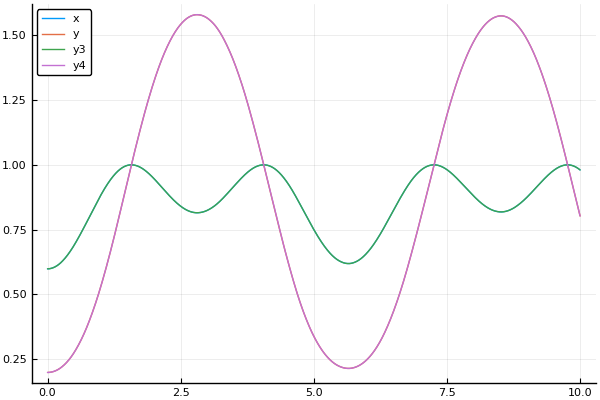

In [25]:
plot(t_reg,xtail_hist,label="x")
plot!(t_reg,ytail_hist,label="y")
plot!(t_reg,x_comp)
plot!(t_reg,y_comp)